In [104]:
#%pip install phik

In [105]:
"""
Ablation Study: Intergenic Distance Feature Importance

This notebook evaluates the impact of the intergenic_distance feature on model 
performance by randomizing its values and comparing prediction metrics.
"""

# Standard library imports
import warnings
from pathlib import Path

# Third-party imports
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

print("✅ Imports complete")


✅ Imports complete


## Load Models


In [106]:
# Load feature metadata and models
models_dir = Path("models")

# Load feature metadata
metadata = joblib.load(models_dir / "feature_metadata.joblib")
feature_cols = metadata['feature_cols']
numeric_features = metadata['numeric_features']
binary_features = metadata['binary_features']
target_col = metadata['target_col']

print(f"📊 Feature Configuration:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Numeric features: {len(numeric_features)}")
print(f"   Binary features: {len(binary_features)}")
print(f"\n   Target column: '{target_col}'")


📊 Feature Configuration:
   Total features: 77
   Numeric features: 69
   Binary features: 8

   Target column: 'Label'


In [107]:
# Load all trained models
model_names = ['logistic_regression', 'random_forest', 'xgboost', 'svm', 'mlp','naive_bayes']

models = {}
for name in model_names:
    model_path = models_dir / f"{name}.joblib"
    models[name] = joblib.load(model_path)
    print(f"✅ Loaded {name}")

print(f"\n📦 Total models loaded: {len(models)}")


✅ Loaded logistic_regression
✅ Loaded random_forest
✅ Loaded xgboost
✅ Loaded svm
✅ Loaded mlp
✅ Loaded naive_bayes

📦 Total models loaded: 6


## Ablation functions

In [108]:
def ablate_feature(X: pd.DataFrame, feature_name: str, 
                   method: str = "shuffle", random_state: int = 42,
                   X_train: pd.DataFrame | None = None) -> pd.DataFrame:
    """
    Ablate a feature by randomizing its values.
    
    Args:
        X: DataFrame containing the feature (to be ablated)
        feature_name: Name of the feature column to ablate
        method: Ablation method - "shuffle" (permute values), "random" (sample from distribution)
        random_state: Random seed for reproducibility
        X_train: Optional training DataFrame for computing statistics (avoids data leakage)
                 If None, statistics are computed from X
        
    Returns:
        DataFrame with the ablated feature
    """
    rng = np.random.default_rng(random_state)
    X_ablated = X.copy()
    
    # Use X_train for statistics if provided, otherwise use X
    X_stats = X_train if X_train is not None else X
    
    if method == "shuffle":
        # Shuffle/permute existing values (preserves distribution)
        X_ablated[feature_name] = rng.permutation(X[feature_name].values)
    elif method == "random":
        # Sample from normal distribution matching training mean/std
        mean = X_stats[feature_name].mean()
        std = X_stats[feature_name].std()
        X_ablated[feature_name] = rng.normal(mean, std, size=len(X))
    elif method == "zero":
        # Set all values to zero
        X_ablated[feature_name] = 0
    elif method == "mean":
        # Set all values to the training mean
        X_ablated[feature_name] = X_stats[feature_name].mean()
    else:
        raise ValueError(f"Unknown ablation method: {method}")
    
    return X_ablated


def ablate_features(X: pd.DataFrame, feature_names: list[str], 
                    method: str = "shuffle", random_state: int = 42,
                    X_train: pd.DataFrame | None = None) -> pd.DataFrame:
    """
    Ablate multiple features together by randomizing their values.
    
    Args:
        X: DataFrame containing the features (to be ablated)
        feature_names: List of feature column names to ablate
        method: Ablation method - "shuffle" (permute values), "random" (sample from distribution)
        random_state: Random seed for reproducibility
        X_train: Optional training DataFrame for computing statistics (avoids data leakage)
                 If None, statistics are computed from X
        
    Returns:
        DataFrame with the ablated features
    """
    rng = np.random.default_rng(random_state)
    X_ablated = X.copy()
    
    # Use X_train for statistics if provided, otherwise use X
    X_stats = X_train if X_train is not None else X
    
    for feature_name in feature_names:
        if method == "shuffle":
            X_ablated[feature_name] = rng.permutation(X[feature_name].values)
        elif method == "random":
            mean = X_stats[feature_name].mean()
            std = X_stats[feature_name].std()
            X_ablated[feature_name] = rng.normal(mean, std, size=len(X))
        elif method == "zero":
            X_ablated[feature_name] = 0
        elif method == "mean":
            X_ablated[feature_name] = X_stats[feature_name].mean()
        else:
            raise ValueError(f"Unknown ablation method: {method}")
    
    return X_ablated


def plot_feature_distribution(
    X: pd.DataFrame, 
    y: pd.Series, 
    feature_name: str,
    class_labels: dict[int, str] | None = None,
    bins: int = 50,
    figsize: tuple[int, int] = (12, 4),
    save_path: str | None = None
) -> None:
    """
    Plot distribution of a feature by class. Automatically detects binary features
    and uses appropriate visualization (grouped bar chart for binary, histogram/boxplot for continuous).
    
    Args:
        X: DataFrame containing features
        y: Series containing class labels
        feature_name: Name of the feature to visualize
        class_labels: Optional dict mapping class values to display names
                      e.g., {0: 'Non-operon', 1: 'Operon'}
        bins: Number of histogram bins (for continuous features)
        figsize: Figure size as (width, height)
        save_path: Optional path to save the figure (e.g., 'graphs/feature_dist.png')
    """
    if class_labels is None:
        class_labels = {label: f"Class {label}" for label in sorted(y.unique())}
    
    classes = sorted(y.unique())
    feature_values = X[feature_name]
    unique_vals = feature_values.unique()
    
    # Detect if feature is binary (0/1 or only 2 unique values)
    is_binary = (len(unique_vals) <= 2) or (set(unique_vals).issubset({0, 1, 0.0, 1.0}))
    
    print(f"📊 Feature Statistics for '{feature_name}':")
    print(f"{'='*50}")
    print(f"   Type: {'Binary' if is_binary else 'Continuous'}")
    print(feature_values.describe())
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    if is_binary:
        # Binary feature: Use grouped bar chart showing proportions
        feature_vals = sorted([int(v) for v in unique_vals])
        x = np.arange(len(classes))
        width = 0.35
        
        # Calculate proportions for each class
        proportions = {fv: [] for fv in feature_vals}
        counts = {fv: [] for fv in feature_vals}
        
        for label in classes:
            subset = X[y == label][feature_name]
            total = len(subset)
            for fv in feature_vals:
                count = (subset == fv).sum()
                counts[fv].append(count)
                proportions[fv].append(count / total * 100)
        
        # Plot 1: Grouped bar chart (counts)
        for i, fv in enumerate(feature_vals):
            offset = (i - len(feature_vals)/2 + 0.5) * width
            bars = axes[0].bar(x + offset, counts[fv], width, 
                              label=f'{feature_name}={fv}', alpha=0.8)
            # Add count labels on bars
            for bar, count in zip(bars, counts[fv]):
                axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                           str(count), ha='center', va='bottom', fontsize=9)
        
        axes[0].set_xlabel('Class')
        axes[0].set_ylabel('Count')
        axes[0].set_title(f'Distribution of {feature_name} by Class')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels([f"{class_labels[c]} ({c})" for c in classes])
        axes[0].legend()
        
        # Plot 2: Stacked percentage bar chart
        bottom = np.zeros(len(classes))
        colors = ['#E94F37', '#2E86AB']
        for i, fv in enumerate(feature_vals):
            axes[1].bar(x, proportions[fv], width=0.6, bottom=bottom, 
                       label=f'{feature_name}={fv}', color=colors[i % len(colors)], alpha=0.8)
            # Add percentage labels
            for j, (prop, b) in enumerate(zip(proportions[fv], bottom)):
                if prop > 5:  # Only show label if segment is big enough
                    axes[1].text(x[j], b + prop/2, f'{prop:.1f}%', 
                               ha='center', va='center', fontsize=9, color='white', fontweight='bold')
            bottom += proportions[fv]
        
        axes[1].set_xlabel('Class')
        axes[1].set_ylabel('Percentage')
        axes[1].set_title(f'{feature_name} Proportion by Class')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels([f"{class_labels[c]} ({c})" for c in classes])
        axes[1].legend(loc='upper right')
        axes[1].set_ylim(0, 105)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved distribution plot to: {save_path}")
        plt.show()
        
        # Binary-specific statistics
        print(f"\n📈 Class-wise statistics (Binary Feature):")
        for label in classes:
            subset = X[y == label][feature_name]
            total = len(subset)
            ones = (subset == 1).sum()
            zeros = (subset == 0).sum()
            print(f"\n   {class_labels[label]} (Class {label}):")
            print(f"      Total: {total}")
            print(f"      {feature_name}=0: {zeros} ({zeros/total*100:.1f}%)")
            print(f"      {feature_name}=1: {ones} ({ones/total*100:.1f}%)")
    
    else:
        # Continuous feature: Use histogram and boxplot
        for label in classes:
            subset = X[y == label][feature_name]
            axes[0].hist(subset, bins=bins, alpha=0.6, 
                         label=f"{class_labels[label]} ({label})")
        axes[0].set_xlabel(feature_name)
        axes[0].set_ylabel("Frequency")
        axes[0].set_title(f"Distribution of {feature_name}")
        axes[0].legend()
        
        # Box plot by class
        data_by_class = [X[y == label][feature_name] for label in classes]
        box_labels = [f"{class_labels[label]} ({label})" for label in classes]
        axes[1].boxplot(data_by_class, labels=box_labels)
        axes[1].set_ylabel(feature_name)
        axes[1].set_title(f"{feature_name} by Class")
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved distribution plot to: {save_path}")
        plt.show()
        
        # Continuous statistics
        print(f"\n📈 Class-wise statistics:")
        for label in classes:
            subset = X[y == label][feature_name]
            print(f"\n   {class_labels[label]} (Class {label}):")
            print(f"      Mean: {subset.mean():.2f}")
            print(f"      Median: {subset.median():.2f}")
            print(f"      Std: {subset.std():.2f}")


def evaluate_model(model, X: pd.DataFrame, y: pd.Series) -> dict:
    """
    Evaluate a model and return metrics.
    
    Args:
        model: Trained sklearn model/pipeline
        X: Feature DataFrame
        y: Target Series
        
    Returns:
        Dictionary of metrics
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_proba)
    }


def summarize_ablation_compact(
    results_original: dict,
    summary_dfs: dict[str, pd.DataFrame],
    feature_name: str,
    metric: str = "roc_auc"
) -> pd.DataFrame:
    """
    Create a compact summary table comparing original vs ablated performance.
    
    Args:
        results_original: Dict of {model_name: metrics_dict} for original data
        summary_dfs: Dict of {method: DataFrame} with ablation results
        feature_name: Name of the ablated feature (for display)
        metric: Metric to display (default: 'roc_auc')
        
    Returns:
        DataFrame with compact comparison
    """
    metric_display = metric.upper().replace('_', '-')
    
    print(f"\n📊 Compact Comparison ({metric_display}) for '{feature_name}':")
    print(f"{'='*80}")
    
    comparison_rows = []
    for model_name in results_original.keys():
        row = {
            'Model': model_name.replace('_', ' ').title(),
            f'{metric_display} (Original)': results_original[model_name][metric],
        }
        
        for method in summary_dfs.keys():
            df = summary_dfs[method]
            row[f'{metric_display} ({method.title()})'] = df[df['model'] == model_name][f'{metric}_ablated_mean'].values[0]
            row[f'Δ {method.title()}'] = df[df['model'] == model_name][f'{metric}_delta'].values[0]
        
        comparison_rows.append(row)
    
    comparison_df = pd.DataFrame(comparison_rows)
    display(comparison_df.round(4))
    return comparison_df


def interpret_model_ablation(
    model_name: str,
    results_original: dict,
    summary_dfs: dict[str, pd.DataFrame],
    feature_name: str,
    threshold: float = 0.005
) -> None:
    """
    Provide detailed interpretation of ablation results for a specific model.
    
    Args:
        model_name: Name of the model to interpret (e.g., 'xgboost')
        results_original: Dict of {model_name: metrics_dict} for original data
        summary_dfs: Dict of {method: DataFrame} with ablation results
        feature_name: Name of the ablated feature
        threshold: Minimum delta to consider significant (default: 0.005)
    """
    if model_name not in results_original:
        print(f"❌ Model '{model_name}' not found. Available: {list(results_original.keys())}")
        return
    
    model_display = model_name.replace('_', ' ').title()
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    print(f"\n{'='*80}")
    print(f"🔍 INTERPRETATION: {model_display} — Feature: '{feature_name}'")
    print(f"{'='*80}")
    
    # Original performance
    print(f"\n📊 Original Performance:")
    orig = results_original[model_name]
    for metric in metrics:
        print(f"   {metric.upper():<12}: {orig[metric]:.4f}")
    
    # Ablation impacts by method
    for method in summary_dfs.keys():
        df = summary_dfs[method]
        row = df[df['model'] == model_name].iloc[0]
        
        method_desc = "Permutation" if method == "shuffle" else "Random Sampling"
        print(f"\n🔀 {method.upper()} Ablation ({method_desc}):")
        print(f"{'─'*60}")
        
        for metric in metrics:
            orig_val = row[f'{metric}_original']
            abl_mean = row[f'{metric}_ablated_mean']
            abl_std = row[f'{metric}_ablated_std']
            delta = row[f'{metric}_delta']
            pct = row[f'{metric}_pct_change']
            
            sign = "↓" if delta < -threshold else "↑" if delta > threshold else "≈"
            print(f"   {metric.upper():<12}: {abl_mean:.4f}±{abl_std:.4f}  (Δ={delta:+.4f} {sign}, {pct:+.2f}%)")
    
    # Get ROC-AUC deltas for interpretation
    shuffle_roc_auc_delta = summary_dfs['shuffle'][summary_dfs['shuffle']['model'] == model_name]['roc_auc_delta'].values[0]
    random_roc_auc_delta = summary_dfs['random'][summary_dfs['random']['model'] == model_name]['roc_auc_delta'].values[0]
    
    # Model-specific interpretation
    print(f"\n{'─'*80}")
    print(f"📝 INTERPRETATION for {model_display}:")
    print(f"{'─'*80}")
    
    # Sensitivity analysis
    if abs(random_roc_auc_delta) > abs(shuffle_roc_auc_delta) + threshold:
        sensitivity = "distribution-sensitive"
        print(f"   • More sensitive to RANDOM ablation (distribution changes)")
        print(f"   • May be learning specific value patterns, not just associations")
    elif abs(shuffle_roc_auc_delta) > abs(random_roc_auc_delta) + threshold:
        sensitivity = "association-sensitive"
        print(f"   • More sensitive to SHUFFLE ablation (association breaking)")
        print(f"   • Primarily relies on feature-target relationship")
    else:
        sensitivity = "equally sensitive"
        print(f"   • Equally sensitive to both ablation methods")
        print(f"   • Robust to the specific ablation approach")
    
    # Feature importance assessment - UPDATED THRESHOLDS
    avg_delta = (shuffle_roc_auc_delta + random_roc_auc_delta) / 2
    avg_pct_drop = abs(avg_delta) * 100  # Convert to percentage points
    
    # Thresholds based on observed data distribution
    if avg_pct_drop > 15:  # >15pp drop (catastrophic features like strand_concordant)
        importance = "CRITICAL"
        print(f"\n   🔴 Feature Importance: {importance}")
        print(f"      '{feature_name}' is CRITICAL for this model")
        print(f"      ROC-AUC drop: {avg_delta:.4f} ({avg_pct_drop:.1f} percentage points)")
        
    elif avg_pct_drop > 5:  # 5-15pp drop (major features like intergenic_distance for XGB)
        importance = "HIGH"
        print(f"\n   🟠 Feature Importance: {importance}")
        print(f"      '{feature_name}' is highly important")
        print(f"      ROC-AUC drop: {avg_delta:.4f} ({avg_pct_drop:.1f} percentage points)")
        
    elif avg_pct_drop > 1:  # 1-5pp drop (moderate contributors)
        importance = "MODERATE"
        print(f"\n   🟡 Feature Importance: {importance}")
        print(f"      '{feature_name}' contributes meaningfully")
        print(f"      ROC-AUC drop: {avg_delta:.4f} ({avg_pct_drop:.1f} percentage points)")
        
    elif avg_pct_drop > 0.3:  # 0.3-1pp drop (minor but measurable)
        importance = "LOW"
        print(f"\n   🟢 Feature Importance: {importance}")
        print(f"      '{feature_name}' has minor impact")
        print(f"      ROC-AUC drop: {avg_delta:.4f} ({avg_pct_drop:.1f} percentage points)")
    
    else:  # <0.3pp drop (negligible)
        importance = "MINIMAL/NONE"
        print(f"\n   ⚪ Feature Importance: {importance}")
        print(f"      '{feature_name}' has negligible impact")
        print(f"      ROC-AUC drop: {avg_delta:+.4f} ({avg_pct_drop:.1f} percentage points)")


def plot_ablation_bar_chart(
    results_original: dict,
    summary_dfs: dict[str, pd.DataFrame],
    feature_name: str,
    model_names: list[str],
    save_path: str | None = None,
    figsize: tuple[int, int] = (16, 10)
) -> None:
    """
    Plot bar chart comparing original vs ablated performance across models.
    
    Args:
        results_original: Dict of {model_name: metrics_dict} for original data
        summary_dfs: Dict of {method: DataFrame} with ablation results
        feature_name: Name of the ablated feature
        model_names: List of model names to include
        save_path: Optional path to save the figure
        figsize: Figure size
    """
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    model_names_display = [name.replace('_', ' ').title() for name in model_names]
    x = np.arange(len(model_names_display))
    width = 0.25
    
    colors = {'original': '#2E86AB', 'shuffle': '#E94F37', 'random': '#A23B72'}
    metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    for idx, metric in enumerate(metrics_list):
        ax = axes[idx]
        
        original_vals = [results_original[m][metric] for m in model_names]
        
        shuffle_means = [summary_dfs['shuffle'][summary_dfs['shuffle']['model'] == m][f'{metric}_ablated_mean'].values[0] 
                         for m in model_names]
        shuffle_stds = [summary_dfs['shuffle'][summary_dfs['shuffle']['model'] == m][f'{metric}_ablated_std'].values[0] 
                        for m in model_names]
        
        random_means = [summary_dfs['random'][summary_dfs['random']['model'] == m][f'{metric}_ablated_mean'].values[0] 
                        for m in model_names]
        random_stds = [summary_dfs['random'][summary_dfs['random']['model'] == m][f'{metric}_ablated_std'].values[0] 
                       for m in model_names]
        
        ax.bar(x - width, original_vals, width, label='Original', color=colors['original'], alpha=0.85)
        ax.bar(x, shuffle_means, width, yerr=shuffle_stds, 
               label='Shuffle', color=colors['shuffle'], alpha=0.85, capsize=2)
        ax.bar(x + width, random_means, width, yerr=random_stds, 
               label='Random', color=colors['random'], alpha=0.85, capsize=2)
        
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.upper()}')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names_display, rotation=45, ha='right')
        ax.legend(loc='lower right', fontsize=8)
        ax.set_ylim(0, 1.05)
    
    axes[-1].axis('off')
    
    plt.suptitle(f"Ablation Study: '{feature_name}' — Comparing Shuffle vs Random Methods", 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Plot saved to: {save_path}")
    
    plt.show()


def plot_ablation_heatmap(
    summary_dfs: dict[str, pd.DataFrame],
    feature_name: str,
    model_names: list[str],
    save_path: str | None = None,
    figsize: tuple[int, int] = (16, 6)
) -> None:
    """
    Plot side-by-side heatmaps showing % change for each ablation method.
    
    Args:
        summary_dfs: Dict of {method: DataFrame} with ablation results
        feature_name: Name of the ablated feature
        model_names: List of model names to include
        save_path: Optional path to save the figure
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    cmap = sns.diverging_palette(10, 130, as_cmap=True)
    metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    ablation_methods = ['shuffle', 'random']
    
    # Find global vmax for consistent color scale
    all_pcts = []
    for method in ablation_methods:
        for model_name in model_names:
            for metric in metrics_list:
                pct = summary_dfs[method][summary_dfs[method]['model'] == model_name][f'{metric}_pct_change'].values[0]
                all_pcts.append(pct)
    vmax = max(abs(min(all_pcts)), abs(max(all_pcts)))
    
    method_titles = {'shuffle': 'SHUFFLE (Permutation)', 'random': 'RANDOM (Normal Sampling)'}
    
    for idx, method in enumerate(ablation_methods):
        ax = axes[idx]
        
        pct_change_data = []
        for model_name in model_names:
            row_data = []
            for metric in metrics_list:
                pct = summary_dfs[method][summary_dfs[method]['model'] == model_name][f'{metric}_pct_change'].values[0]
                row_data.append(pct)
            pct_change_data.append(row_data)
        
        pct_df = pd.DataFrame(pct_change_data, 
                              index=[name.replace('_', ' ').title() for name in model_names],
                              columns=[m.upper() for m in metrics_list])
        
        sns.heatmap(pct_df, annot=True, fmt='.2f', cmap=cmap, center=0,
                    vmin=-vmax, vmax=vmax, ax=ax,
                    cbar_kws={'label': '% Change'})
        
        ax.set_title(f"{method_titles[method]}", fontsize=12, fontweight='bold')
        ax.set_ylabel('Model' if idx == 0 else '')
        ax.set_xlabel('Metric')
    
    plt.suptitle(f"Performance Change (%) After Ablating '{feature_name}'\n(Red/Negative = Feature was helpful for prediction)", 
                 fontsize=13, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Heatmap saved to: {save_path}")
    
    plt.show()


print("✅ Ablation functions defined")


✅ Ablation functions defined


# Data

In [109]:
# Load dataset
pairs_df = pd.read_csv("data/ecoli_pairs.csv")

# Extract features and target
X = pairs_df[feature_cols].copy()
y = pairs_df[target_col].astype(int)

print(f"📊 Dataset shape: {X.shape}")
print(f"\n📈 Class distribution:")
print(y.value_counts())

# Create train/val split (same as in training notebook for fair comparison)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

print(f"\n✅ Split sizes:")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")


📊 Dataset shape: (4297, 77)

📈 Class distribution:
Label
0    2550
1    1747
Name: count, dtype: int64

✅ Split sizes:
   Train: 3652 samples
   Val:   645 samples


In [110]:
'''# Compute and plot phik correlation heatmap
import phik

# Include target column for correlation analysis
df_for_corr = pairs_df[feature_cols + [target_col]].copy()

# Compute phik correlation matrix
print("📊 Computing phik correlations (handles mixed variable types)...")
phik_matrix = df_for_corr.phik_matrix()

# Plot heatmap
fig, ax = plt.subplots(figsize=(20, 16))

# Use a perceptually uniform colormap
sns.heatmap(
    phik_matrix,
    cmap='viridis',
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.1,
    cbar_kws={'label': 'φk Correlation', 'shrink': 0.8},
    ax=ax
)

ax.set_title("Phik Correlation Heatmap (Features + Target)", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("")
ax.set_ylabel("")

# Rotate labels for readability
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
plt.savefig("graphs/phik_correlation_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Heatmap saved to: graphs/phik_correlation_heatmap.png")

# Show top correlations with target
target_corrs = phik_matrix[target_col].drop(target_col).sort_values(ascending=False)
print(f"\n📈 Top 15 features correlated with '{target_col}' (by phik):")
print(target_corrs.head(15).to_string())'''

'# Compute and plot phik correlation heatmap\nimport phik\n\n# Include target column for correlation analysis\ndf_for_corr = pairs_df[feature_cols + [target_col]].copy()\n\n# Compute phik correlation matrix\nprint("📊 Computing phik correlations (handles mixed variable types)...")\nphik_matrix = df_for_corr.phik_matrix()\n\n# Plot heatmap\nfig, ax = plt.subplots(figsize=(20, 16))\n\n# Use a perceptually uniform colormap\nsns.heatmap(\n    phik_matrix,\n    cmap=\'viridis\',\n    vmin=0,\n    vmax=1,\n    square=True,\n    linewidths=0.1,\n    cbar_kws={\'label\': \'φk Correlation\', \'shrink\': 0.8},\n    ax=ax\n)\n\nax.set_title("Phik Correlation Heatmap (Features + Target)", fontsize=14, fontweight=\'bold\', pad=20)\nax.set_xlabel("")\nax.set_ylabel("")\n\n# Rotate labels for readability\nplt.xticks(rotation=90, fontsize=6)\nplt.yticks(rotation=0, fontsize=6)\n\nplt.tight_layout()\nplt.savefig("graphs/phik_correlation_heatmap.png", dpi=150, bbox_inches=\'tight\')\nplt.show()\n\nprint(

# Distance features


## Intergenic distance

📊 Feature Statistics for 'intergenic_distance':
   Type: Continuous
count     645.000000
mean      156.604651
std       340.341298
min         0.000000
25%        10.000000
50%        73.000000
75%       189.000000
max      5771.000000
Name: intergenic_distance, dtype: float64
💾 Saved distribution plot to: graphs/distance_feature_ablation/intergenic_distance_distribution.png


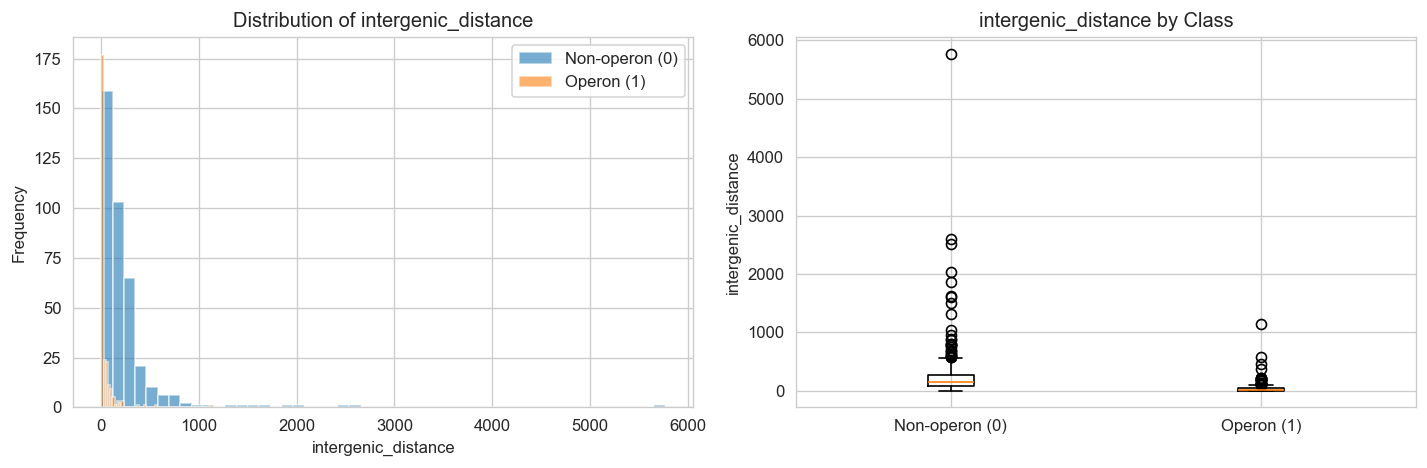


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 238.52
      Median: 149.00
      Std: 415.59

   Operon (Class 1):
      Mean: 36.85
      Median: 10.00
      Std: 93.68


In [111]:
# Examine the intergenic_distance feature
ablation_feature = "intergenic_distance"

plot_feature_distribution(
    X_val, y_val, 
    feature_name=ablation_feature,
    class_labels={0: 'Non-operon', 1: 'Operon'},
    save_path="graphs/distance_feature_ablation/intergenic_distance_distribution.png"
)


## Run Ablation Study: Intergenic Distance


In [112]:
# Run ablation study with BOTH methods for comparison
ablation_feature = "intergenic_distance"
n_runs = 10  # Number of random seeds to average over
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: '{ablation_feature}'")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original = {}
results_ablated = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation...")
    for seed in seeds:
        X_val_ablated = ablate_feature(X_val, ablation_feature, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics = evaluate_model(model, X_val_ablated, y_val)
            results_ablated[method][model_name].append(metrics)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete (both methods)!")


🔬 Ablation Study: 'intergenic_distance'
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete (both methods)!


## Results Summary


In [113]:
# Create summary DataFrames for BOTH methods
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs[method] = pd.DataFrame(summary_rows)

# Display formatted results for BOTH methods
for method in ablation_methods:
    summary_df = summary_dfs[method]
    method_desc = "Permutation (preserves distribution)" if method == "shuffle" else "Random Sampling (from normal dist)"
    
    print(f"\n{'='*100}")
    print(f"📊 ABLATION RESULTS: '{ablation_feature}' — Method: {method.upper()}")
    print(f"   ({method_desc})")
    print(f"{'='*100}")
    
    for metric in ['f1', 'accuracy', 'roc_auc']:  # Show key metrics
        print(f"\n{'─'*100}")
        print(f"📈 {metric.upper()}")
        print(f"{'─'*100}")
        print(f"{'Model':<25} {'Original':>12} {'Ablated (mean±std)':>22} {'Δ':>10} {'% Change':>12}")
        print(f"{'─'*100}")
        
        for _, row in summary_df.iterrows():
            orig = row[f'{metric}_original']
            abl_mean = row[f'{metric}_ablated_mean']
            abl_std = row[f'{metric}_ablated_std']
            delta = row[f'{metric}_delta']
            pct = row[f'{metric}_pct_change']
            
            sign = "↓" if delta < 0 else "↑" if delta > 0 else "="
            print(f"{row['model']:<25} {orig:>12.4f} {abl_mean:>12.4f}±{abl_std:.4f} {delta:>+9.4f} {sign} {pct:>+10.2f}%")



📊 ABLATION RESULTS: 'intergenic_distance' — Method: SHUFFLE
   (Permutation (preserves distribution))

────────────────────────────────────────────────────────────────────────────────────────────────────
📈 F1
────────────────────────────────────────────────────────────────────────────────────────────────────
Model                         Original     Ablated (mean±std)          Δ     % Change
────────────────────────────────────────────────────────────────────────────────────────────────────
logistic_regression             0.8423       0.8424±0.0009   +0.0001 ↑      +0.01%
random_forest                   0.8377       0.8489±0.0079   +0.0112 ↑      +1.33%
xgboost                         0.8582       0.7357±0.0166   -0.1226 ↓     -14.28%
svm                             0.8648       0.8612±0.0029   -0.0036 ↓      -0.41%
mlp                             0.8598       0.8455±0.0079   -0.0143 ↓      -1.66%
naive_bayes                     0.7783       0.7779±0.0013   -0.0004 ↓      -0.05%

───

## Visualization



💾 Heatmap saved to: graphs/distance_feature_ablation/intergenic_distance_ablation_heatmap_comparison.png


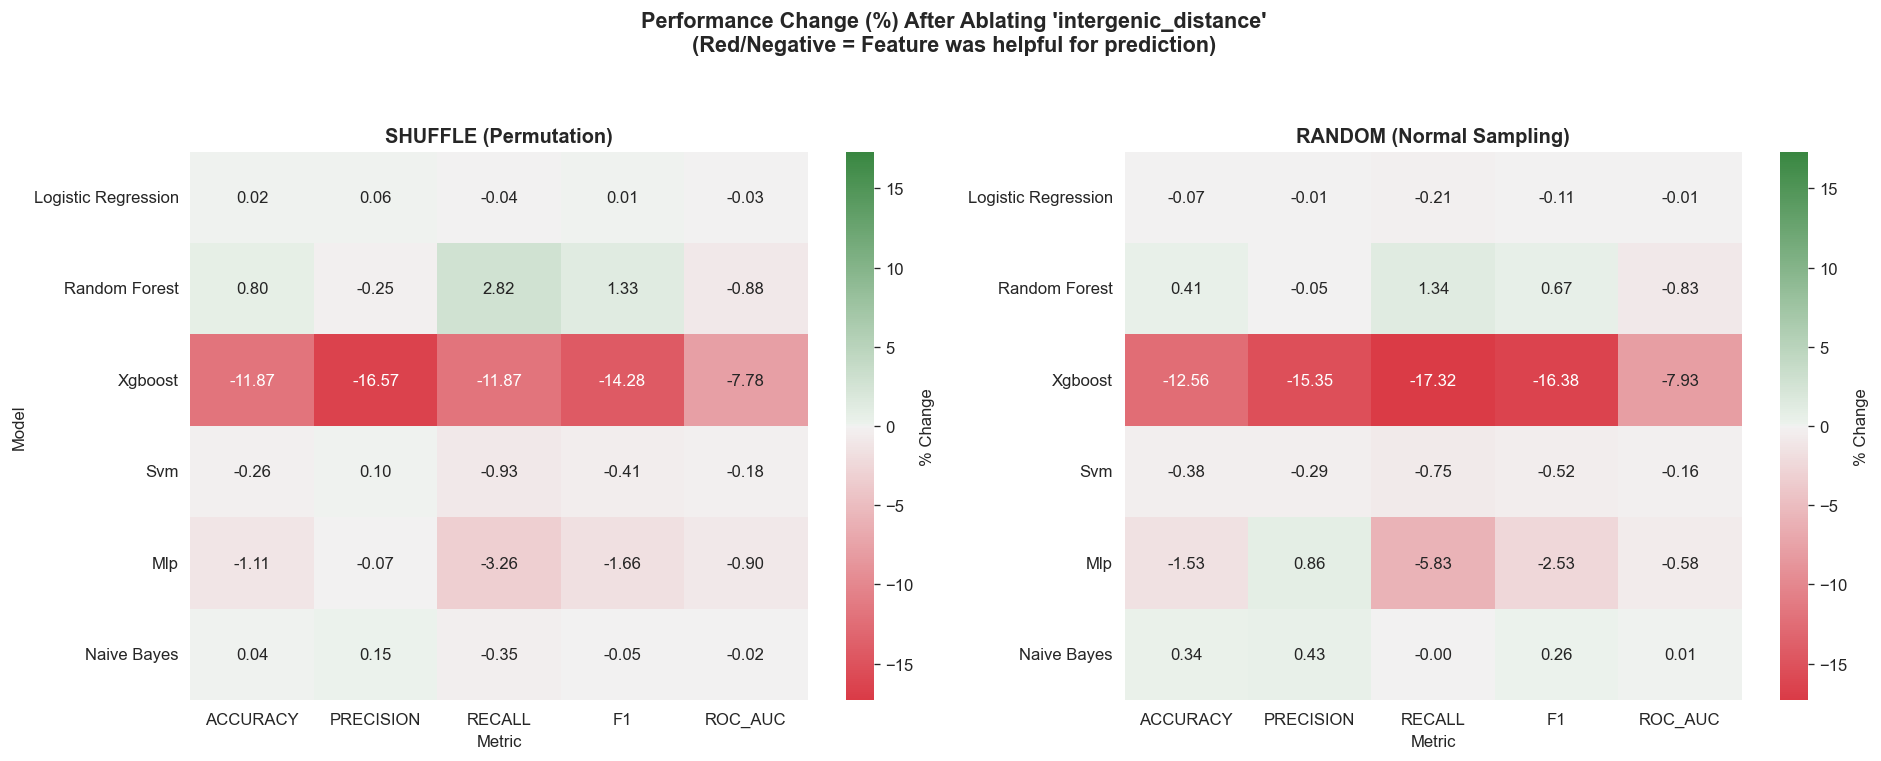

In [114]:
# Visualization: Heatmap for intergenic_distance
plot_ablation_heatmap(
    summary_dfs, ablation_feature,
    model_names=list(models.keys()),
    save_path=f"graphs/distance_feature_ablation/{ablation_feature}_ablation_heatmap_comparison.png"
)


## Interpretation & Summary


In [115]:
# Compact summary table
_ = summarize_ablation_compact(results_original, summary_dfs, ablation_feature, metric="roc_auc")

# Model-specific interpretations for all models
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original, summary_dfs, ablation_feature)



📊 Compact Comparison (ROC-AUC) for 'intergenic_distance':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9395,-0.0002,0.9397,-0.0000
1,Random Forest,0.9526,0.9442,-0.0084,0.9447,-0.0079
2,Xgboost,0.9548,0.8805,-0.0743,0.8791,-0.0757
3,Svm,0.9490,0.9472,-0.0018,0.9475,-0.0015
4,Mlp,0.9468,0.9382,-0.0086,0.9413,-0.0055
5,Naive Bayes,0.8275,0.8273,-0.0002,0.8276,0.0001



🔍 INTERPRETATION: Logistic Regression — Feature: 'intergenic_distance'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8637±0.0008  (Δ=+0.0002 ≈, +0.02%)
   PRECISION   : 0.7944±0.0011  (Δ=+0.0005 ≈, +0.06%)
   RECALL      : 0.8966±0.0011  (Δ=-0.0004 ≈, -0.04%)
   F1          : 0.8424±0.0009  (Δ=+0.0001 ≈, +0.01%)
   ROC_AUC     : 0.9395±0.0003  (Δ=-0.0002 ≈, -0.03%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8629±0.0010  (Δ=-0.0006 ≈, -0.07%)
   PRECISION   : 0.7938±0.0017  (Δ=-0.0001 ≈, -0.01%)
   RECALL      : 0.8950±0.0026  (Δ=-0.0019 ≈, -0.21%)
   F1          : 0.8414±0.0012  (Δ=-0.0009 ≈, -0.11%)
   ROC_AUC     : 0.9397±0.0002  (Δ=-0.0000 ≈, -0.01%)

───────────────────────────────────────────────

In [116]:
# Save results for BOTH methods to CSV
for method in ablation_methods:
    output_path = Path(f"graphs/distance_feature_ablation/ablation_results_{ablation_feature}_{method}.csv")
    summary_dfs[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df = pd.concat([summary_dfs['shuffle'], summary_dfs['random']], ignore_index=True)
combined_path = Path(f"graphs/distance_feature_ablation/ablation_results_{ablation_feature}_combined.csv")
combined_df.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/distance_feature_ablation/ablation_results_intergenic_distance_shuffle.csv
💾 Saved random results → graphs/distance_feature_ablation/ablation_results_intergenic_distance_random.csv
💾 Saved combined results → graphs/distance_feature_ablation/ablation_results_intergenic_distance_combined.csv


## Gene overlap

📊 Feature Statistics for 'genes_overlap':
   Type: Binary
count    645.000000
mean       0.175194
std        0.380428
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: genes_overlap, dtype: float64
💾 Saved distribution plot to: graphs/distance_feature_ablation/genes_overlap_distribution.png


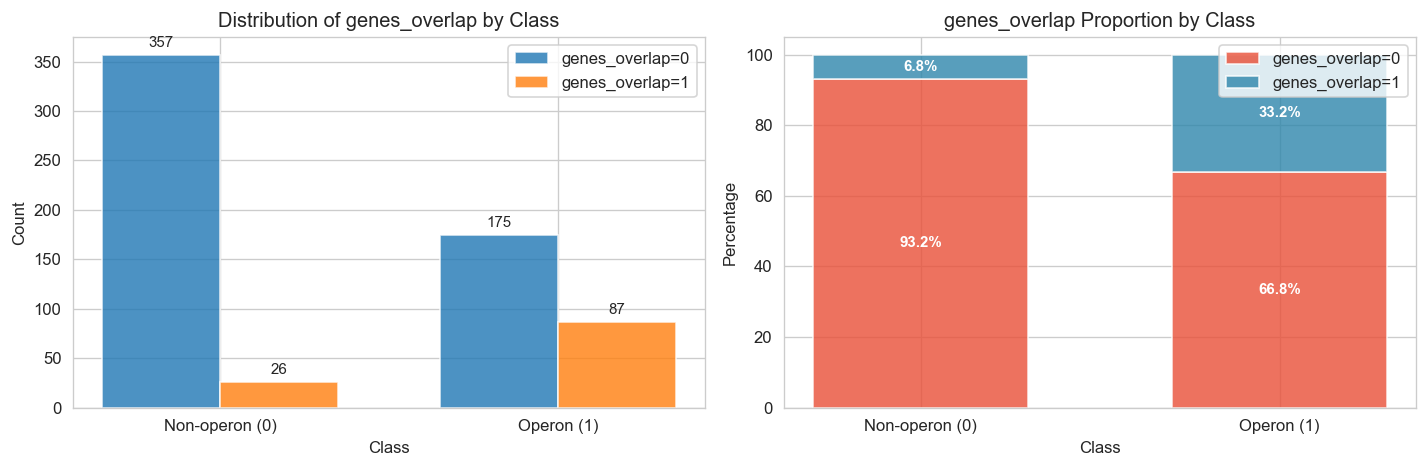


📈 Class-wise statistics (Binary Feature):

   Non-operon (Class 0):
      Total: 383
      genes_overlap=0: 357 (93.2%)
      genes_overlap=1: 26 (6.8%)

   Operon (Class 1):
      Total: 262
      genes_overlap=0: 175 (66.8%)
      genes_overlap=1: 87 (33.2%)


In [117]:
# Examine the genes_overlap feature
ablation_feature_overlap = "genes_overlap"

plot_feature_distribution(
    X_val, y_val, 
    feature_name=ablation_feature_overlap,
    class_labels={0: 'Non-operon', 1: 'Operon'},
    save_path="graphs/distance_feature_ablation/genes_overlap_distribution.png"
)


In [118]:
# Run ablation study for genes_overlap
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: '{ablation_feature_overlap}'")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_overlap = {}
results_ablated_overlap = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_overlap[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation...")
    for seed in seeds:
        X_val_ablated = ablate_feature(X_val, ablation_feature_overlap, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_overlap[method][model_name].append(metrics)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: 'genes_overlap'
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [119]:
# Create summary DataFrames for genes_overlap
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_overlap = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_overlap[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_overlap[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_overlap[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_overlap[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for genes_overlap")


✅ Summary DataFrames created for genes_overlap



💾 Heatmap saved to: graphs/distance_feature_ablation/genes_overlap_ablation_heatmap_comparison.png


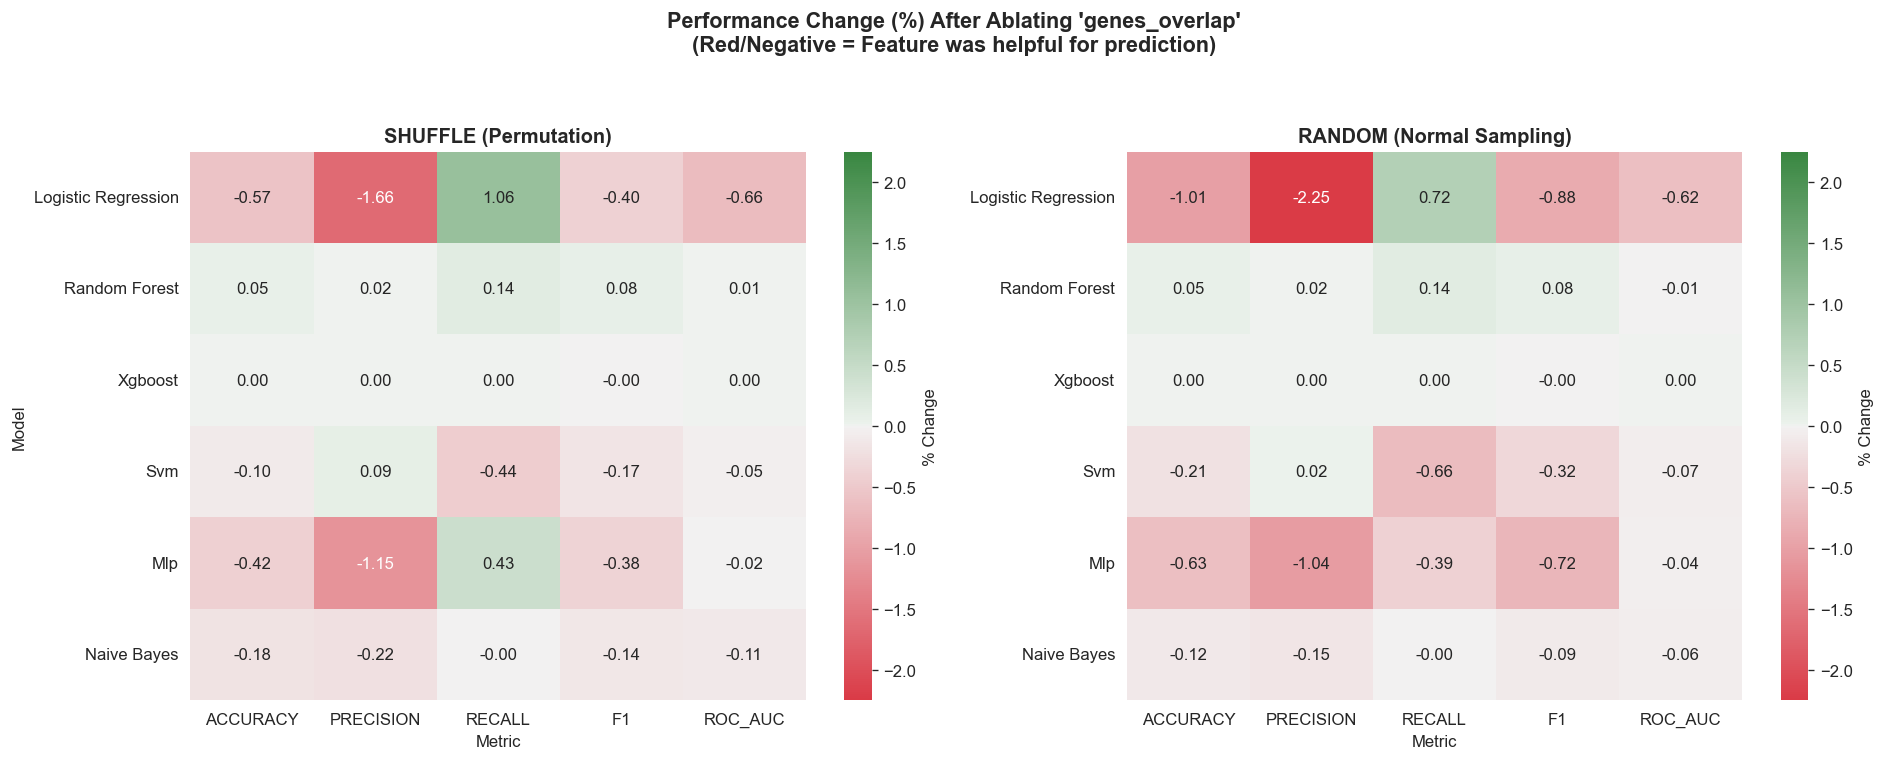

In [120]:
# Visualization: Heatmap for genes_overlap
plot_ablation_heatmap(
    summary_dfs_overlap, ablation_feature_overlap,
    model_names=list(models.keys()),
    save_path=f"graphs/distance_feature_ablation/{ablation_feature_overlap}_ablation_heatmap_comparison.png"
)


In [121]:
# Interpretation for genes_overlap
_ = summarize_ablation_compact(results_original_overlap, summary_dfs_overlap, ablation_feature_overlap, metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_overlap, summary_dfs_overlap, ablation_feature_overlap)



📊 Compact Comparison (ROC-AUC) for 'genes_overlap':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9335,-0.0062,0.9339,-0.0058
1,Random Forest,0.9526,0.9527,0.0001,0.9525,-0.0001
2,Xgboost,0.9548,0.9548,0.0000,0.9548,0.0000
3,Svm,0.9490,0.9485,-0.0005,0.9484,-0.0006
4,Mlp,0.9468,0.9466,-0.0002,0.9464,-0.0004
5,Naive Bayes,0.8275,0.8266,-0.0009,0.8270,-0.0005



🔍 INTERPRETATION: Logistic Regression — Feature: 'genes_overlap'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8586±0.0041  (Δ=-0.0050 ≈, -0.57%)
   PRECISION   : 0.7808±0.0050  (Δ=-0.0132 ↓, -1.66%)
   RECALL      : 0.9065±0.0071  (Δ=+0.0095 ↑, +1.06%)
   F1          : 0.8389±0.0047  (Δ=-0.0034 ≈, -0.40%)
   ROC_AUC     : 0.9335±0.0021  (Δ=-0.0062 ↓, -0.66%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8549±0.0055  (Δ=-0.0087 ↓, -1.01%)
   PRECISION   : 0.7761±0.0063  (Δ=-0.0178 ↓, -2.25%)
   RECALL      : 0.9034±0.0087  (Δ=+0.0065 ↑, +0.72%)
   F1          : 0.8349±0.0063  (Δ=-0.0074 ↓, -0.88%)
   ROC_AUC     : 0.9339±0.0020  (Δ=-0.0058 ↓, -0.62%)

─────────────────────────────────────────────────────

In [122]:
# Save results for genes_overlap
for method in ablation_methods:
    output_path = Path(f"graphs/distance_feature_ablation/ablation_results_{ablation_feature_overlap}_{method}.csv")
    summary_dfs_overlap[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_overlap = pd.concat([summary_dfs_overlap['shuffle'], summary_dfs_overlap['random']], ignore_index=True)
combined_path = Path(f"graphs/distance_feature_ablation/ablation_results_{ablation_feature_overlap}_combined.csv")
combined_df_overlap.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/distance_feature_ablation/ablation_results_genes_overlap_shuffle.csv
💾 Saved random results → graphs/distance_feature_ablation/ablation_results_genes_overlap_random.csv
💾 Saved combined results → graphs/distance_feature_ablation/ablation_results_genes_overlap_combined.csv


## Overlap Length


📊 Feature Statistics for 'overlap_length':
   Type: Continuous
count    645.000000
mean       3.877519
std       34.411587
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      723.000000
Name: overlap_length, dtype: float64
💾 Saved distribution plot to: graphs/distance_feature_ablation/overlap_length_distribution.png


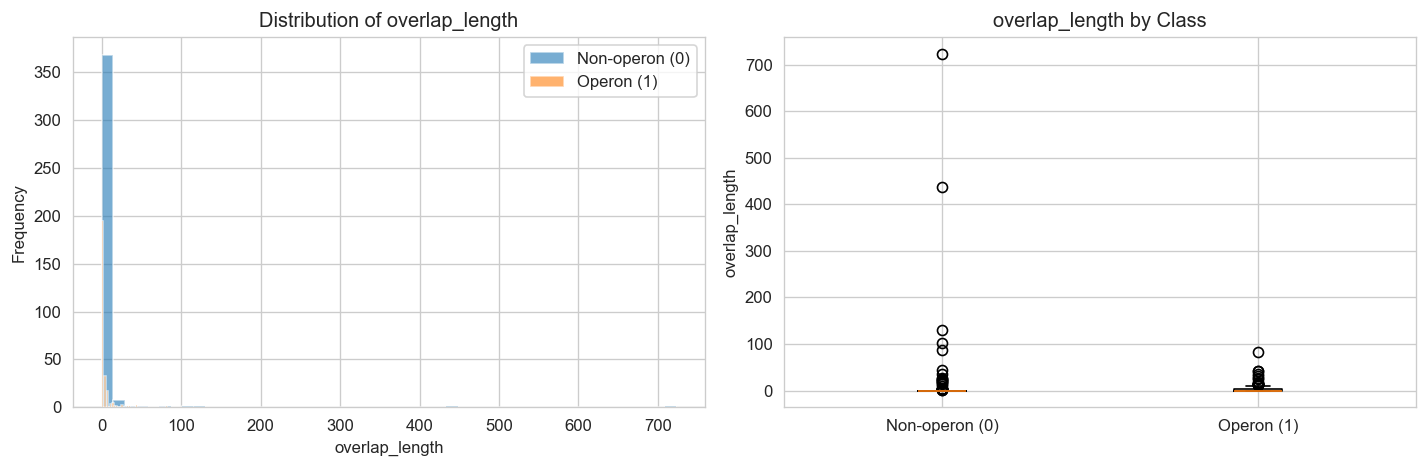


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 4.66
      Median: 0.00
      Std: 44.20

   Operon (Class 1):
      Mean: 2.74
      Median: 0.00
      Std: 7.74


In [123]:
# Examine the overlap_length feature
ablation_feature_overlap_len = "overlap_length"

plot_feature_distribution(
    X_val, y_val, 
    feature_name=ablation_feature_overlap_len,
    class_labels={0: 'Non-operon', 1: 'Operon'},
    save_path="graphs/distance_feature_ablation/overlap_length_distribution.png"
)


In [124]:
# Run ablation study for overlap_length
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: '{ablation_feature_overlap_len}'")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_overlap_len = {}
results_ablated_overlap_len = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_overlap_len[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation...")
    for seed in seeds:
        X_val_ablated = ablate_feature(X_val, ablation_feature_overlap_len, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_overlap_len[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: 'overlap_length'
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [125]:
# Create summary DataFrames for overlap_length
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_overlap_len = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_overlap_len[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_overlap_len[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_overlap_len[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_overlap_len[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for overlap_length")


✅ Summary DataFrames created for overlap_length



💾 Heatmap saved to: graphs/distance_feature_ablation/overlap_length_ablation_heatmap_comparison.png


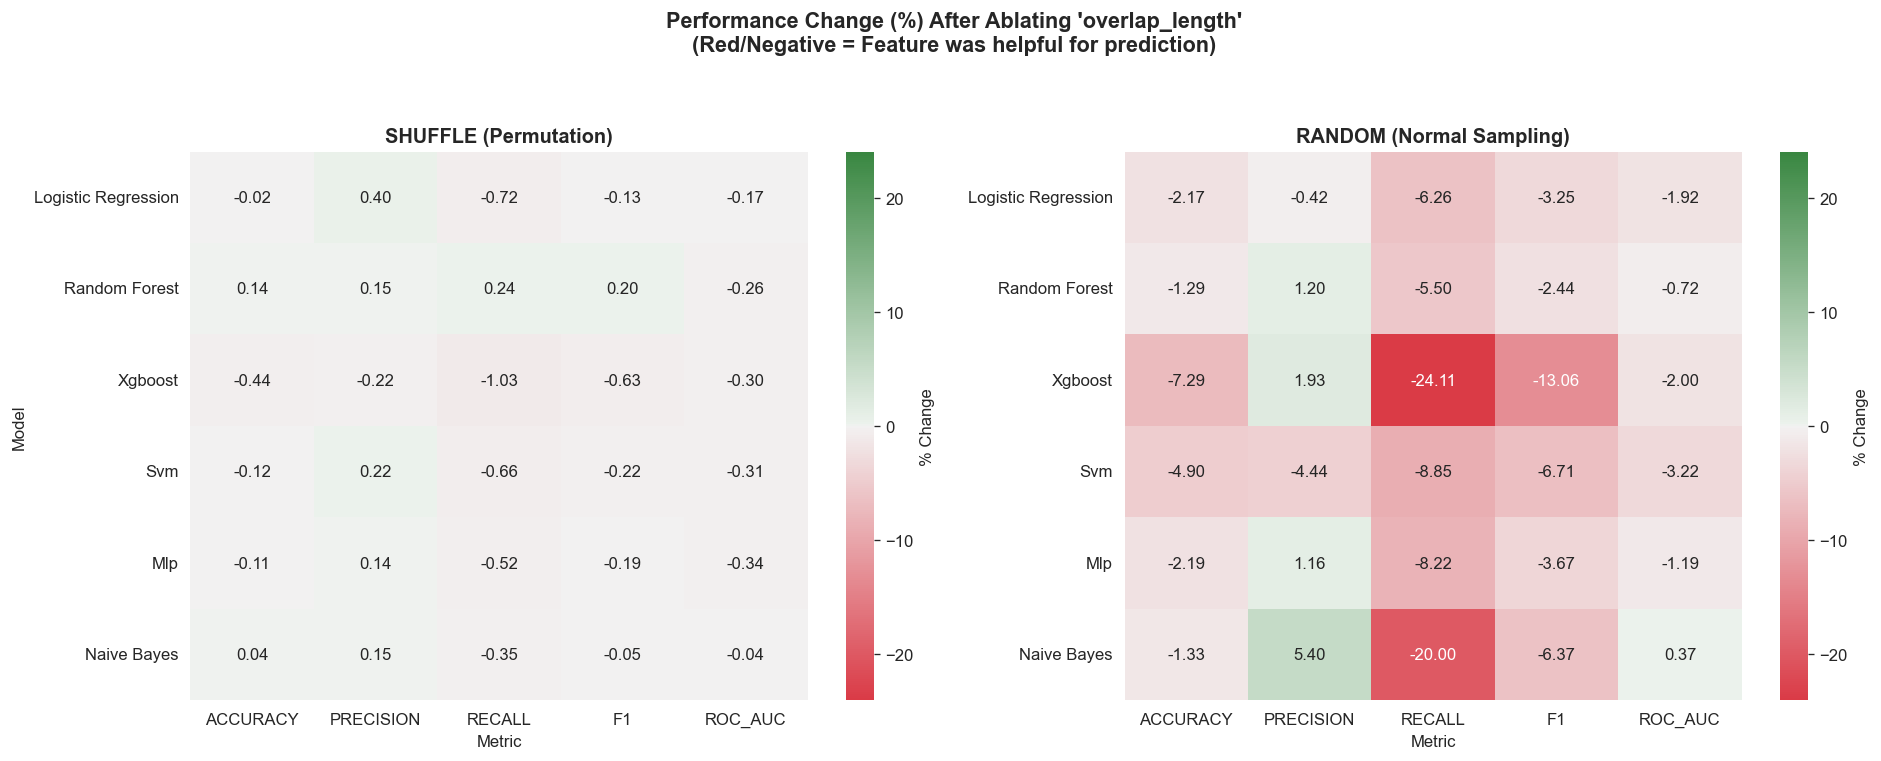

In [126]:
# Visualization: Heatmap for overlap_length
plot_ablation_heatmap(
    summary_dfs_overlap_len, ablation_feature_overlap_len,
    model_names=list(models.keys()),
    save_path=f"graphs/distance_feature_ablation/{ablation_feature_overlap_len}_ablation_heatmap_comparison.png"
)


In [127]:
# Interpretation for overlap_length
_ = summarize_ablation_compact(results_original_overlap_len, summary_dfs_overlap_len, ablation_feature_overlap_len, metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_overlap_len, summary_dfs_overlap_len, ablation_feature_overlap_len)



📊 Compact Comparison (ROC-AUC) for 'overlap_length':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9381,-0.0016,0.9217,-0.0181
1,Random Forest,0.9526,0.9501,-0.0025,0.9457,-0.0069
2,Xgboost,0.9548,0.9520,-0.0028,0.9357,-0.0191
3,Svm,0.9490,0.9461,-0.0029,0.9184,-0.0306
4,Mlp,0.9468,0.9436,-0.0032,0.9355,-0.0112
5,Naive Bayes,0.8275,0.8272,-0.0003,0.8305,0.0030



🔍 INTERPRETATION: Logistic Regression — Feature: 'overlap_length'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8634±0.0029  (Δ=-0.0002 ≈, -0.02%)
   PRECISION   : 0.7971±0.0037  (Δ=+0.0032 ≈, +0.40%)
   RECALL      : 0.8905±0.0048  (Δ=-0.0065 ↓, -0.72%)
   F1          : 0.8412±0.0034  (Δ=-0.0011 ≈, -0.13%)
   ROC_AUC     : 0.9381±0.0018  (Δ=-0.0016 ≈, -0.17%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8448±0.0061  (Δ=-0.0188 ↓, -2.17%)
   PRECISION   : 0.7906±0.0104  (Δ=-0.0033 ≈, -0.42%)
   RECALL      : 0.8408±0.0090  (Δ=-0.0561 ↓, -6.26%)
   F1          : 0.8149±0.0067  (Δ=-0.0274 ↓, -3.25%)
   ROC_AUC     : 0.9217±0.0048  (Δ=-0.0181 ↓, -1.92%)

────────────────────────────────────────────────────

In [128]:
# Save results for overlap_length
for method in ablation_methods:
    output_path = Path(f"graphs/distance_feature_ablation/ablation_results_{ablation_feature_overlap_len}_{method}.csv")
    summary_dfs_overlap_len[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_overlap_len = pd.concat([summary_dfs_overlap_len['shuffle'], summary_dfs_overlap_len['random']], ignore_index=True)
combined_path = Path(f"graphs/distance_feature_ablation/ablation_results_{ablation_feature_overlap_len}_combined.csv")
combined_df_overlap_len.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/distance_feature_ablation/ablation_results_overlap_length_shuffle.csv
💾 Saved random results → graphs/distance_feature_ablation/ablation_results_overlap_length_random.csv
💾 Saved combined results → graphs/distance_feature_ablation/ablation_results_overlap_length_combined.csv


# GC content features

## GC content difference

📊 Feature Statistics for 'gc_content_diff':
   Type: Continuous
count    645.000000
mean       0.040111
std        0.043166
min        0.000000
25%        0.012455
50%        0.027778
75%        0.051515
max        0.299460
Name: gc_content_diff, dtype: float64
💾 Saved distribution plot to: graphs/gc_content_feature_ablation/gc_content_diff_distribution.png


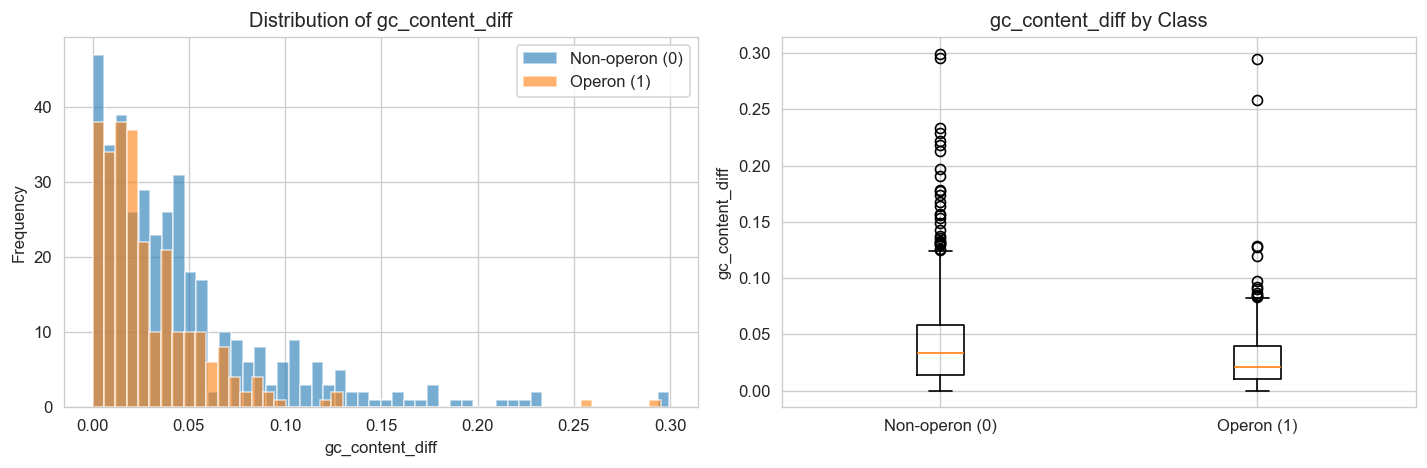


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 0.05
      Median: 0.03
      Std: 0.05

   Operon (Class 1):
      Mean: 0.03
      Median: 0.02
      Std: 0.03


In [129]:
# Examine the gc_content_diff feature
ablation_feature_gc = "gc_content_diff"

plot_feature_distribution(
    X_val, y_val, 
    feature_name=ablation_feature_gc,
    class_labels={0: 'Non-operon', 1: 'Operon'},
    save_path="graphs/gc_content_feature_ablation/gc_content_diff_distribution.png"
)


In [130]:
# Run ablation study for gc_content_diff
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: '{ablation_feature_gc}'")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_gc = {}
results_ablated_gc = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_gc[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation...")
    for seed in seeds:
        X_val_ablated = ablate_feature(X_val, ablation_feature_gc, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_gc[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: 'gc_content_diff'
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [131]:
# Create summary DataFrames for gc_content_diff
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_gc = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_gc[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_gc[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_gc[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_gc[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for gc_content_diff")


✅ Summary DataFrames created for gc_content_diff



💾 Heatmap saved to: graphs/gc_content_feature_ablation/gc_content_diff_ablation_heatmap_comparison.png


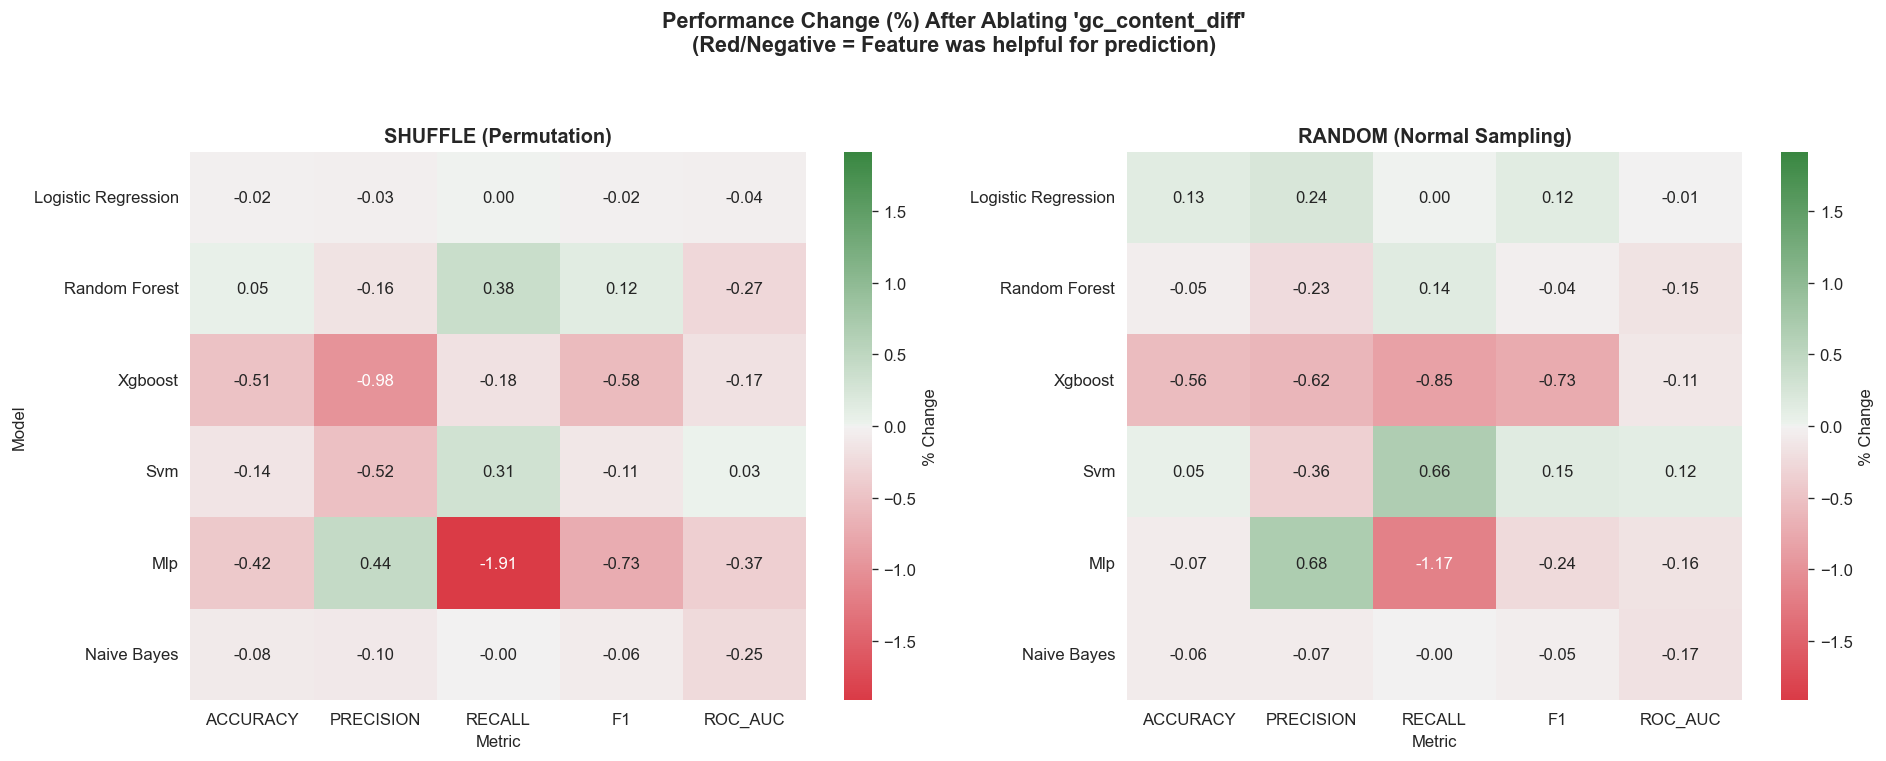

In [132]:
# Visualization: Heatmap for gc_content_diff
plot_ablation_heatmap(
    summary_dfs_gc, ablation_feature_gc,
    model_names=list(models.keys()),
    save_path=f"graphs/gc_content_feature_ablation/{ablation_feature_gc}_ablation_heatmap_comparison.png"
)


In [133]:
# Interpretation for gc_content_diff
_ = summarize_ablation_compact(results_original_gc, summary_dfs_gc, ablation_feature_gc, metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_gc, summary_dfs_gc, ablation_feature_gc)



📊 Compact Comparison (ROC-AUC) for 'gc_content_diff':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9393,-0.0004,0.9396,-0.0001
1,Random Forest,0.9526,0.9500,-0.0026,0.9511,-0.0015
2,Xgboost,0.9548,0.9532,-0.0016,0.9537,-0.0011
3,Svm,0.9490,0.9493,0.0003,0.9501,0.0011
4,Mlp,0.9468,0.9433,-0.0035,0.9452,-0.0016
5,Naive Bayes,0.8275,0.8254,-0.0021,0.8261,-0.0014



🔍 INTERPRETATION: Logistic Regression — Feature: 'gc_content_diff'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8634±0.0018  (Δ=-0.0002 ≈, -0.02%)
   PRECISION   : 0.7937±0.0026  (Δ=-0.0003 ≈, -0.03%)
   RECALL      : 0.8969±0.0038  (Δ=+0.0000 ≈, +0.00%)
   F1          : 0.8421±0.0021  (Δ=-0.0002 ≈, -0.02%)
   ROC_AUC     : 0.9393±0.0006  (Δ=-0.0004 ≈, -0.04%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8647±0.0023  (Δ=+0.0011 ≈, +0.13%)
   PRECISION   : 0.7958±0.0021  (Δ=+0.0019 ≈, +0.24%)
   RECALL      : 0.8969±0.0054  (Δ=+0.0000 ≈, +0.00%)
   F1          : 0.8433±0.0030  (Δ=+0.0011 ≈, +0.12%)
   ROC_AUC     : 0.9396±0.0005  (Δ=-0.0001 ≈, -0.01%)

───────────────────────────────────────────────────

In [134]:
# Save results for gc_content_diff
for method in ablation_methods:
    output_path = Path(f"graphs/gc_content_feature_ablation/ablation_results_{ablation_feature_gc}_{method}.csv")
    summary_dfs_gc[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_gc = pd.concat([summary_dfs_gc['shuffle'], summary_dfs_gc['random']], ignore_index=True)
combined_path = Path(f"graphs/gc_content_feature_ablation/ablation_results_{ablation_feature_gc}_combined.csv")
combined_df_gc.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/gc_content_feature_ablation/ablation_results_gc_content_diff_shuffle.csv
💾 Saved random results → graphs/gc_content_feature_ablation/ablation_results_gc_content_diff_random.csv
💾 Saved combined results → graphs/gc_content_feature_ablation/ablation_results_gc_content_diff_combined.csv


# GC content A,B

📊 Feature Statistics for 'gc_content_A':
   Type: Continuous
count    645.000000
mean       0.507677
std        0.054807
min        0.250000
25%        0.488936
50%        0.522013
75%        0.543708
max        0.607106
Name: gc_content_A, dtype: float64
💾 Saved distribution plot to: graphs/gc_content_feature_ablation/gc_content_A_distribution.png


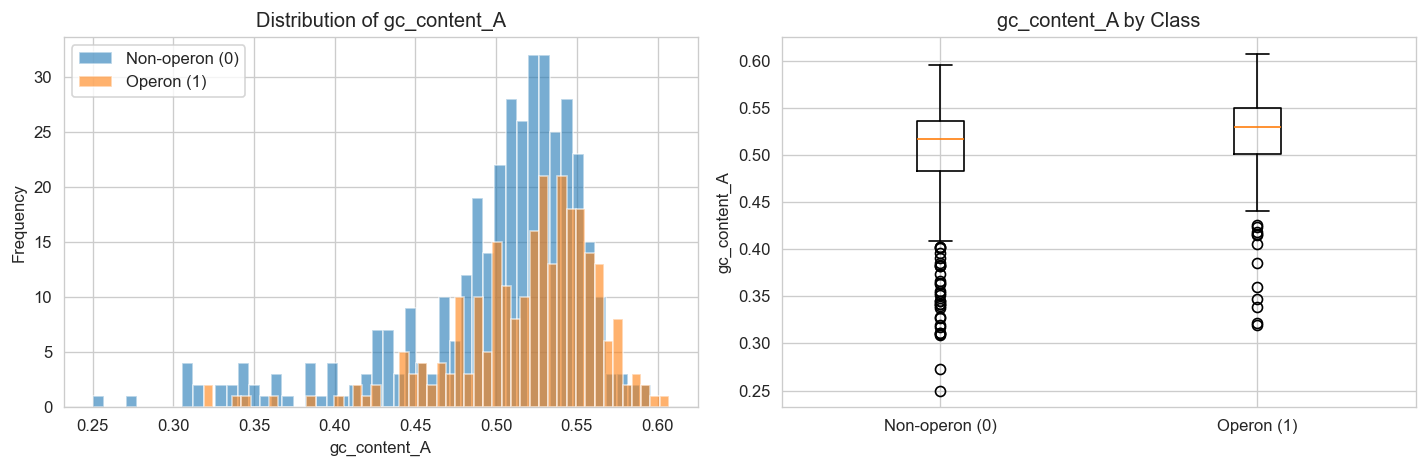


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 0.50
      Median: 0.52
      Std: 0.06

   Operon (Class 1):
      Mean: 0.52
      Median: 0.53
      Std: 0.05
📊 Feature Statistics for 'gc_content_B':
   Type: Continuous
count    645.000000
mean       0.505794
std        0.053742
min        0.245098
25%        0.487867
50%        0.519651
75%        0.540256
max        0.603430
Name: gc_content_B, dtype: float64
💾 Saved distribution plot to: graphs/gc_content_feature_ablation/gc_content_B_distribution.png


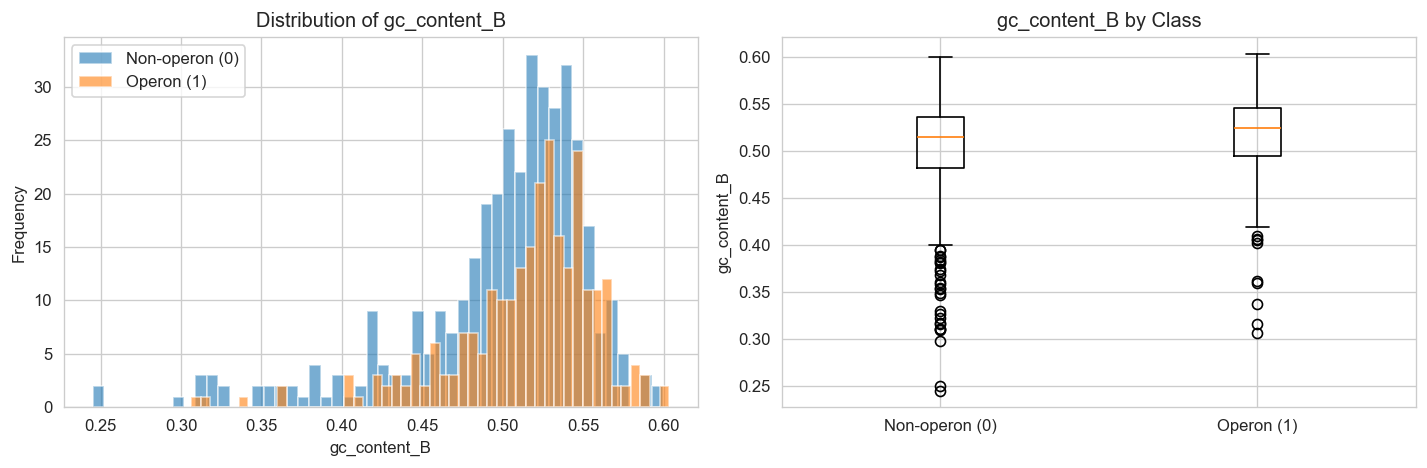


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 0.50
      Median: 0.51
      Std: 0.06

   Operon (Class 1):
      Mean: 0.51
      Median: 0.52
      Std: 0.05


In [135]:
# Examine GC content A and B features together
ablation_features_gc_ab = ["gc_content_A", "gc_content_B"]
ablation_feature_gc_ab_name = "gc_content_A_B"  # For file naming

# Plot distributions for both features
for feat in ablation_features_gc_ab:
    plot_feature_distribution(
        X_val, y_val, 
        feature_name=feat,
        class_labels={0: 'Non-operon', 1: 'Operon'},
        save_path=f"graphs/gc_content_feature_ablation/{feat}_distribution.png"
    )

In [136]:
# Run ablation study for gc_content_A and gc_content_B TOGETHER
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: {ablation_features_gc_ab} (COMBINED)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_gc_ab = {}
results_ablated_gc_ab = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_gc_ab[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method - ABLATING BOTH FEATURES TOGETHER
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (both gc_content_A & gc_content_B)...")
    for seed in seeds:
        X_val_ablated = ablate_features(X_val, ablation_features_gc_ab, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_gc_ab[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: ['gc_content_A', 'gc_content_B'] (COMBINED)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (both gc_content_A & gc_content_B)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (both gc_content_A & gc_content_B)...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [137]:
# Create summary DataFrames for gc_content_A & B combined
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_gc_ab = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_gc_ab[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_gc_ab[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_gc_ab[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_gc_ab[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for gc_content_A & gc_content_B (combined)")


✅ Summary DataFrames created for gc_content_A & gc_content_B (combined)



💾 Heatmap saved to: graphs/gc_content_feature_ablation/gc_content_A_B_ablation_heatmap_comparison.png


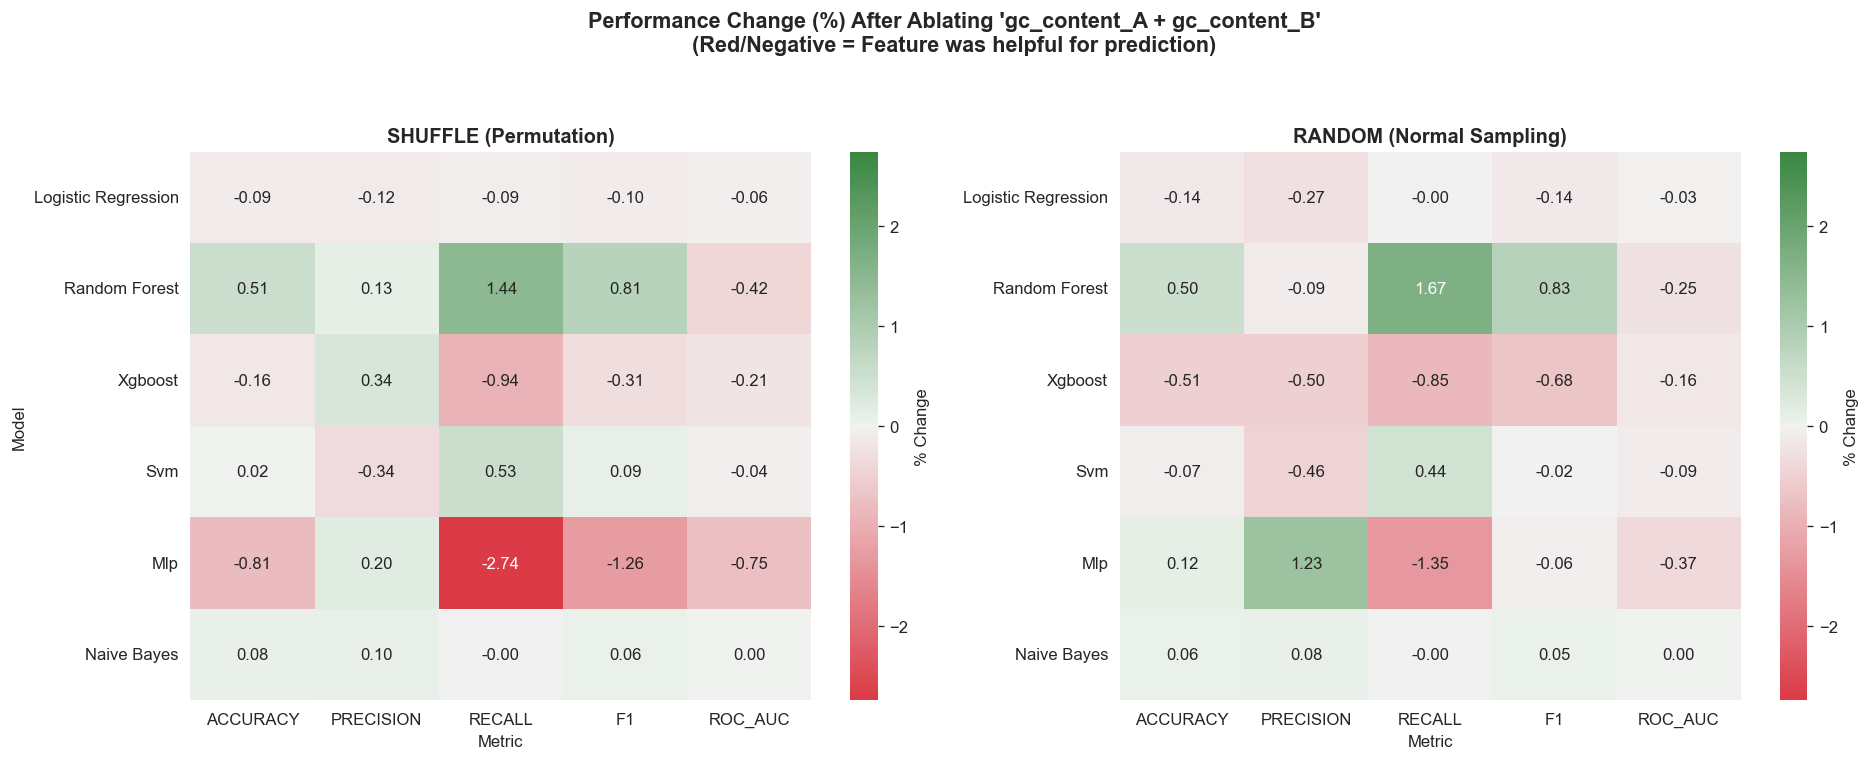

In [138]:
# Visualization: Heatmap for gc_content_A & B combined
plot_ablation_heatmap(
    summary_dfs_gc_ab, "gc_content_A + gc_content_B",
    model_names=list(models.keys()),
    save_path=f"graphs/gc_content_feature_ablation/{ablation_feature_gc_ab_name}_ablation_heatmap_comparison.png"
)


In [139]:
# Interpretation for gc_content_A & B combined
_ = summarize_ablation_compact(results_original_gc_ab, summary_dfs_gc_ab, "gc_content_A + gc_content_B", metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_gc_ab, summary_dfs_gc_ab, "gc_content_A + gc_content_B")



📊 Compact Comparison (ROC-AUC) for 'gc_content_A + gc_content_B':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9392,-0.0005,0.9395,-0.0003
1,Random Forest,0.9526,0.9485,-0.0040,0.9502,-0.0024
2,Xgboost,0.9548,0.9528,-0.0020,0.9532,-0.0016
3,Svm,0.9490,0.9486,-0.0004,0.9481,-0.0009
4,Mlp,0.9468,0.9397,-0.0071,0.9432,-0.0035
5,Naive Bayes,0.8275,0.8275,0.0000,0.8275,0.0000



🔍 INTERPRETATION: Logistic Regression — Feature: 'gc_content_A + gc_content_B'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8628±0.0036  (Δ=-0.0008 ≈, -0.09%)
   PRECISION   : 0.7930±0.0042  (Δ=-0.0009 ≈, -0.12%)
   RECALL      : 0.8962±0.0056  (Δ=-0.0008 ≈, -0.09%)
   F1          : 0.8414±0.0042  (Δ=-0.0009 ≈, -0.10%)
   ROC_AUC     : 0.9392±0.0012  (Δ=-0.0005 ≈, -0.06%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8623±0.0037  (Δ=-0.0012 ≈, -0.14%)
   PRECISION   : 0.7918±0.0037  (Δ=-0.0021 ≈, -0.27%)
   RECALL      : 0.8969±0.0066  (Δ=-0.0000 ≈, -0.00%)
   F1          : 0.8411±0.0045  (Δ=-0.0012 ≈, -0.14%)
   ROC_AUC     : 0.9395±0.0008  (Δ=-0.0003 ≈, -0.03%)

───────────────────────────────────────

In [140]:
# Save results for gc_content_A & B combined
for method in ablation_methods:
    output_path = Path(f"graphs/gc_content_feature_ablation/ablation_results_{ablation_feature_gc_ab_name}_{method}.csv")
    summary_dfs_gc_ab[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_gc_ab = pd.concat([summary_dfs_gc_ab['shuffle'], summary_dfs_gc_ab['random']], ignore_index=True)
combined_path = Path(f"graphs/gc_content_feature_ablation/ablation_results_{ablation_feature_gc_ab_name}_combined.csv")
combined_df_gc_ab.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/gc_content_feature_ablation/ablation_results_gc_content_A_B_shuffle.csv
💾 Saved random results → graphs/gc_content_feature_ablation/ablation_results_gc_content_A_B_random.csv
💾 Saved combined results → graphs/gc_content_feature_ablation/ablation_results_gc_content_A_B_combined.csv


# GC content A,B, diff

In [141]:
# Ablate all GC content features: A, B, and diff together
ablation_features_gc_all = ["gc_content_A", "gc_content_B", "gc_content_diff"]
ablation_feature_gc_all_name = "gc_content_all"  # For file naming

print(f"📊 Features to ablate: {ablation_features_gc_all}")


📊 Features to ablate: ['gc_content_A', 'gc_content_B', 'gc_content_diff']


In [142]:
# Run ablation study for all GC content features TOGETHER
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: {ablation_features_gc_all} (ALL COMBINED)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_gc_all = {}
results_ablated_gc_all = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_gc_all[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method - ABLATING ALL GC FEATURES TOGETHER
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (gc_content_A, gc_content_B, gc_content_diff)...")
    for seed in seeds:
        X_val_ablated = ablate_features(X_val, ablation_features_gc_all, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_gc_all[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: ['gc_content_A', 'gc_content_B', 'gc_content_diff'] (ALL COMBINED)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (gc_content_A, gc_content_B, gc_content_diff)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (gc_content_A, gc_content_B, gc_content_diff)...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [143]:
# Create summary DataFrames for all GC content features combined
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_gc_all = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_gc_all[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_gc_all[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_gc_all[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_gc_all[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for all GC content features (A, B, diff)")


✅ Summary DataFrames created for all GC content features (A, B, diff)



💾 Heatmap saved to: graphs/gc_content_feature_ablation/gc_content_all_ablation_heatmap_comparison.png


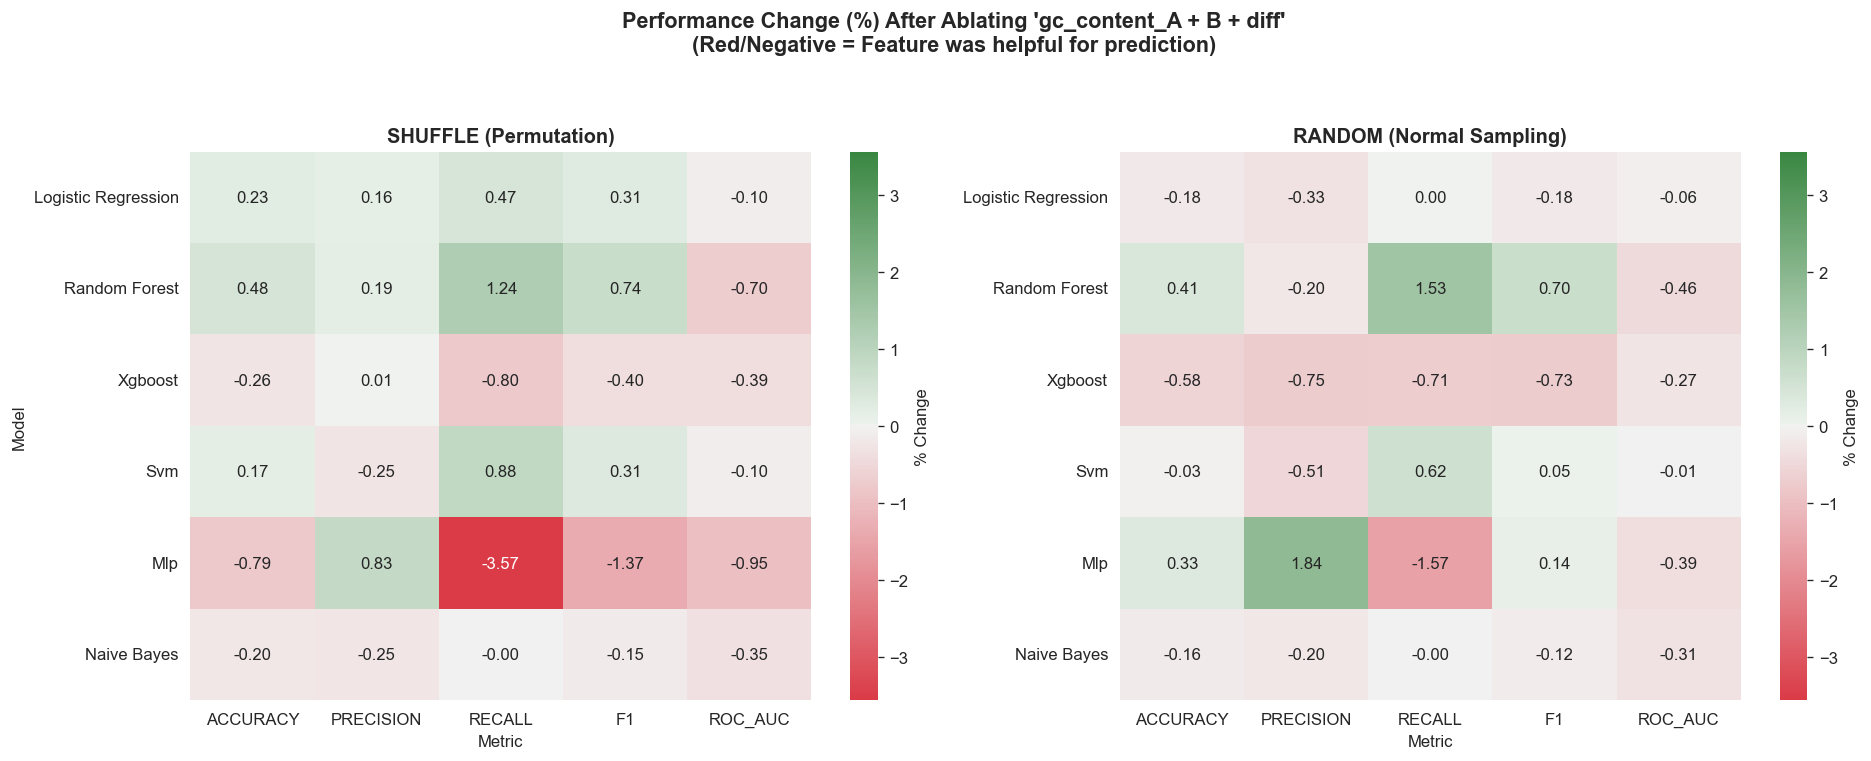

In [144]:
# Visualization: Heatmap for all GC content features combined
plot_ablation_heatmap(
    summary_dfs_gc_all, "gc_content_A + B + diff",
    model_names=list(models.keys()),
    save_path=f"graphs/gc_content_feature_ablation/{ablation_feature_gc_all_name}_ablation_heatmap_comparison.png"
)


In [145]:
# Interpretation for all GC content features combined
_ = summarize_ablation_compact(results_original_gc_all, summary_dfs_gc_all, "gc_content_A + B + diff", metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_gc_all, summary_dfs_gc_all, "gc_content_A + B + diff")



📊 Compact Comparison (ROC-AUC) for 'gc_content_A + B + diff':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9388,-0.0010,0.9391,-0.0006
1,Random Forest,0.9526,0.9459,-0.0067,0.9482,-0.0043
2,Xgboost,0.9548,0.9510,-0.0037,0.9522,-0.0026
3,Svm,0.9490,0.9481,-0.0009,0.9489,-0.0001
4,Mlp,0.9468,0.9378,-0.0090,0.9431,-0.0037
5,Naive Bayes,0.8275,0.8246,-0.0029,0.8249,-0.0026



🔍 INTERPRETATION: Logistic Regression — Feature: 'gc_content_A + B + diff'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8656±0.0026  (Δ=+0.0020 ≈, +0.23%)
   PRECISION   : 0.7952±0.0031  (Δ=+0.0013 ≈, +0.16%)
   RECALL      : 0.9011±0.0052  (Δ=+0.0042 ≈, +0.47%)
   F1          : 0.8449±0.0031  (Δ=+0.0026 ≈, +0.31%)
   ROC_AUC     : 0.9388±0.0012  (Δ=-0.0010 ≈, -0.10%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8620±0.0051  (Δ=-0.0016 ≈, -0.18%)
   PRECISION   : 0.7913±0.0066  (Δ=-0.0026 ≈, -0.33%)
   RECALL      : 0.8969±0.0080  (Δ=+0.0000 ≈, +0.00%)
   F1          : 0.8408±0.0059  (Δ=-0.0015 ≈, -0.18%)
   ROC_AUC     : 0.9391±0.0009  (Δ=-0.0006 ≈, -0.06%)

───────────────────────────────────────────

In [146]:
# Save results for all GC content features combined
for method in ablation_methods:
    output_path = Path(f"graphs/gc_content_feature_ablation/ablation_results_{ablation_feature_gc_all_name}_{method}.csv")
    summary_dfs_gc_all[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_gc_all = pd.concat([summary_dfs_gc_all['shuffle'], summary_dfs_gc_all['random']], ignore_index=True)
combined_path = Path(f"graphs/gc_content_feature_ablation/ablation_results_{ablation_feature_gc_all_name}_combined.csv")
combined_df_gc_all.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/gc_content_feature_ablation/ablation_results_gc_content_all_shuffle.csv
💾 Saved random results → graphs/gc_content_feature_ablation/ablation_results_gc_content_all_random.csv
💾 Saved combined results → graphs/gc_content_feature_ablation/ablation_results_gc_content_all_combined.csv


# Strand features

## strand concordance

📊 Feature Statistics for 'strand_concordant':
   Type: Binary
count    645.000000
mean       0.700775
std        0.458274
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: strand_concordant, dtype: float64
💾 Saved distribution plot to: graphs/strand_feature_ablation/strand_concordant_distribution.png


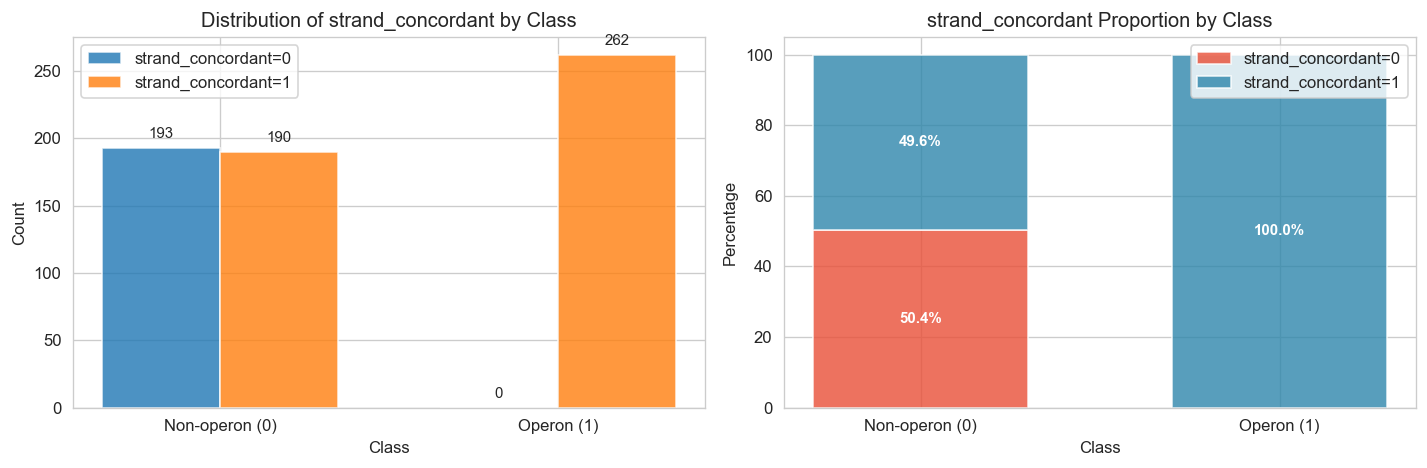


📈 Class-wise statistics (Binary Feature):

   Non-operon (Class 0):
      Total: 383
      strand_concordant=0: 193 (50.4%)
      strand_concordant=1: 190 (49.6%)

   Operon (Class 1):
      Total: 262
      strand_concordant=0: 0 (0.0%)
      strand_concordant=1: 262 (100.0%)


In [147]:
# Examine strand_concordant feature
ablation_feature_strand = "strand_concordant"

plot_feature_distribution(
    X_val, y_val,
    feature_name=ablation_feature_strand,
    class_labels={0: 'Non-operon', 1: 'Operon'},
    save_path="graphs/strand_feature_ablation/strand_concordant_distribution.png"
)


In [148]:
# Run ablation study for strand_concordant
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: '{ablation_feature_strand}'")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_strand = {}
results_ablated_strand = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_strand[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation...")
    for seed in seeds:
        X_val_ablated = ablate_feature(X_val, ablation_feature_strand, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_strand[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: 'strand_concordant'
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [149]:
# Create summary DataFrames for strand_concordant
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_strand = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_strand[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_strand[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_strand[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_strand[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for strand_concordant")


✅ Summary DataFrames created for strand_concordant



💾 Heatmap saved to: graphs/strand_feature_ablation/strand_concordant_ablation_heatmap_comparison.png


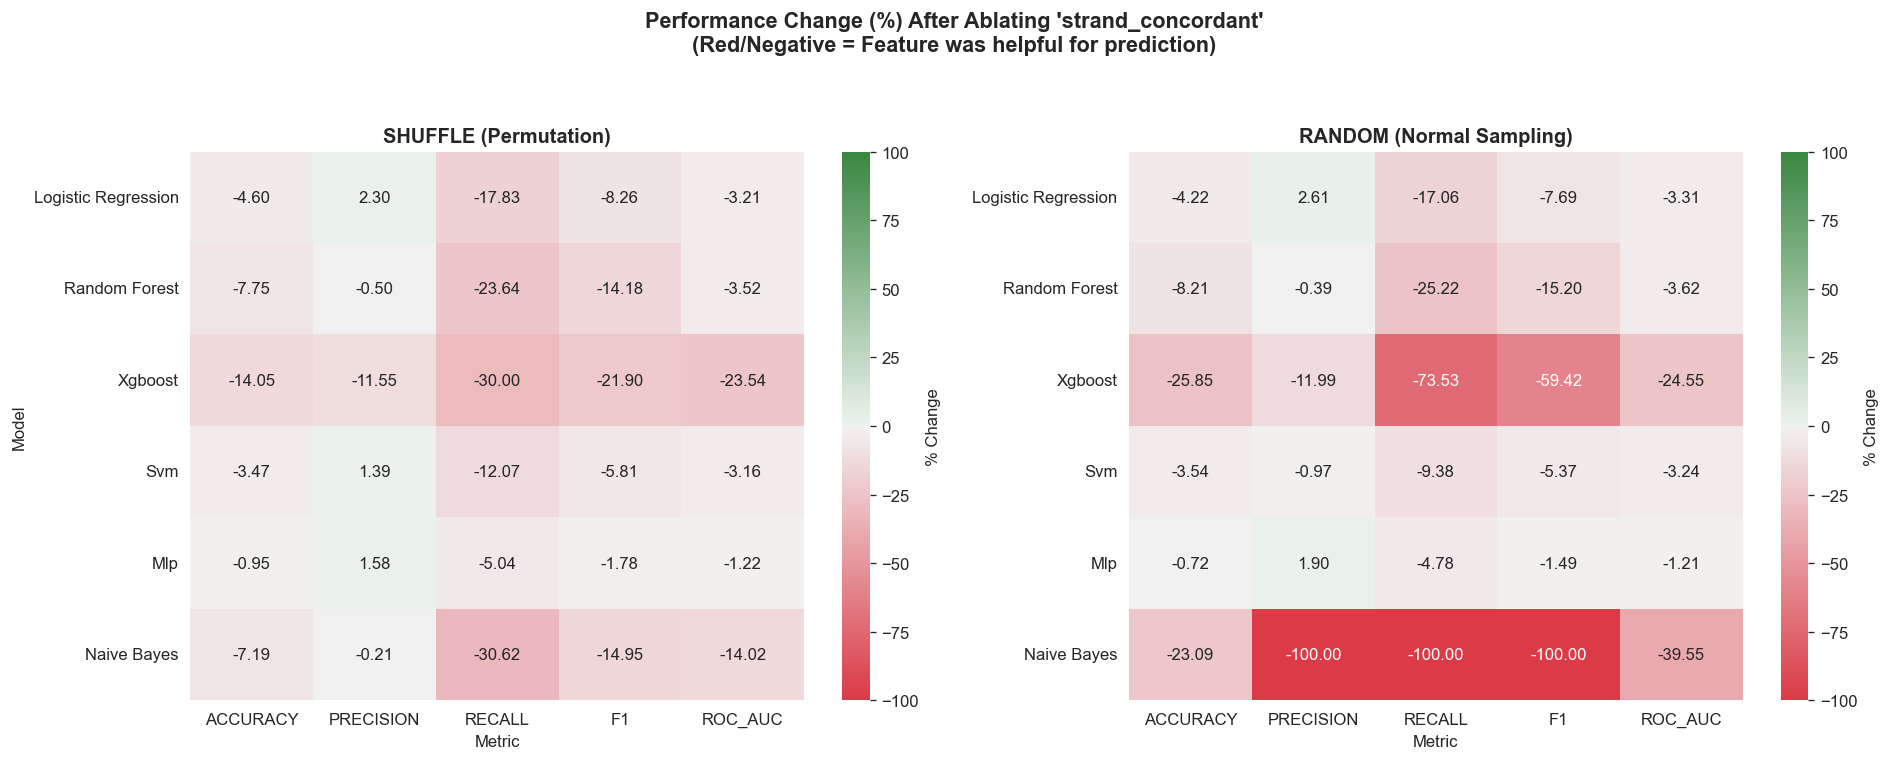

In [150]:
# Visualization: Heatmap for strand_concordant
plot_ablation_heatmap(
    summary_dfs_strand, ablation_feature_strand,
    model_names=list(models.keys()),
    save_path=f"graphs/strand_feature_ablation/{ablation_feature_strand}_ablation_heatmap_comparison.png"
)


In [151]:
# Interpretation for strand_concordant
_ = summarize_ablation_compact(results_original_strand, summary_dfs_strand, ablation_feature_strand, metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_strand, summary_dfs_strand, ablation_feature_strand)



📊 Compact Comparison (ROC-AUC) for 'strand_concordant':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9096,-0.0301,0.9086,-0.0311
1,Random Forest,0.9526,0.9190,-0.0335,0.9181,-0.0344
2,Xgboost,0.9548,0.7300,-0.2248,0.7204,-0.2344
3,Svm,0.9490,0.9190,-0.0300,0.9183,-0.0307
4,Mlp,0.9468,0.9352,-0.0116,0.9353,-0.0115
5,Naive Bayes,0.8275,0.7115,-0.1161,0.5003,-0.3273



🔍 INTERPRETATION: Logistic Regression — Feature: 'strand_concordant'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8239±0.0081  (Δ=-0.0397 ↓, -4.60%)
   PRECISION   : 0.8122±0.0134  (Δ=+0.0182 ↑, +2.30%)
   RECALL      : 0.7370±0.0096  (Δ=-0.1599 ↓, -17.83%)
   F1          : 0.7727±0.0099  (Δ=-0.0696 ↓, -8.26%)
   ROC_AUC     : 0.9096±0.0051  (Δ=-0.0301 ↓, -3.21%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8271±0.0061  (Δ=-0.0364 ↓, -4.22%)
   PRECISION   : 0.8147±0.0106  (Δ=+0.0208 ↑, +2.61%)
   RECALL      : 0.7439±0.0171  (Δ=-0.1531 ↓, -17.06%)
   F1          : 0.7775±0.0091  (Δ=-0.0648 ↓, -7.69%)
   ROC_AUC     : 0.9086±0.0038  (Δ=-0.0311 ↓, -3.31%)

───────────────────────────────────────────────

In [152]:
# Save results for strand_concordant
for method in ablation_methods:
    output_path = Path(f"graphs/strand_feature_ablation/ablation_results_{ablation_feature_strand}_{method}.csv")
    summary_dfs_strand[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_strand = pd.concat([summary_dfs_strand['shuffle'], summary_dfs_strand['random']], ignore_index=True)
combined_path = Path(f"graphs/strand_feature_ablation/ablation_results_{ablation_feature_strand}_combined.csv")
combined_df_strand.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/strand_feature_ablation/ablation_results_strand_concordant_shuffle.csv
💾 Saved random results → graphs/strand_feature_ablation/ablation_results_strand_concordant_random.csv
💾 Saved combined results → graphs/strand_feature_ablation/ablation_results_strand_concordant_combined.csv


# strand orientation

In [153]:
# Ablate all orientation features together
ablation_features_orientation = ["orientation_++", "orientation_--", "orientation_+-", "orientation_-+"]
ablation_feature_orientation_name = "orientation_all"  # For file naming

print(f"📊 Features to ablate: {ablation_features_orientation}")


📊 Features to ablate: ['orientation_++', 'orientation_--', 'orientation_+-', 'orientation_-+']


In [154]:
# Run ablation study for all orientation features TOGETHER
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: {ablation_features_orientation} (ALL COMBINED)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_orientation = {}
results_ablated_orientation = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_orientation[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method - ABLATING ALL ORIENTATION FEATURES TOGETHER
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (all 4 orientation features)...")
    for seed in seeds:
        X_val_ablated = ablate_features(X_val, ablation_features_orientation, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_orientation[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: ['orientation_++', 'orientation_--', 'orientation_+-', 'orientation_-+'] (ALL COMBINED)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (all 4 orientation features)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (all 4 orientation features)...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [155]:
# Create summary DataFrames for all orientation features combined
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_orientation = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_orientation[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_orientation[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_orientation[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_orientation[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for all orientation features")


✅ Summary DataFrames created for all orientation features



💾 Heatmap saved to: graphs/strand_feature_ablation/orientation_all_ablation_heatmap_comparison.png


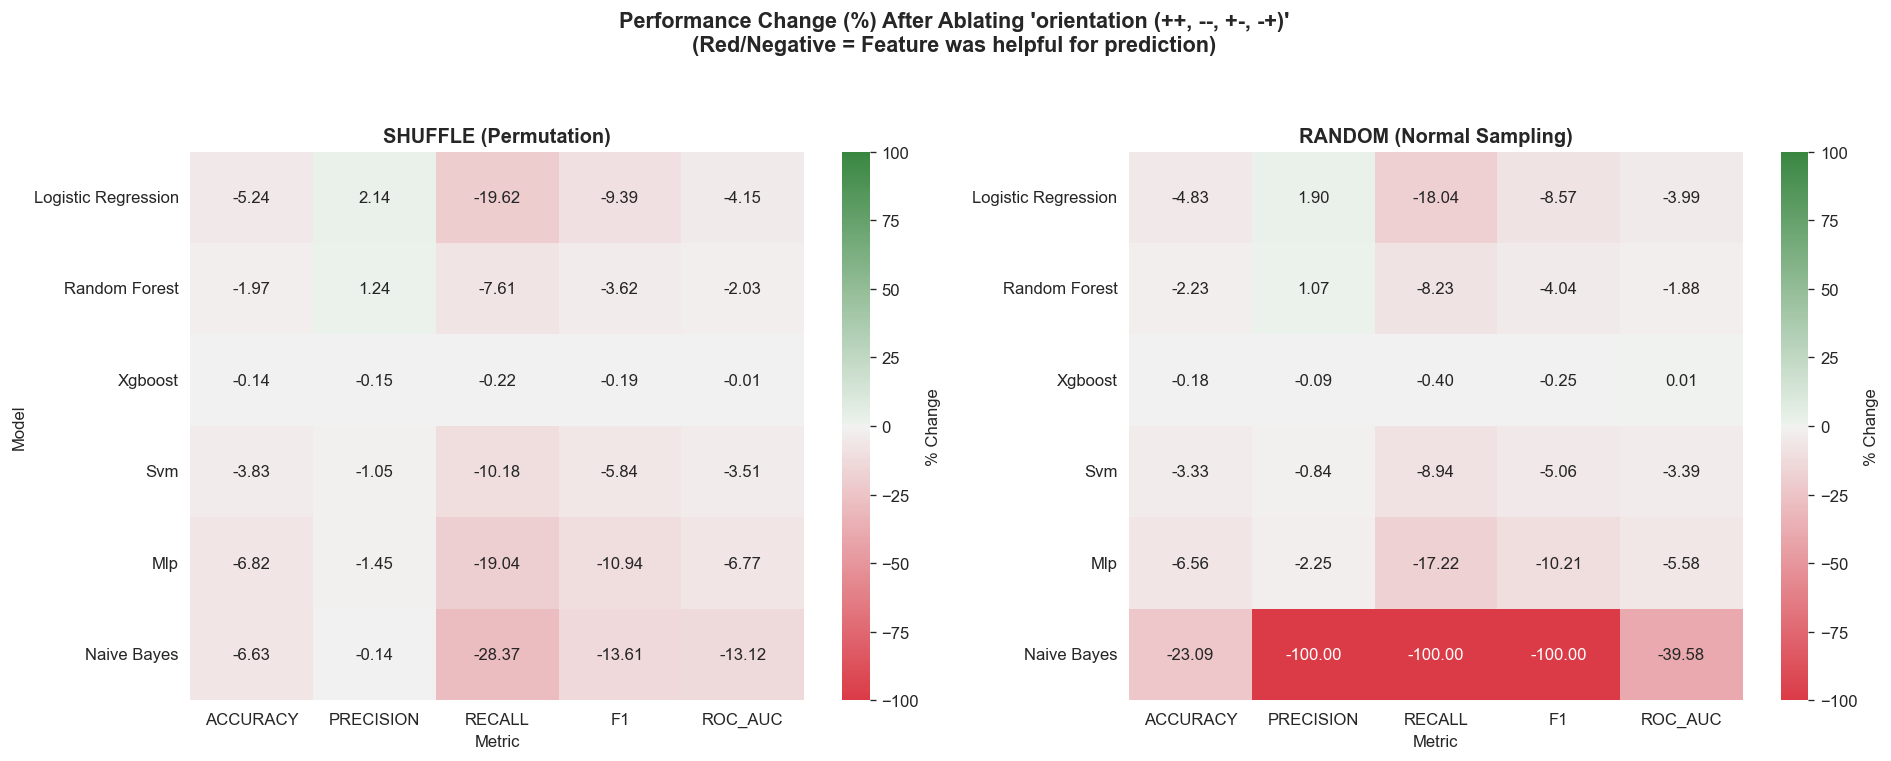

In [156]:
# Visualization: Heatmap for all orientation features combined
plot_ablation_heatmap(
    summary_dfs_orientation, "orientation (++, --, +-, -+)",
    model_names=list(models.keys()),
    save_path=f"graphs/strand_feature_ablation/{ablation_feature_orientation_name}_ablation_heatmap_comparison.png"
)


In [157]:
# Interpretation for all orientation features combined
_ = summarize_ablation_compact(results_original_orientation, summary_dfs_orientation, "orientation (++, --, +-, -+)", metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_orientation, summary_dfs_orientation, "orientation (++, --, +-, -+)")



📊 Compact Comparison (ROC-AUC) for 'orientation (++, --, +-, -+)':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9007,-0.0390,0.9022,-0.0375
1,Random Forest,0.9526,0.9332,-0.0194,0.9347,-0.0179
2,Xgboost,0.9548,0.9547,-0.0001,0.9549,0.0001
3,Svm,0.9490,0.9157,-0.0333,0.9169,-0.0321
4,Mlp,0.9468,0.8827,-0.0641,0.8939,-0.0528
5,Naive Bayes,0.8275,0.7189,-0.1086,0.5000,-0.3275



🔍 INTERPRETATION: Logistic Regression — Feature: 'orientation (++, --, +-, -+)'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8183±0.0098  (Δ=-0.0453 ↓, -5.24%)
   PRECISION   : 0.8109±0.0157  (Δ=+0.0170 ↑, +2.14%)
   RECALL      : 0.7210±0.0161  (Δ=-0.1760 ↓, -19.62%)
   F1          : 0.7632±0.0128  (Δ=-0.0791 ↓, -9.39%)
   ROC_AUC     : 0.9007±0.0047  (Δ=-0.0390 ↓, -4.15%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8219±0.0098  (Δ=-0.0417 ↓, -4.83%)
   PRECISION   : 0.8090±0.0130  (Δ=+0.0151 ↑, +1.90%)
   RECALL      : 0.7351±0.0224  (Δ=-0.1618 ↓, -18.04%)
   F1          : 0.7701±0.0145  (Δ=-0.0722 ↓, -8.57%)
   ROC_AUC     : 0.9022±0.0064  (Δ=-0.0375 ↓, -3.99%)

────────────────────────────────────

In [158]:
# Save results for all orientation features combined
for method in ablation_methods:
    output_path = Path(f"graphs/strand_feature_ablation/ablation_results_{ablation_feature_orientation_name}_{method}.csv")
    summary_dfs_orientation[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_orientation = pd.concat([summary_dfs_orientation['shuffle'], summary_dfs_orientation['random']], ignore_index=True)
combined_path = Path(f"graphs/strand_feature_ablation/ablation_results_{ablation_feature_orientation_name}_combined.csv")
combined_df_orientation.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/strand_feature_ablation/ablation_results_orientation_all_shuffle.csv
💾 Saved random results → graphs/strand_feature_ablation/ablation_results_orientation_all_random.csv
💾 Saved combined results → graphs/strand_feature_ablation/ablation_results_orientation_all_combined.csv


## strand concordance + orientation

In [159]:
# Ablate strand_concordant + all orientation features together
ablation_features_strand_all = ["strand_concordant", "orientation_++", "orientation_--", "orientation_+-", "orientation_-+"]
ablation_feature_strand_all_name = "strand_all"  # For file naming

print(f"📊 Features to ablate: {ablation_features_strand_all}")


📊 Features to ablate: ['strand_concordant', 'orientation_++', 'orientation_--', 'orientation_+-', 'orientation_-+']


In [160]:
# Run ablation study for all strand features TOGETHER
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: {ablation_features_strand_all} (ALL COMBINED)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_strand_all = {}
results_ablated_strand_all = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_strand_all[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method - ABLATING ALL STRAND FEATURES TOGETHER
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (strand_concordant + all orientations)...")
    for seed in seeds:
        X_val_ablated = ablate_features(X_val, ablation_features_strand_all, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_strand_all[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: ['strand_concordant', 'orientation_++', 'orientation_--', 'orientation_+-', 'orientation_-+'] (ALL COMBINED)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (strand_concordant + all orientations)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (strand_concordant + all orientations)...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [161]:
# Create summary DataFrames for all strand features combined
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_strand_all = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_strand_all[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_strand_all[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_strand_all[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_strand_all[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for all strand features")


✅ Summary DataFrames created for all strand features



💾 Heatmap saved to: graphs/strand_feature_ablation/strand_all_ablation_heatmap_comparison.png


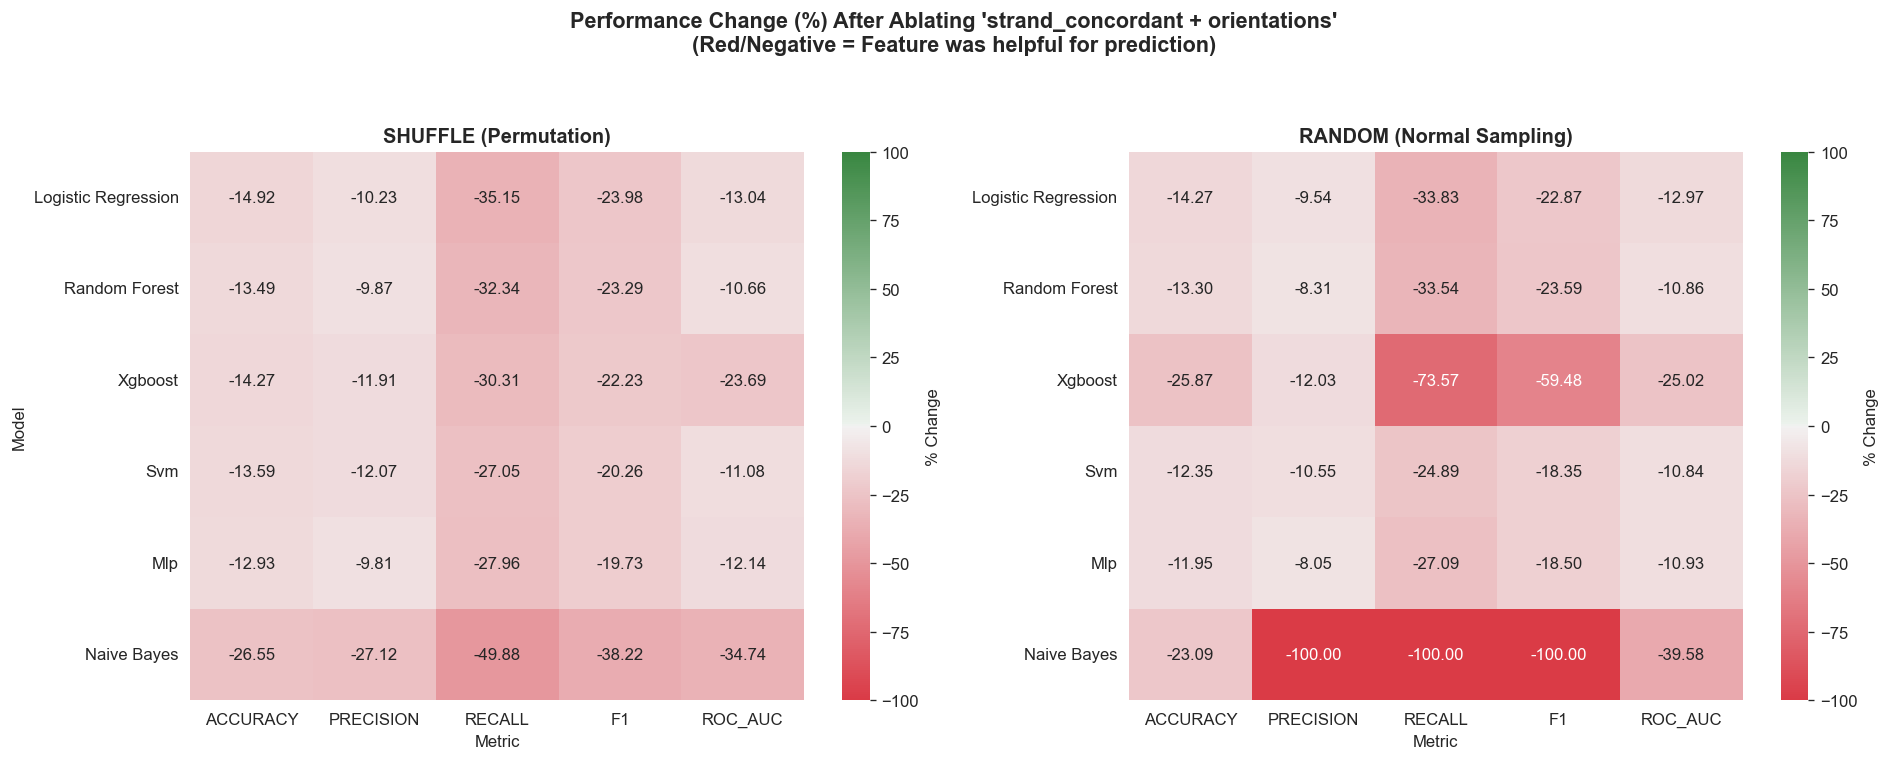

In [162]:
# Visualization: Heatmap for all strand features combined
plot_ablation_heatmap(
    summary_dfs_strand_all, "strand_concordant + orientations",
    model_names=list(models.keys()),
    save_path=f"graphs/strand_feature_ablation/{ablation_feature_strand_all_name}_ablation_heatmap_comparison.png"
)


In [163]:
# Interpretation for all strand features combined
_ = summarize_ablation_compact(results_original_strand_all, summary_dfs_strand_all, "strand_concordant + orientations", metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_strand_all, summary_dfs_strand_all, "strand_concordant + orientations")



📊 Compact Comparison (ROC-AUC) for 'strand_concordant + orientations':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.8172,-0.1225,0.8179,-0.1219
1,Random Forest,0.9526,0.8510,-0.1016,0.8491,-0.1035
2,Xgboost,0.9548,0.7286,-0.2262,0.7159,-0.2389
3,Svm,0.9490,0.8439,-0.1051,0.8461,-0.1029
4,Mlp,0.9468,0.8318,-0.1149,0.8433,-0.1035
5,Naive Bayes,0.8275,0.5400,-0.2875,0.5000,-0.3275



🔍 INTERPRETATION: Logistic Regression — Feature: 'strand_concordant + orientations'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.7347±0.0094  (Δ=-0.1288 ↓, -14.92%)
   PRECISION   : 0.7127±0.0150  (Δ=-0.0813 ↓, -10.23%)
   RECALL      : 0.5817±0.0201  (Δ=-0.3153 ↓, -35.15%)
   F1          : 0.6403±0.0151  (Δ=-0.2020 ↓, -23.98%)
   ROC_AUC     : 0.8172±0.0081  (Δ=-0.1225 ↓, -13.04%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.7403±0.0148  (Δ=-0.1233 ↓, -14.27%)
   PRECISION   : 0.7182±0.0195  (Δ=-0.0757 ↓, -9.54%)
   RECALL      : 0.5935±0.0302  (Δ=-0.3034 ↓, -33.83%)
   F1          : 0.6496±0.0240  (Δ=-0.1926 ↓, -22.87%)
   ROC_AUC     : 0.8179±0.0083  (Δ=-0.1219 ↓, -12.97%)

─────────────────────────

In [164]:
# Save results for all strand features combined
for method in ablation_methods:
    output_path = Path(f"graphs/strand_feature_ablation/ablation_results_{ablation_feature_strand_all_name}_{method}.csv")
    summary_dfs_strand_all[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_strand_all = pd.concat([summary_dfs_strand_all['shuffle'], summary_dfs_strand_all['random']], ignore_index=True)
combined_path = Path(f"graphs/strand_feature_ablation/ablation_results_{ablation_feature_strand_all_name}_combined.csv")
combined_df_strand_all.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/strand_feature_ablation/ablation_results_strand_all_shuffle.csv
💾 Saved random results → graphs/strand_feature_ablation/ablation_results_strand_all_random.csv
💾 Saved combined results → graphs/strand_feature_ablation/ablation_results_strand_all_combined.csv


# COG features

## COG match

📊 Feature Statistics for 'COG_match':
   Type: Binary
count    645.000000
mean       0.237209
std        0.425702
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: COG_match, dtype: float64
💾 Saved distribution plot to: graphs/cog_feature_ablation/COG_match_distribution.png


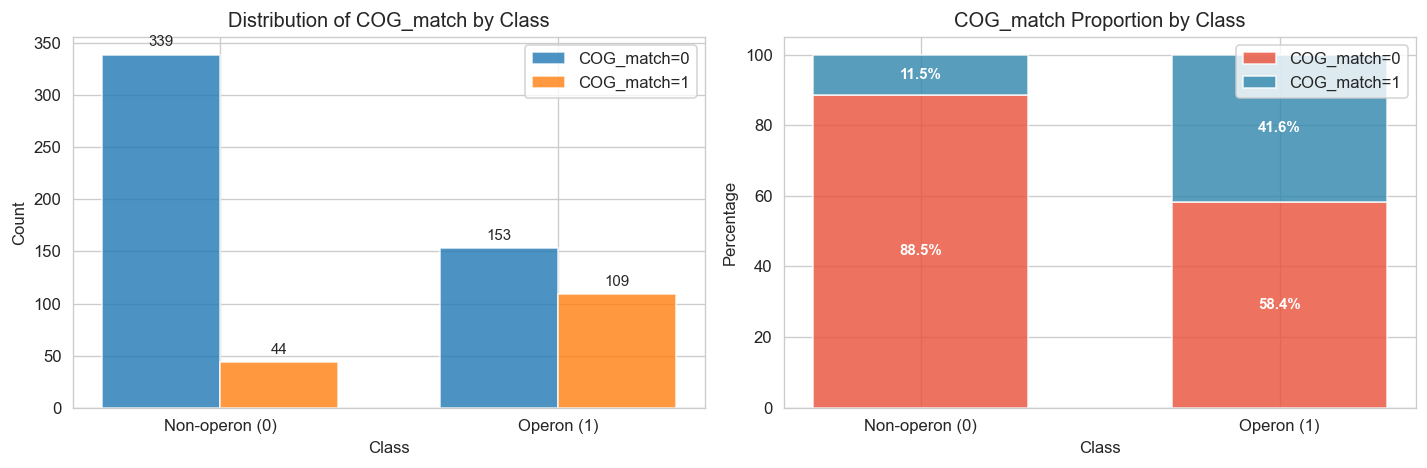


📈 Class-wise statistics (Binary Feature):

   Non-operon (Class 0):
      Total: 383
      COG_match=0: 339 (88.5%)
      COG_match=1: 44 (11.5%)

   Operon (Class 1):
      Total: 262
      COG_match=0: 153 (58.4%)
      COG_match=1: 109 (41.6%)


In [165]:
# Examine the COG_match feature
ablation_feature_cog = "COG_match"

plot_feature_distribution(
    X_val, y_val, 
    feature_name=ablation_feature_cog,
    class_labels={0: 'Non-operon', 1: 'Operon'},
    save_path="graphs/cog_feature_ablation/COG_match_distribution.png"
)


In [166]:
# Run ablation study for COG_match
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: '{ablation_feature_cog}'")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_cog = {}
results_ablated_cog = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_cog[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation...")
    for seed in seeds:
        X_val_ablated = ablate_feature(X_val, ablation_feature_cog, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_cog[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: 'COG_match'
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [167]:
# Create summary DataFrames for COG_match
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_cog = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_cog[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_cog[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_cog[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_cog[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for COG_match")


✅ Summary DataFrames created for COG_match



💾 Heatmap saved to: graphs/cog_feature_ablation/COG_match_ablation_heatmap_comparison.png


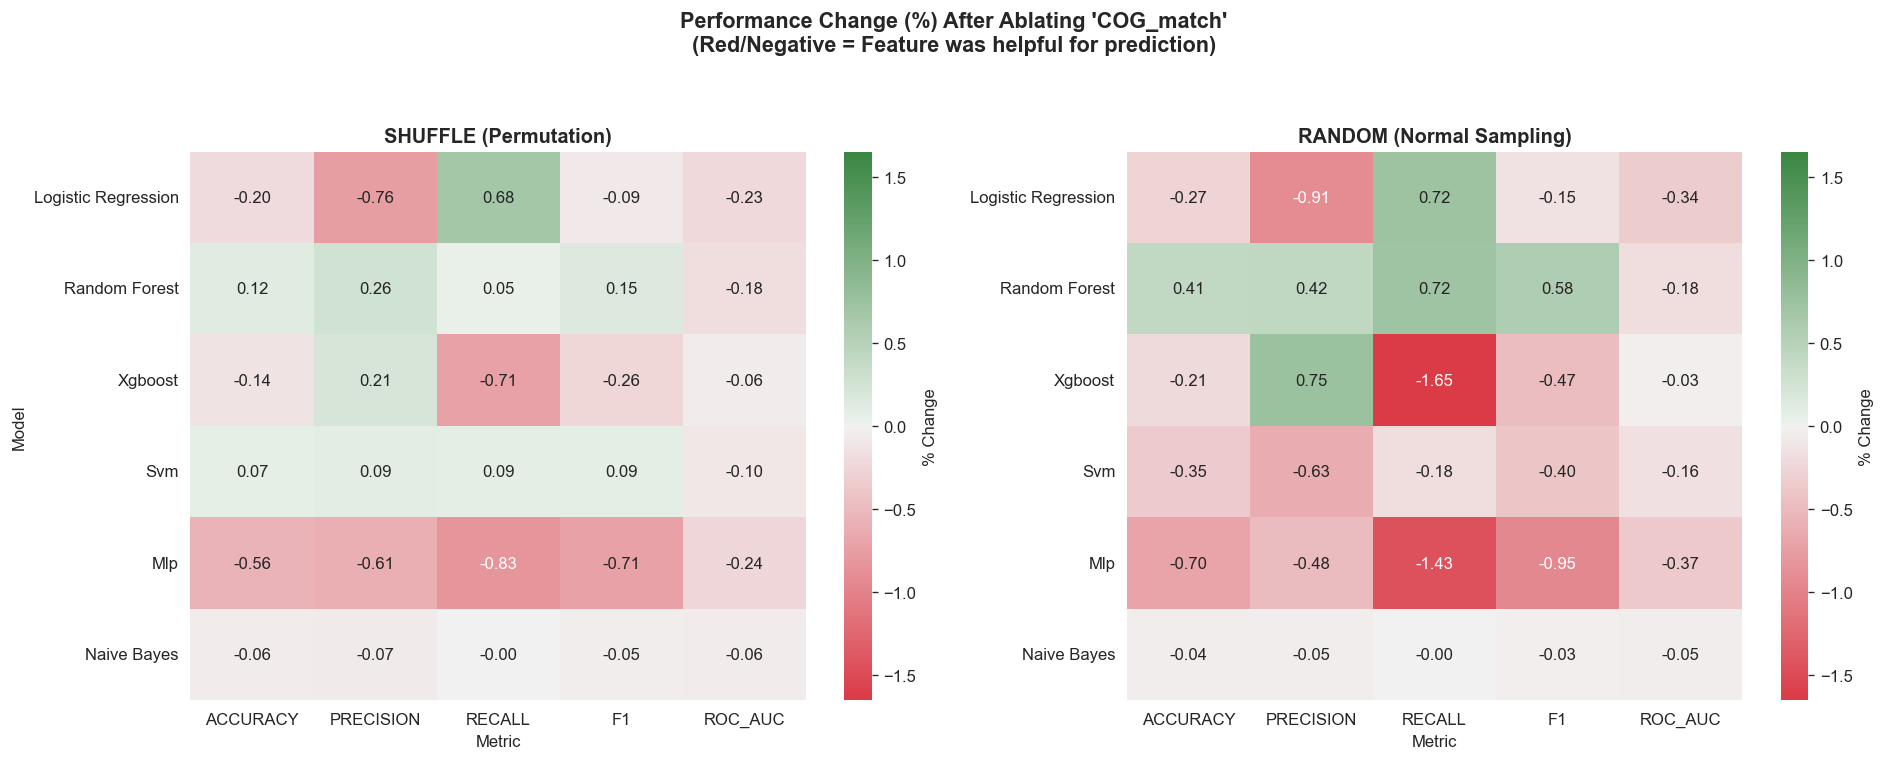

In [168]:
# Visualization: Heatmap for COG_match
plot_ablation_heatmap(
    summary_dfs_cog, ablation_feature_cog,
    model_names=list(models.keys()),
    save_path=f"graphs/cog_feature_ablation/{ablation_feature_cog}_ablation_heatmap_comparison.png"
)


In [169]:
# Interpretation for COG_match
_ = summarize_ablation_compact(results_original_cog, summary_dfs_cog, ablation_feature_cog, metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_cog, summary_dfs_cog, ablation_feature_cog)



📊 Compact Comparison (ROC-AUC) for 'COG_match':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9376,-0.0022,0.9365,-0.0032
1,Random Forest,0.9526,0.9509,-0.0017,0.9509,-0.0017
2,Xgboost,0.9548,0.9542,-0.0006,0.9545,-0.0003
3,Svm,0.9490,0.9481,-0.0009,0.9474,-0.0016
4,Mlp,0.9468,0.9445,-0.0023,0.9433,-0.0035
5,Naive Bayes,0.8275,0.8270,-0.0005,0.8271,-0.0004



🔍 INTERPRETATION: Logistic Regression — Feature: 'COG_match'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8619±0.0041  (Δ=-0.0017 ≈, -0.20%)
   PRECISION   : 0.7879±0.0056  (Δ=-0.0060 ↓, -0.76%)
   RECALL      : 0.9031±0.0062  (Δ=+0.0061 ↑, +0.68%)
   F1          : 0.8415±0.0045  (Δ=-0.0007 ≈, -0.09%)
   ROC_AUC     : 0.9376±0.0022  (Δ=-0.0022 ≈, -0.23%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8612±0.0037  (Δ=-0.0023 ≈, -0.27%)
   PRECISION   : 0.7867±0.0046  (Δ=-0.0073 ↓, -0.91%)
   RECALL      : 0.9034±0.0062  (Δ=+0.0065 ↑, +0.72%)
   F1          : 0.8410±0.0043  (Δ=-0.0013 ≈, -0.15%)
   ROC_AUC     : 0.9365±0.0012  (Δ=-0.0032 ≈, -0.34%)

─────────────────────────────────────────────────────────

In [170]:
# Save results for COG_match
for method in ablation_methods:
    output_path = Path(f"graphs/cog_feature_ablation/ablation_results_{ablation_feature_cog}_{method}.csv")
    summary_dfs_cog[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_cog = pd.concat([summary_dfs_cog['shuffle'], summary_dfs_cog['random']], ignore_index=True)
combined_path = Path(f"graphs/cog_feature_ablation/ablation_results_{ablation_feature_cog}_combined.csv")
combined_df_cog.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/cog_feature_ablation/ablation_results_COG_match_shuffle.csv
💾 Saved random results → graphs/cog_feature_ablation/ablation_results_COG_match_random.csv
💾 Saved combined results → graphs/cog_feature_ablation/ablation_results_COG_match_combined.csv


## COG similar


📊 Feature Statistics for 'COG_similar':
   Type: Binary
count    645.000000
mean       0.401550
std        0.490592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: COG_similar, dtype: float64
💾 Saved distribution plot to: graphs/cog_feature_ablation/COG_similar_distribution.png


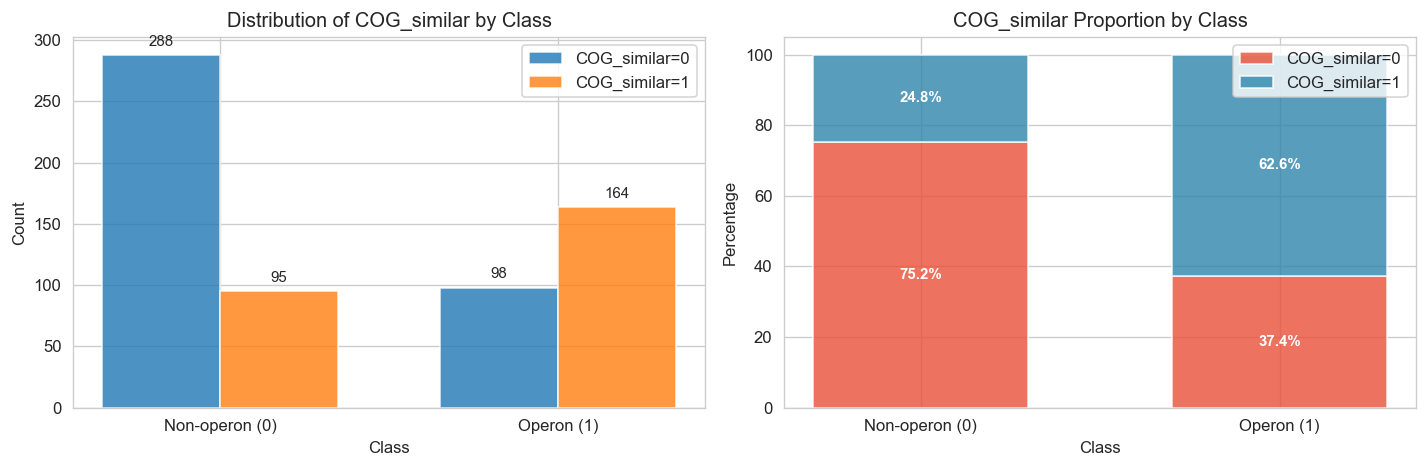


📈 Class-wise statistics (Binary Feature):

   Non-operon (Class 0):
      Total: 383
      COG_similar=0: 288 (75.2%)
      COG_similar=1: 95 (24.8%)

   Operon (Class 1):
      Total: 262
      COG_similar=0: 98 (37.4%)
      COG_similar=1: 164 (62.6%)


In [171]:
# Examine the COG_similar feature
ablation_feature_cog_similar = "COG_similar"

plot_feature_distribution(
    X_val, y_val, 
    feature_name=ablation_feature_cog_similar,
    class_labels={0: 'Non-operon', 1: 'Operon'},
    save_path="graphs/cog_feature_ablation/COG_similar_distribution.png"
)


In [172]:
# Run ablation study for COG_similar
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: '{ablation_feature_cog_similar}'")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_cog_similar = {}
results_ablated_cog_similar = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_cog_similar[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation...")
    for seed in seeds:
        X_val_ablated = ablate_feature(X_val, ablation_feature_cog_similar, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_cog_similar[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: 'COG_similar'
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [173]:
# Create summary DataFrames for COG_similar
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_cog_similar = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_cog_similar[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_cog_similar[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_cog_similar[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_cog_similar[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for COG_similar")


✅ Summary DataFrames created for COG_similar



💾 Heatmap saved to: graphs/cog_feature_ablation/COG_similar_ablation_heatmap_comparison.png


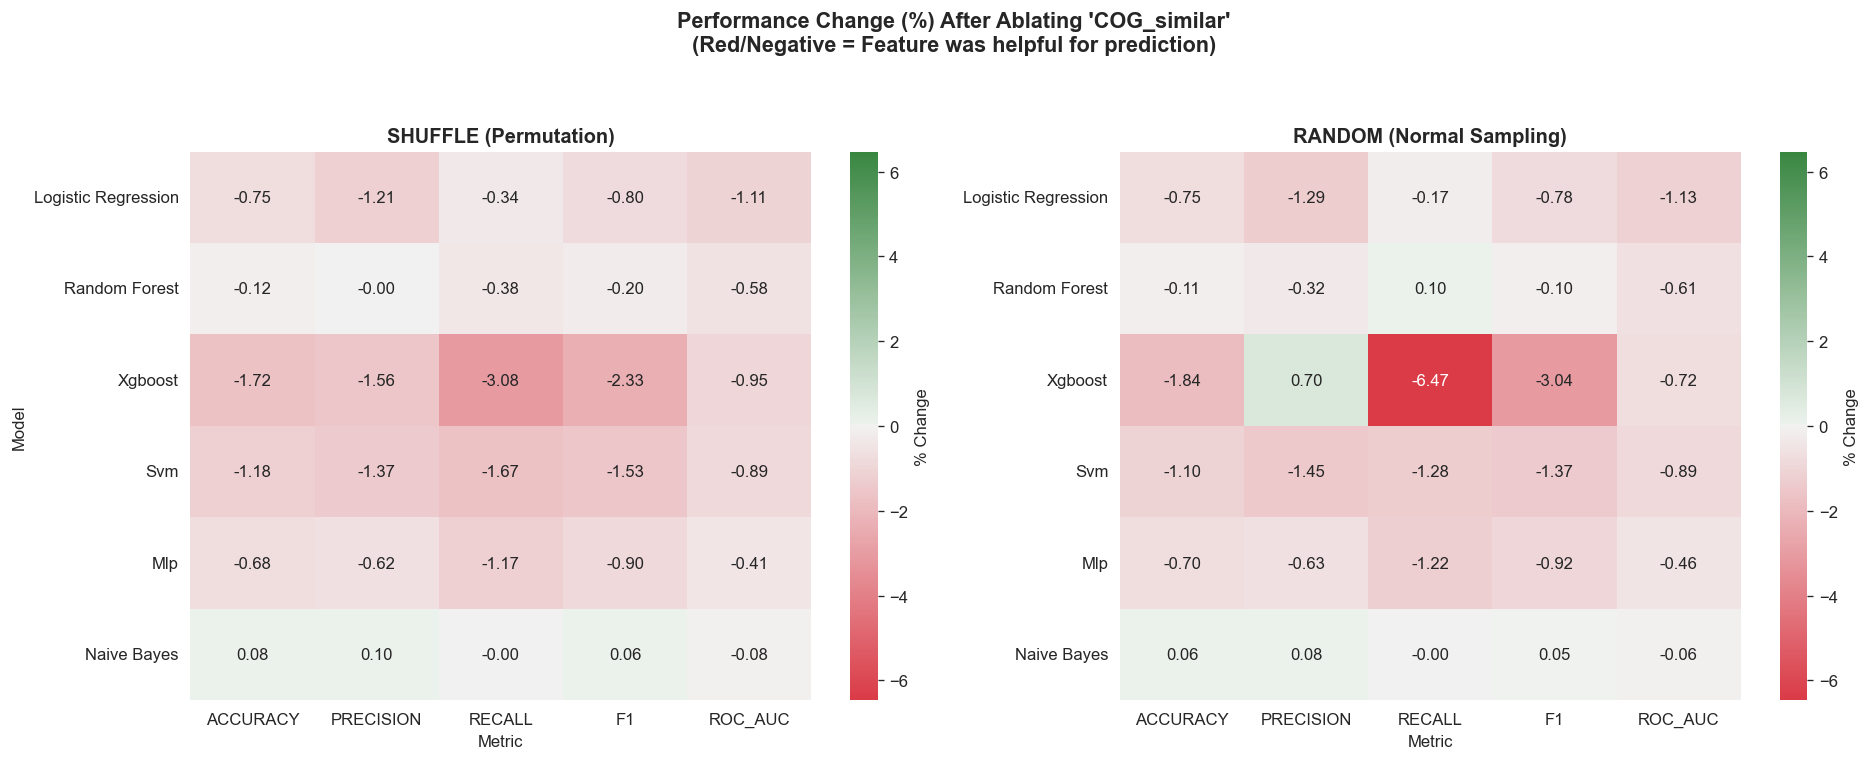

In [174]:
# Visualization: Heatmap for COG_similar
plot_ablation_heatmap(
    summary_dfs_cog_similar, ablation_feature_cog_similar,
    model_names=list(models.keys()),
    save_path=f"graphs/cog_feature_ablation/{ablation_feature_cog_similar}_ablation_heatmap_comparison.png"
)


In [175]:
# Interpretation for COG_similar
_ = summarize_ablation_compact(results_original_cog_similar, summary_dfs_cog_similar, ablation_feature_cog_similar, metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_cog_similar, summary_dfs_cog_similar, ablation_feature_cog_similar)



📊 Compact Comparison (ROC-AUC) for 'COG_similar':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9293,-0.0104,0.9291,-0.0106
1,Random Forest,0.9526,0.9471,-0.0055,0.9467,-0.0059
2,Xgboost,0.9548,0.9457,-0.0091,0.9479,-0.0069
3,Svm,0.9490,0.9405,-0.0085,0.9405,-0.0085
4,Mlp,0.9468,0.9429,-0.0038,0.9424,-0.0044
5,Naive Bayes,0.8275,0.8269,-0.0006,0.8270,-0.0005



🔍 INTERPRETATION: Logistic Regression — Feature: 'COG_similar'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8571±0.0049  (Δ=-0.0065 ↓, -0.75%)
   PRECISION   : 0.7843±0.0055  (Δ=-0.0096 ↓, -1.21%)
   RECALL      : 0.8939±0.0104  (Δ=-0.0031 ≈, -0.34%)
   F1          : 0.8355±0.0061  (Δ=-0.0068 ↓, -0.80%)
   ROC_AUC     : 0.9293±0.0041  (Δ=-0.0104 ↓, -1.11%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8571±0.0052  (Δ=-0.0065 ↓, -0.75%)
   PRECISION   : 0.7836±0.0074  (Δ=-0.0103 ↓, -1.29%)
   RECALL      : 0.8954±0.0108  (Δ=-0.0015 ≈, -0.17%)
   F1          : 0.8358±0.0061  (Δ=-0.0065 ↓, -0.78%)
   ROC_AUC     : 0.9291±0.0018  (Δ=-0.0106 ↓, -1.13%)

───────────────────────────────────────────────────────

In [176]:
# Save results for COG_similar
for method in ablation_methods:
    output_path = Path(f"graphs/cog_feature_ablation/ablation_results_{ablation_feature_cog_similar}_{method}.csv")
    summary_dfs_cog_similar[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_cog_similar = pd.concat([summary_dfs_cog_similar['shuffle'], summary_dfs_cog_similar['random']], ignore_index=True)
combined_path = Path(f"graphs/cog_feature_ablation/ablation_results_{ablation_feature_cog_similar}_combined.csv")
combined_df_cog_similar.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/cog_feature_ablation/ablation_results_COG_similar_shuffle.csv
💾 Saved random results → graphs/cog_feature_ablation/ablation_results_COG_similar_random.csv
💾 Saved combined results → graphs/cog_feature_ablation/ablation_results_COG_similar_combined.csv


## COG features combined (COG_match + COG_similar)


In [177]:
# Ablate COG_match + COG_similar together
ablation_features_cog_all = ["COG_match", "COG_similar"]
ablation_feature_cog_all_name = "COG_all"  # For file naming

print(f"📊 Features to ablate: {ablation_features_cog_all}")


📊 Features to ablate: ['COG_match', 'COG_similar']


In [178]:
# Run ablation study for all COG features TOGETHER
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: {ablation_features_cog_all} (ALL COMBINED)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_cog_all = {}
results_ablated_cog_all = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_cog_all[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method - ABLATING ALL COG FEATURES TOGETHER
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (all COG features)...")
    for seed in seeds:
        X_val_ablated = ablate_features(X_val, ablation_features_cog_all, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_cog_all[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: ['COG_match', 'COG_similar'] (ALL COMBINED)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (all COG features)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (all COG features)...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [179]:
# Create summary DataFrames for all COG features combined
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_cog_all = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_cog_all[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_cog_all[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_cog_all[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_cog_all[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for all COG features")


✅ Summary DataFrames created for all COG features



💾 Heatmap saved to: graphs/cog_feature_ablation/COG_all_ablation_heatmap_comparison.png


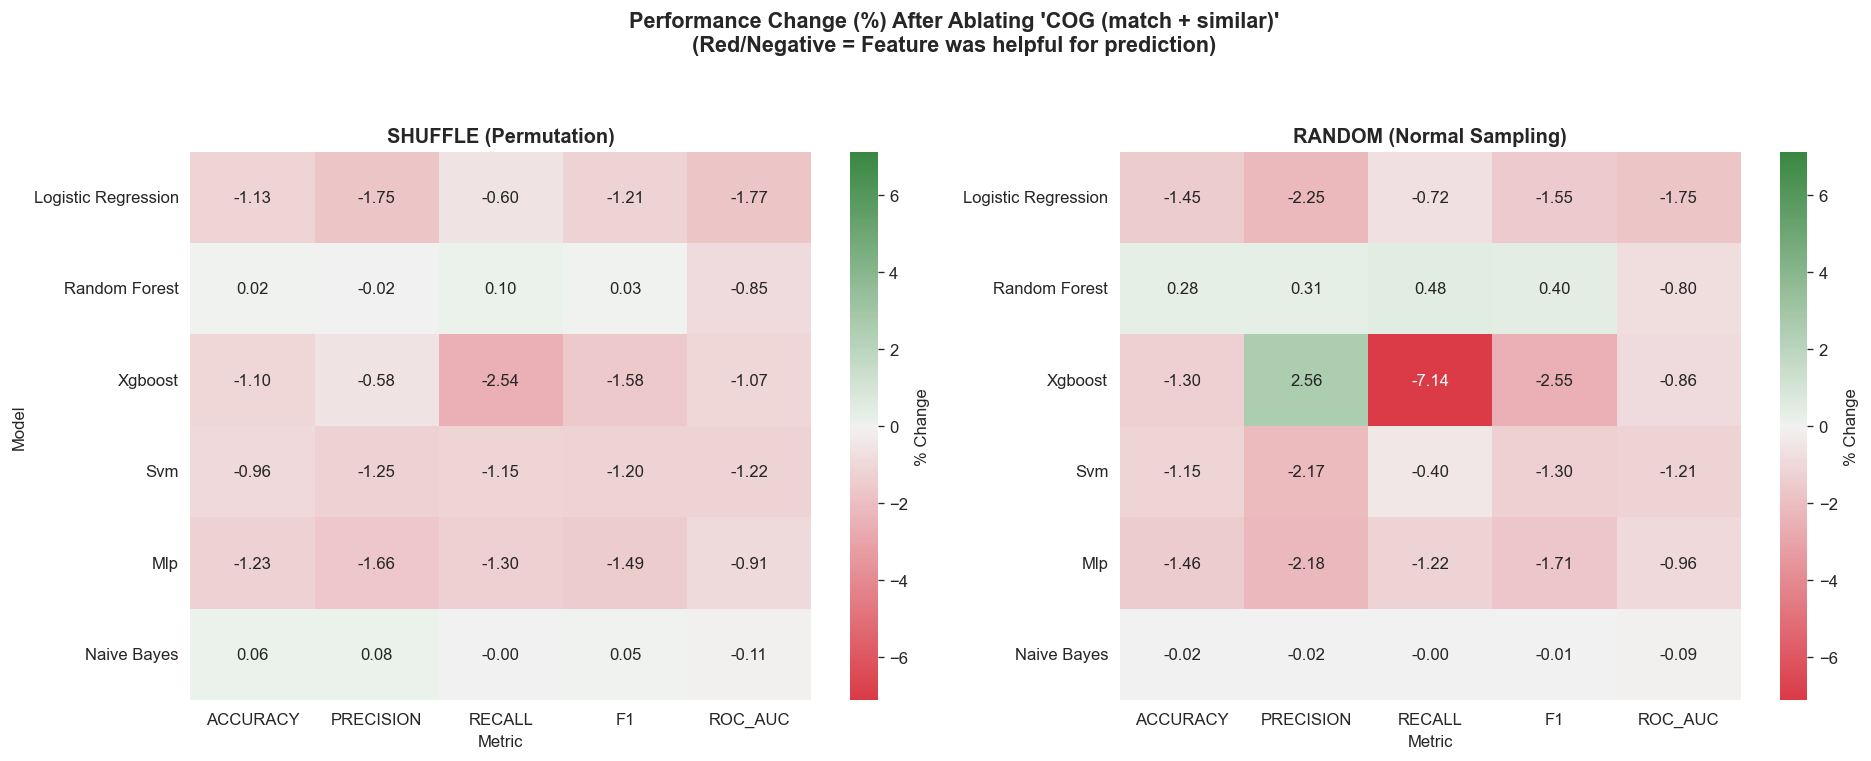

In [180]:
# Visualization: Heatmap for all COG features combined
plot_ablation_heatmap(
    summary_dfs_cog_all, "COG (match + similar)",
    model_names=list(models.keys()),
    save_path=f"graphs/cog_feature_ablation/{ablation_feature_cog_all_name}_ablation_heatmap_comparison.png"
)


In [181]:
# Interpretation for all COG features combined
_ = summarize_ablation_compact(results_original_cog_all, summary_dfs_cog_all, "COG (match + similar)", metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_cog_all, summary_dfs_cog_all, "COG (match + similar)")



📊 Compact Comparison (ROC-AUC) for 'COG (match + similar)':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.9231,-0.0166,0.9233,-0.0164
1,Random Forest,0.9526,0.9445,-0.0081,0.9449,-0.0077
2,Xgboost,0.9548,0.9446,-0.0102,0.9466,-0.0082
3,Svm,0.9490,0.9374,-0.0116,0.9375,-0.0115
4,Mlp,0.9468,0.9382,-0.0086,0.9377,-0.0091
5,Naive Bayes,0.8275,0.8266,-0.0009,0.8267,-0.0008



🔍 INTERPRETATION: Logistic Regression — Feature: 'COG (match + similar)'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8538±0.0076  (Δ=-0.0098 ↓, -1.13%)
   PRECISION   : 0.7800±0.0097  (Δ=-0.0139 ↓, -1.75%)
   RECALL      : 0.8916±0.0095  (Δ=-0.0053 ↓, -0.60%)
   F1          : 0.8321±0.0084  (Δ=-0.0102 ↓, -1.21%)
   ROC_AUC     : 0.9231±0.0031  (Δ=-0.0166 ↓, -1.77%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.8510±0.0059  (Δ=-0.0126 ↓, -1.45%)
   PRECISION   : 0.7760±0.0101  (Δ=-0.0179 ↓, -2.25%)
   RECALL      : 0.8905±0.0139  (Δ=-0.0065 ↓, -0.72%)
   F1          : 0.8292±0.0065  (Δ=-0.0131 ↓, -1.55%)
   ROC_AUC     : 0.9233±0.0030  (Δ=-0.0164 ↓, -1.75%)

─────────────────────────────────────────────

In [182]:
# Save results for all COG features combined
for method in ablation_methods:
    output_path = Path(f"graphs/cog_feature_ablation/ablation_results_{ablation_feature_cog_all_name}_{method}.csv")
    summary_dfs_cog_all[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_cog_all = pd.concat([summary_dfs_cog_all['shuffle'], summary_dfs_cog_all['random']], ignore_index=True)
combined_path = Path(f"graphs/cog_feature_ablation/ablation_results_{ablation_feature_cog_all_name}_combined.csv")
combined_df_cog_all.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/cog_feature_ablation/ablation_results_COG_all_shuffle.csv
💾 Saved random results → graphs/cog_feature_ablation/ablation_results_COG_all_random.csv
💾 Saved combined results → graphs/cog_feature_ablation/ablation_results_COG_all_combined.csv


# Trinucleotide Features

In [183]:
# Get all trinucleotide feature columns
trinuc_features = [col for col in feature_cols if col.startswith('trinuc_')]
ablation_feature_trinuc_name = "trinuc_all"  # For file naming

print(f"📊 Trinucleotide Features ({len(trinuc_features)} total):")
print(f"   {trinuc_features[:5]} ... {trinuc_features[-5:]}")

# Create output directory if it doesn't exist
Path("graphs/trinuc_feature_ablation").mkdir(parents=True, exist_ok=True)


📊 Trinucleotide Features (64 total):
   ['trinuc_AAA', 'trinuc_AAC', 'trinuc_AAG', 'trinuc_AAT', 'trinuc_ACA'] ... ['trinuc_TGT', 'trinuc_TTA', 'trinuc_TTC', 'trinuc_TTG', 'trinuc_TTT']


📊 Feature Statistics for 'trinuc_AAA':
   Type: Continuous
count    645.000000
mean       5.582946
std       11.985940
min        0.000000
25%        0.000000
50%        2.000000
75%        7.000000
max      138.000000
Name: trinuc_AAA, dtype: float64
💾 Saved distribution plot to: graphs/trinuc_feature_ablation/trinuc_AAA_distribution.png


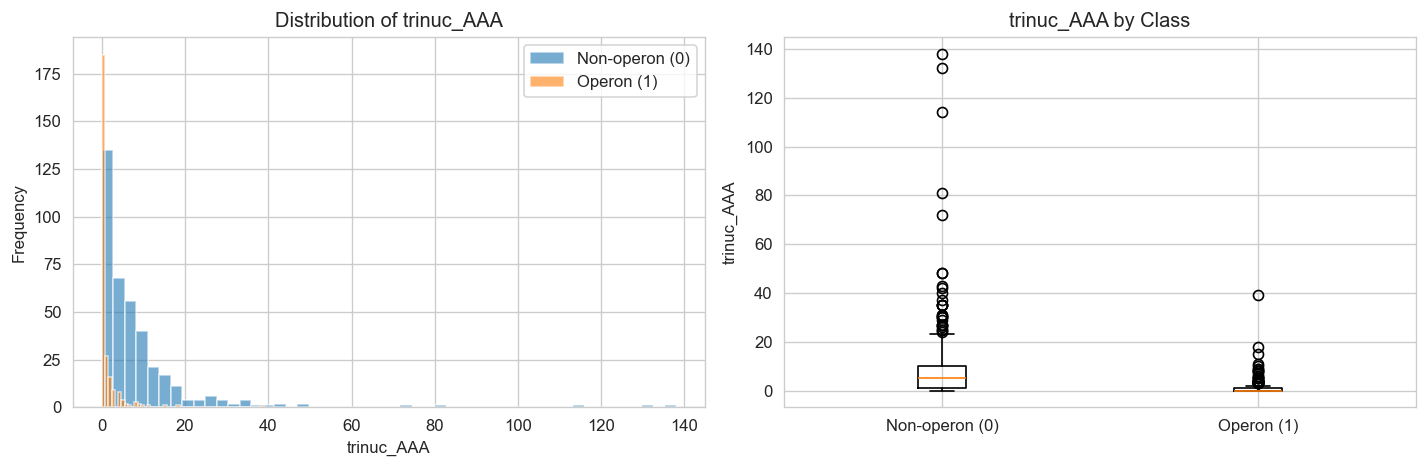


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 8.64
      Median: 5.00
      Std: 14.55

   Operon (Class 1):
      Mean: 1.11
      Median: 0.00
      Std: 3.30
📊 Feature Statistics for 'trinuc_AAC':
   Type: Continuous
count    645.000000
mean       2.815504
std        7.185977
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max      117.000000
Name: trinuc_AAC, dtype: float64
💾 Saved distribution plot to: graphs/trinuc_feature_ablation/trinuc_AAC_distribution.png


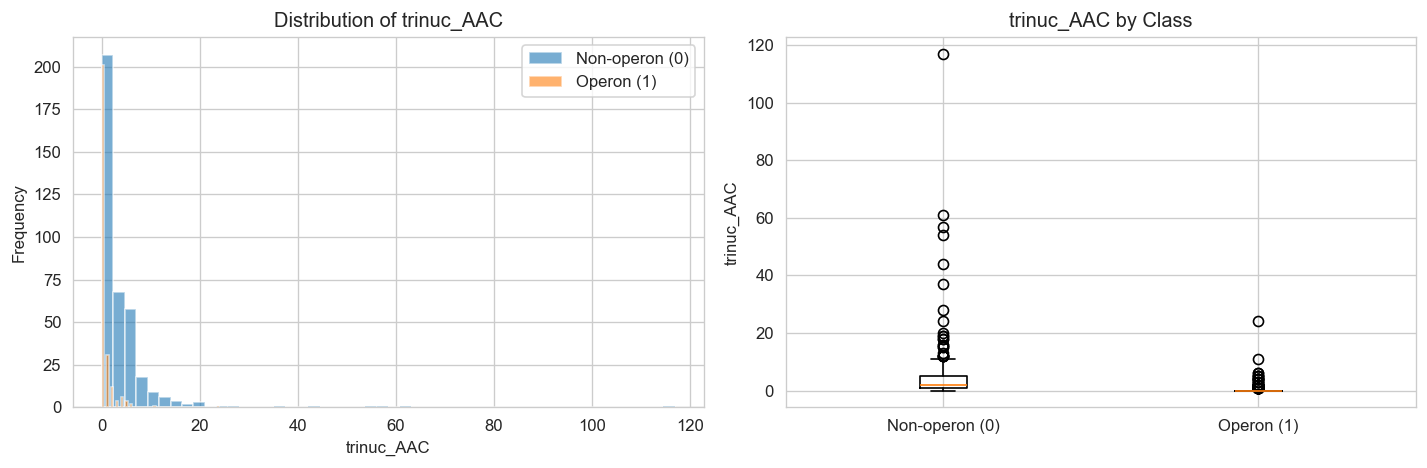


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 4.33
      Median: 2.00
      Std: 8.88

   Operon (Class 1):
      Mean: 0.60
      Median: 0.00
      Std: 1.94
📊 Feature Statistics for 'trinuc_AAG':
   Type: Continuous
count    645.000000
mean       2.675969
std        7.395995
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max      152.000000
Name: trinuc_AAG, dtype: float64
💾 Saved distribution plot to: graphs/trinuc_feature_ablation/trinuc_AAG_distribution.png


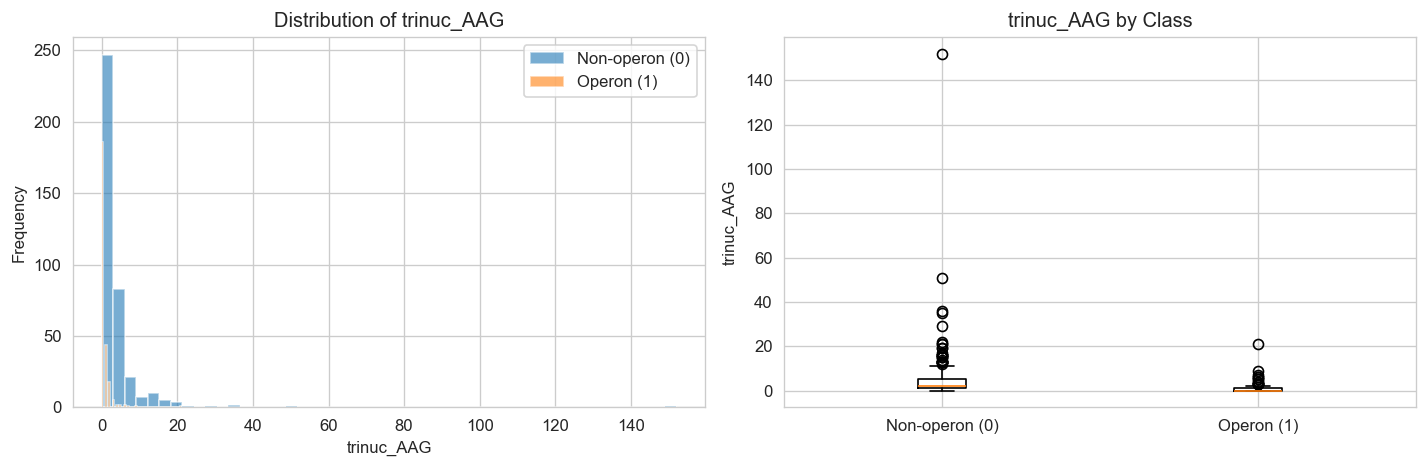


📈 Class-wise statistics:

   Non-operon (Class 0):
      Mean: 4.08
      Median: 2.00
      Std: 9.23

   Operon (Class 1):
      Mean: 0.62
      Median: 0.00
      Std: 1.74


In [184]:
# Plot distributions for a few representative trinucleotide features
# Show first 3 as examples
for feat in trinuc_features[:3]:
    plot_feature_distribution(
        X_val, y_val, 
        feature_name=feat,
        class_labels={0: 'Non-operon', 1: 'Operon'},
        save_path=f"graphs/trinuc_feature_ablation/{feat}_distribution.png"
    )


In [185]:
# Run ablation study for ALL trinucleotide features TOGETHER
n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: All {len(trinuc_features)} Trinucleotide Features (COMBINED)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_trinuc = {}
results_ablated_trinuc = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_trinuc[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method - ABLATING ALL TRINUC FEATURES TOGETHER
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (all {len(trinuc_features)} trinucleotide features)...")
    for seed in seeds:
        X_val_ablated = ablate_features(X_val, trinuc_features, method=method, random_state=seed, X_train=X_train)
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_trinuc[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ Ablation study complete!")


🔬 Ablation Study: All 64 Trinucleotide Features (COMBINED)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (all 64 trinucleotide features)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (all 64 trinucleotide features)...
   ✓ Completed 10 runs with 'random' method

✅ Ablation study complete!


In [186]:
# Create summary DataFrames for all trinucleotide features combined
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_trinuc = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        # Original metrics
        for metric in metrics:
            row[f'{metric}_original'] = results_original_trinuc[model_name][metric]
        
        # Ablated metrics (mean and std across seeds)
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_trinuc[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            # Calculate impact (delta and % change)
            original_val = results_original_trinuc[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_trinuc[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for all trinucleotide features")


✅ Summary DataFrames created for all trinucleotide features



💾 Heatmap saved to: graphs/trinuc_feature_ablation/trinuc_all_ablation_heatmap_comparison.png


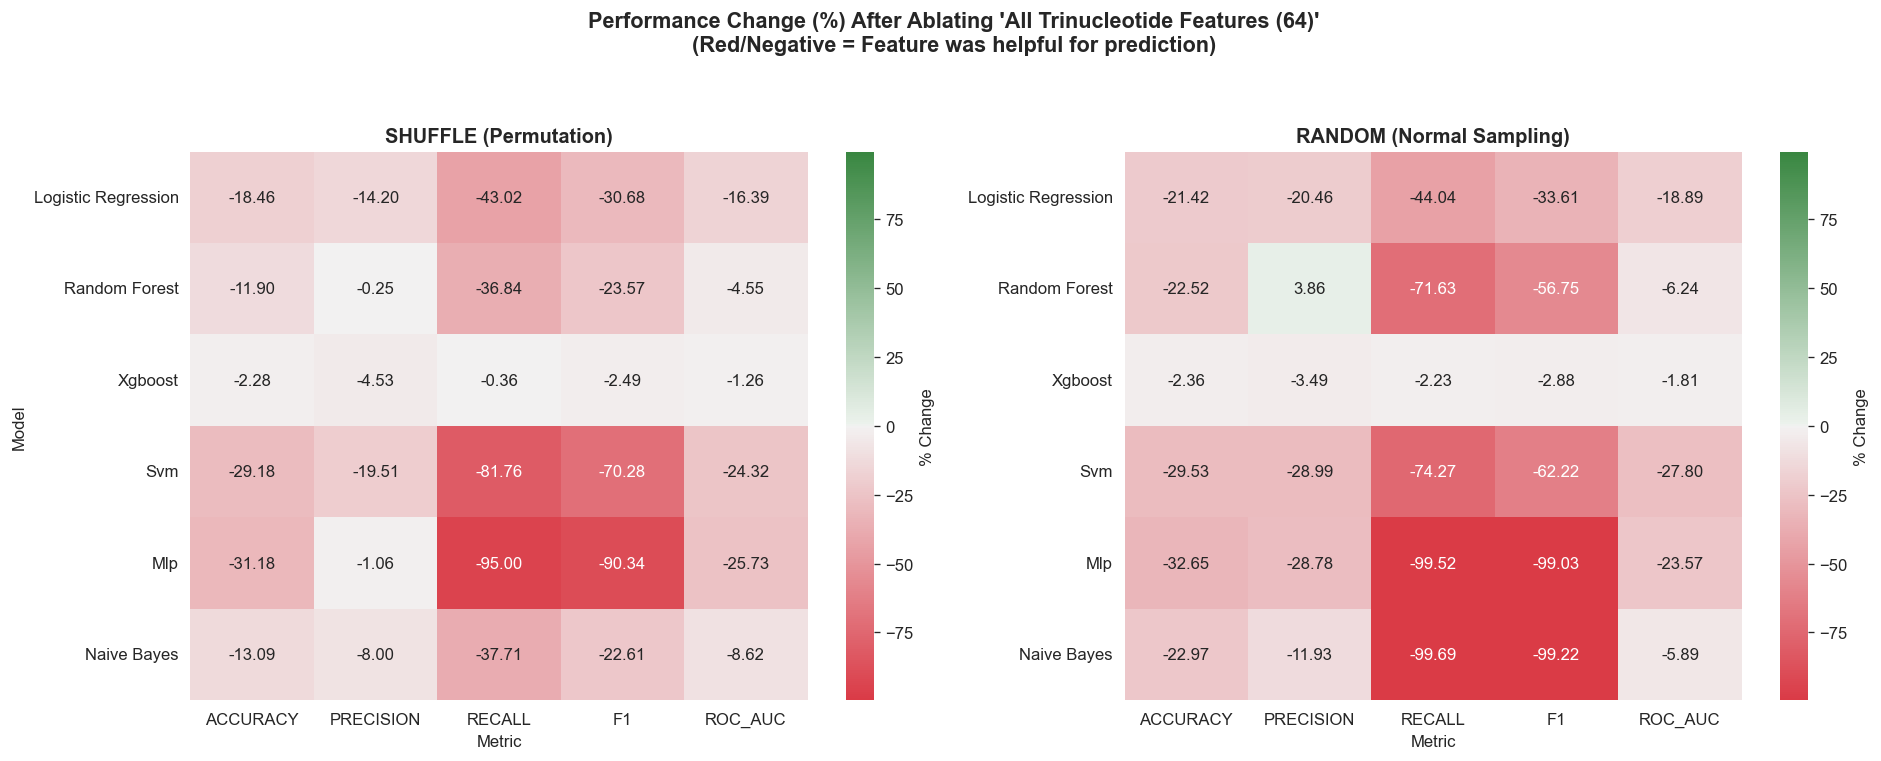

In [187]:
# Visualization: Heatmap for all trinucleotide features combined
plot_ablation_heatmap(
    summary_dfs_trinuc, f"All Trinucleotide Features ({len(trinuc_features)})",
    model_names=list(models.keys()),
    save_path=f"graphs/trinuc_feature_ablation/{ablation_feature_trinuc_name}_ablation_heatmap_comparison.png"
)


In [188]:
# Interpretation for all trinucleotide features combined
_ = summarize_ablation_compact(results_original_trinuc, summary_dfs_trinuc, f"Trinucleotide Features ({len(trinuc_features)})", metric="roc_auc")

# Model-specific interpretations
for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_trinuc, summary_dfs_trinuc, f"Trinucleotide Features ({len(trinuc_features)})")



📊 Compact Comparison (ROC-AUC) for 'Trinucleotide Features (64)':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.7857,-0.1540,0.7622,-0.1775
1,Random Forest,0.9526,0.9092,-0.0434,0.8931,-0.0595
2,Xgboost,0.9548,0.9427,-0.0120,0.9375,-0.0173
3,Svm,0.9490,0.7182,-0.2308,0.6851,-0.2639
4,Mlp,0.9468,0.7032,-0.2436,0.7236,-0.2232
5,Naive Bayes,0.8275,0.7562,-0.0714,0.7787,-0.0488



🔍 INTERPRETATION: Logistic Regression — Feature: 'Trinucleotide Features (64)'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.7042±0.0182  (Δ=-0.1594 ↓, -18.46%)
   PRECISION   : 0.6812±0.0299  (Δ=-0.1127 ↓, -14.20%)
   RECALL      : 0.5111±0.0264  (Δ=-0.3859 ↓, -43.02%)
   F1          : 0.5838±0.0268  (Δ=-0.2585 ↓, -30.68%)
   ROC_AUC     : 0.7857±0.0165  (Δ=-0.1540 ↓, -16.39%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.6786±0.0161  (Δ=-0.1850 ↓, -21.42%)
   PRECISION   : 0.6315±0.0251  (Δ=-0.1624 ↓, -20.46%)
   RECALL      : 0.5019±0.0215  (Δ=-0.3950 ↓, -44.04%)
   F1          : 0.5592±0.0219  (Δ=-0.2831 ↓, -33.61%)
   ROC_AUC     : 0.7622±0.0112  (Δ=-0.1775 ↓, -18.89%)

─────────────────────────────

In [189]:
# Save results for all trinucleotide features combined
for method in ablation_methods:
    output_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_trinuc_name}_{method}.csv")
    summary_dfs_trinuc[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

# Combined results CSV
combined_df_trinuc = pd.concat([summary_dfs_trinuc['shuffle'], summary_dfs_trinuc['random']], ignore_index=True)
combined_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_trinuc_name}_combined.csv")
combined_df_trinuc.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/trinuc_feature_ablation/ablation_results_trinuc_all_shuffle.csv
💾 Saved random results → graphs/trinuc_feature_ablation/ablation_results_trinuc_all_random.csv
💾 Saved combined results → graphs/trinuc_feature_ablation/ablation_results_trinuc_all_combined.csv


# Trinucleotide PCA ablation

In [207]:
# Fit scaler and PCA on X_val only (consistent with other feature ablations)
X_trinuc_val = X_val[trinuc_features].values

scaler_trinuc = StandardScaler()
X_scaled_val = scaler_trinuc.fit_transform(X_trinuc_val)

pca_trinuc = PCA()
pca_trinuc.fit(X_scaled_val)

print(f"✅ PCA fitted on X_val (consistent with other ablations)")
print(f"   Variance explained by first 10 PCs: {pca_trinuc.explained_variance_ratio_[:10].sum():.2%}")
print(f"   Variance explained by first 5 PCs: {pca_trinuc.explained_variance_ratio_[:5].sum():.2%}")
print(f"   Variance explained by PC1: {pca_trinuc.explained_variance_ratio_[0]:.2%}")

pc1_loadings = pca_trinuc.components_[0]
# Create a dataframe of trinucleotides and their PC1 loadings
pc1_df = pd.DataFrame({
    'trinucleotide': trinuc_features,
    'pc1_loading': pc1_loadings
}).sort_values('pc1_loading', ascending=False)

print("=" * 60)
print("TOP 10 TRINUCLEOTIDES WITH HIGHEST PC1 LOADINGS:")
print("=" * 60)
print(pc1_df.head(10))

print("\n" + "=" * 60)
print("BOTTOM 10 TRINUCLEOTIDES WITH LOWEST PC1 LOADINGS:")
print("=" * 60)
print(pc1_df.tail(10))

# Calculate GC content for each trinucleotide
def gc_content(trinuc):
    """Calculate GC content of a trinucleotide string"""
    trinuc_str = trinuc.replace('trinuc_', '')
    gc_count = trinuc_str.count('G') + trinuc_str.count('C')
    return gc_count / 3.0

pc1_df['gc_content'] = pc1_df['trinucleotide'].apply(gc_content)

# Analyze correlation between PC1 loading and GC content
correlation = pc1_df['pc1_loading'].corr(pc1_df['gc_content'])
print("\n" + "=" * 60)
print(f"CORRELATION BETWEEN PC1 LOADING AND GC CONTENT: {correlation:.4f}")
print("=" * 60)

# Group by GC content and show average PC1 loading
print("\nAVERAGE PC1 LOADING BY GC CONTENT:")
gc_summary = pc1_df.groupby('gc_content')['pc1_loading'].agg(['mean', 'std', 'count'])
print(gc_summary)

# Check if high PC1 = GC-rich or AT-rich
print("\n" + "=" * 60)
print("INTERPRETATION:")
print("=" * 60)
if correlation > 0.5:
    print("✅ HIGH PC1 values → GC-RICH intergenic regions")
    print("✅ LOW PC1 values → AT-RICH intergenic regions")
elif correlation < -0.5:
    print("✅ HIGH PC1 values → AT-RICH intergenic regions")
    print("✅ LOW PC1 values → GC-RICH intergenic regions")
else:
    print("⚠️  PC1 is NOT simply GC content")
    print("    It likely represents more complex compositional patterns")
    
# Look at the actual trinucleotide sequences
print("\n" + "=" * 60)
print("EXAMINING ACTUAL TRINUCLEOTIDE SEQUENCES:")
print("=" * 60)
print("\nHIGHEST PC1 LOADINGS (top 10):")
for trinuc, loading in pc1_df.head(10)[['trinucleotide', 'pc1_loading']].values:
    print(f"  {trinuc.replace('trinuc_', ''): <3} → {loading:.6f}")

print("\nLOWEST PC1 LOADINGS (bottom 10):")
for trinuc, loading in pc1_df.tail(10)[['trinucleotide', 'pc1_loading']].values:
    print(f"  {trinuc.replace('trinuc_', ''): <3} → {loading:.6f}")

✅ PCA fitted on X_val (consistent with other ablations)
   Variance explained by first 10 PCs: 95.47%
   Variance explained by first 5 PCs: 93.23%
   Variance explained by PC1: 82.98%
TOP 10 TRINUCLEOTIDES WITH HIGHEST PC1 LOADINGS:
   trinucleotide  pc1_loading
18    trinuc_CAG     0.132375
1     trinuc_AAC     0.131939
56    trinuc_TGA     0.131589
36    trinuc_GCA     0.130702
47    trinuc_GTT     0.130630
23    trinuc_CCT     0.130618
57    trinuc_TGC     0.130607
54    trinuc_TCG     0.130053
44    trinuc_GTA     0.129592
59    trinuc_TGT     0.129388

BOTTOM 10 TRINUCLEOTIDES WITH LOWEST PC1 LOADINGS:
   trinucleotide  pc1_loading
60    trinuc_TTA     0.119044
38    trinuc_GCG     0.118621
21    trinuc_CCC     0.116331
22    trinuc_CCG     0.115937
42    trinuc_GGG     0.115897
25    trinuc_CGC     0.115895
12    trinuc_ATA     0.114712
15    trinuc_ATT     0.110549
63    trinuc_TTT     0.109450
51    trinuc_TAT     0.107646

CORRELATION BETWEEN PC1 LOADING AND GC CONTENT: 0.1118

In [191]:
def ablate_pca_components(
    X: pd.DataFrame,
    trinuc_features: list[str],
    scaler: StandardScaler,
    pca: PCA,
    pc_indices: list[int],
    method: str = "shuffle",
    random_state: int = 42,
    X_train: pd.DataFrame | None = None
) -> pd.DataFrame:
    """
    Ablate specific principal components by transforming to PC space,
    ablating the specified PCs, and transforming back.
    
    Args:
        X: DataFrame containing all features (to be ablated)
        trinuc_features: List of trinucleotide feature column names
        scaler: Fitted StandardScaler for trinucleotide features
        pca: Fitted PCA object
        pc_indices: List of PC indices to ablate (0-indexed, e.g., [0] for PC1)
        method: "shuffle" (permute values) or "zero" (set to zero)
        random_state: Random seed for reproducibility
        X_train: Optional training DataFrame for computing PC score statistics (avoids data leakage)
        
    Returns:
        DataFrame with ablated trinucleotide features
    """
    rng = np.random.default_rng(random_state)
    X_ablated = X.copy()
    
    # Get trinucleotide values and scale
    X_trinuc = X[trinuc_features].values
    X_scaled = scaler.transform(X_trinuc)
    
    # Transform to PC space
    X_pca = pca.transform(X_scaled)
    
    # Compute training PC scores for statistics if X_train provided
    if X_train is not None:
        X_train_trinuc = X_train[trinuc_features].values
        X_train_scaled = scaler.transform(X_train_trinuc)
        X_train_pca = pca.transform(X_train_scaled)
    else:
        X_train_pca = X_pca
    
    # Ablate specified PCs
    for pc_idx in pc_indices:
        if method == "shuffle":
            X_pca[:, pc_idx] = rng.permutation(X_pca[:, pc_idx])
        elif method == "zero":
            X_pca[:, pc_idx] = 0
        elif method == "random":
            # Sample from normal distribution matching training mean/std
            mean = X_train_pca[:, pc_idx].mean()
            std = X_train_pca[:, pc_idx].std()
            X_pca[:, pc_idx] = rng.normal(mean, std, size=len(X_pca))
    
    # Transform back to original space
    X_reconstructed = pca.inverse_transform(X_pca)
    X_unscaled = scaler.inverse_transform(X_reconstructed)
    
    # Update the DataFrame with ablated values
    X_ablated[trinuc_features] = X_unscaled
    
    return X_ablated

print("✅ PC ablation function defined")


✅ PC ablation function defined


## PC1 Only Ablation


In [192]:
# Run ablation study for PC1 ONLY
pc1_indices = [0]  # PC1 is index 0
ablation_feature_pc1_name = "PC1"

n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: PC1 Only (explains {pca_trinuc.explained_variance_ratio_[0]:.2%} variance)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_pc1 = {}
results_ablated_pc1 = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_pc1[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (PC1 only)...")
    for seed in seeds:
        X_val_ablated = ablate_pca_components(
            X_val, trinuc_features, scaler_trinuc, pca_trinuc,
            pc_indices=pc1_indices, method=method, random_state=seed, X_train=X_train
        )
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_pc1[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ PC1 ablation study complete!")


🔬 Ablation Study: PC1 Only (explains 82.98% variance)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (PC1 only)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (PC1 only)...
   ✓ Completed 10 runs with 'random' method

✅ PC1 ablation study complete!


In [193]:
# Create summary DataFrames for PC1
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_pc1 = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        for metric in metrics:
            row[f'{metric}_original'] = results_original_pc1[model_name][metric]
        
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_pc1[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            original_val = results_original_pc1[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_pc1[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for PC1")


✅ Summary DataFrames created for PC1



💾 Heatmap saved to: graphs/trinuc_feature_ablation/PC1_ablation_heatmap_comparison.png


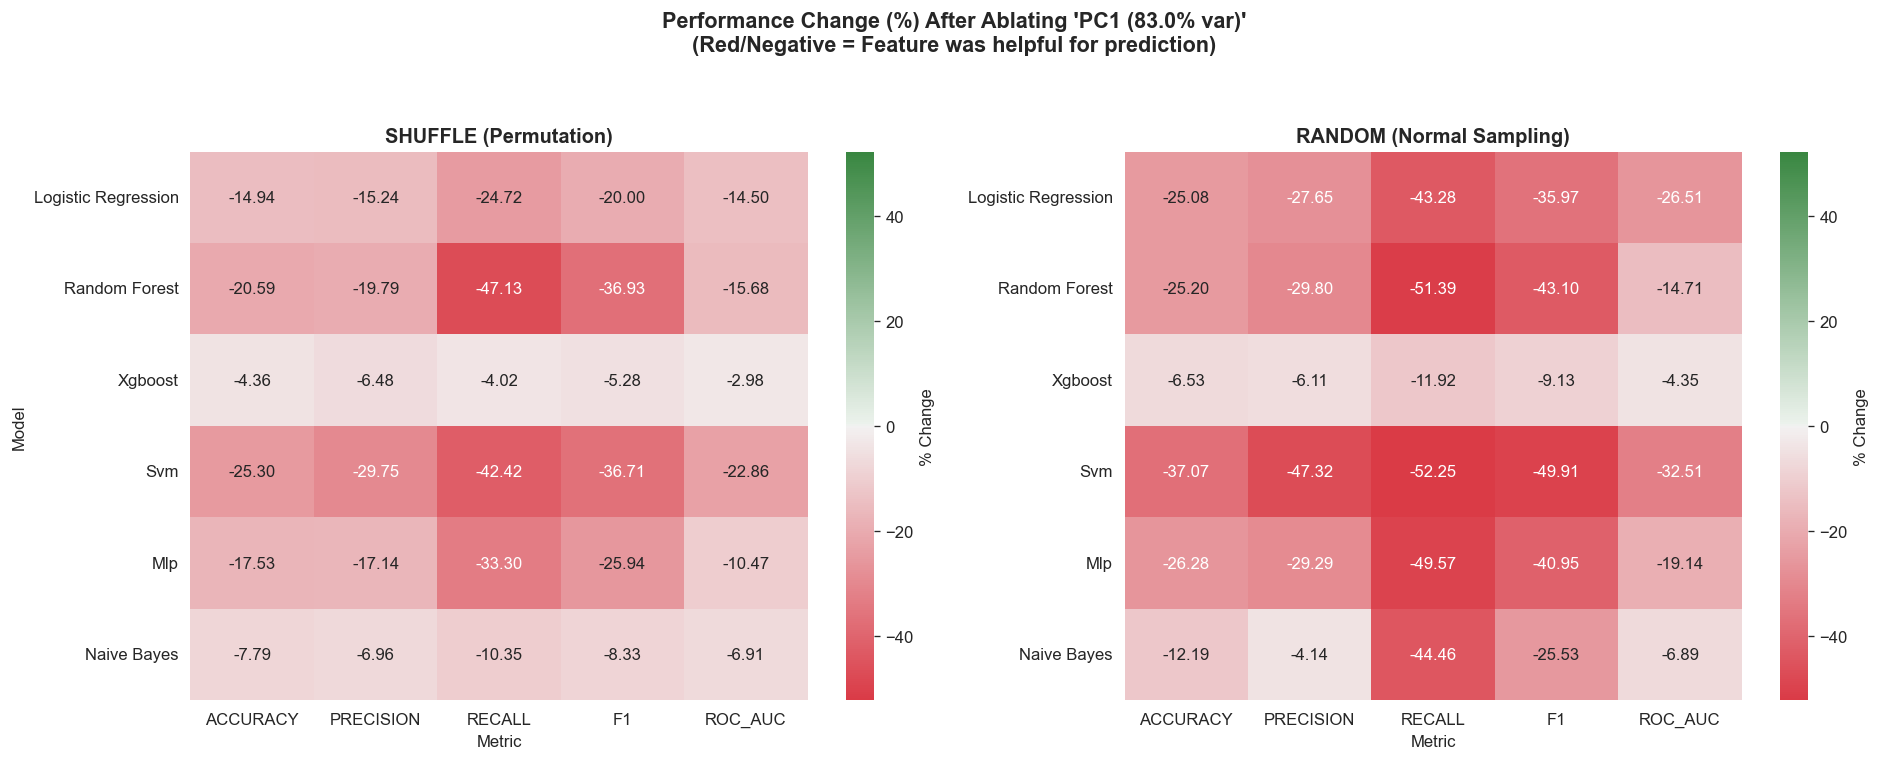

In [194]:
# Visualization: Heatmap for PC1
plot_ablation_heatmap(
    summary_dfs_pc1, f"PC1 ({pca_trinuc.explained_variance_ratio_[0]:.1%} var)",
    model_names=list(models.keys()),
    save_path=f"graphs/trinuc_feature_ablation/{ablation_feature_pc1_name}_ablation_heatmap_comparison.png"
)


In [195]:
# Interpretation for PC1
_ = summarize_ablation_compact(results_original_pc1, summary_dfs_pc1, "PC1", metric="roc_auc")

for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_pc1, summary_dfs_pc1, "PC1")



📊 Compact Comparison (ROC-AUC) for 'PC1':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.8035,-0.1363,0.6906,-0.2491
1,Random Forest,0.9526,0.8032,-0.1494,0.8124,-0.1402
2,Xgboost,0.9548,0.9263,-0.0284,0.9132,-0.0416
3,Svm,0.9490,0.7320,-0.2170,0.6405,-0.3085
4,Mlp,0.9468,0.8477,-0.0991,0.7656,-0.1812
5,Naive Bayes,0.8275,0.7703,-0.0572,0.7705,-0.0570



🔍 INTERPRETATION: Logistic Regression — Feature: 'PC1'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.7346±0.0124  (Δ=-0.1290 ↓, -14.94%)
   PRECISION   : 0.6729±0.0170  (Δ=-0.1210 ↓, -15.24%)
   RECALL      : 0.6752±0.0192  (Δ=-0.2218 ↓, -24.72%)
   F1          : 0.6739±0.0149  (Δ=-0.1684 ↓, -20.00%)
   ROC_AUC     : 0.8035±0.0144  (Δ=-0.1363 ↓, -14.50%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.6470±0.0169  (Δ=-0.2166 ↓, -25.08%)
   PRECISION   : 0.5744±0.0251  (Δ=-0.2195 ↓, -27.65%)
   RECALL      : 0.5088±0.0222  (Δ=-0.3882 ↓, -43.28%)
   F1          : 0.5393±0.0202  (Δ=-0.3030 ↓, -35.97%)
   ROC_AUC     : 0.6906±0.0148  (Δ=-0.2491 ↓, -26.51%)

─────────────────────────────────────────────────────

In [196]:
# Save results for PC1
for method in ablation_methods:
    output_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_pc1_name}_{method}.csv")
    summary_dfs_pc1[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

combined_df_pc1 = pd.concat([summary_dfs_pc1['shuffle'], summary_dfs_pc1['random']], ignore_index=True)
combined_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_pc1_name}_combined.csv")
combined_df_pc1.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/trinuc_feature_ablation/ablation_results_PC1_shuffle.csv
💾 Saved random results → graphs/trinuc_feature_ablation/ablation_results_PC1_random.csv
💾 Saved combined results → graphs/trinuc_feature_ablation/ablation_results_PC1_combined.csv


## PC1-5 Ablation


In [210]:
# Run ablation study for PC1-5
pc1_5_indices = list(range(5))  # PCs 0-4 (PC1-PC5)
ablation_feature_pc1_5_name = "PC1-5"
var_explained_pc1_5 = pca_trinuc.explained_variance_ratio_[:5].sum()

n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: PC1-5 (explains {var_explained_pc1_5:.2%} variance)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_pc1_5 = {}
results_ablated_pc1_5 = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_pc1_5[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (PC1-5)...")
    for seed in seeds:
        X_val_ablated = ablate_pca_components(
            X_val, trinuc_features, scaler_trinuc, pca_trinuc,
            pc_indices=pc1_5_indices, method=method, random_state=seed, X_train=X_train
        )
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_pc1_5[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ PC1-5 ablation study complete!")

# Get PC1-5 loadings (first 5 components)
pc1_5_loadings = pca_trinuc.components_[0:5]

# Calculate average absolute loading across PC1-5 for each trinucleotide
avg_abs_loading = np.abs(pc1_5_loadings).mean(axis=0)

# Create dataframe
pc5_df = pd.DataFrame({
    'trinucleotide': trinuc_features,
    'avg_abs_loading': avg_abs_loading
}).sort_values('avg_abs_loading', ascending=False)

print("=" * 60)
print("TOP 10 TRINUCLEOTIDES WITH HIGHEST AVERAGE PC1-5 LOADINGS:")
print("=" * 60)
print(pc5_df.head(10))

print("\n" + "=" * 60)
print("BOTTOM 10 TRINUCLEOTIDES WITH LOWEST AVERAGE PC1-5 LOADINGS:")
print("=" * 60)
print(pc5_df.tail(10))

# Check GC correlation
def gc_content(trinuc):
    trinuc_str = trinuc.replace('trinuc_', '')
    gc_count = trinuc_str.count('G') + trinuc_str.count('C')
    return gc_count / 3.0

pc5_df['gc_content'] = pc5_df['trinucleotide'].apply(gc_content)
correlation = pc5_df['avg_abs_loading'].corr(pc5_df['gc_content'])

print("\n" + "=" * 60)
print(f"CORRELATION BETWEEN AVG PC1-5 LOADING AND GC CONTENT: {correlation:.4f}")
print("=" * 60)


🔬 Ablation Study: PC1-5 (explains 93.23% variance)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (PC1-5)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (PC1-5)...
   ✓ Completed 10 runs with 'random' method

✅ PC1-5 ablation study complete!
TOP 10 TRINUCLEOTIDES WITH HIGHEST AVERAGE PC1-5 LOADINGS:
   trinucleotide  avg_abs_loading
21    trinuc_CCC         0.181509
25    trinuc_CGC         0.177041
38    trinuc_GCG         0.152810
37    trinuc_GCC         0.145205
34    trinuc_GAG         0.144714
22    trinuc_CCG         0.143025
41    trinuc_GGC         0.140982
0     trinuc_AAA         0.140270
63    trinuc_TTT         0.134884
49    trinuc_TAC         0.133297

BOTTOM 10 TRINUCLEOTIDES WITH LOWEST AVERAGE PC1-5 LOADINGS:
   trinucle

In [211]:
# Analyze each PC from 2-5 individually
for pc_idx in range(1, 5):  # PC2, PC3, PC4, PC5 (indices 1, 2, 3, 4)
    pc_num = pc_idx + 1
    loadings = pca_trinuc.components_[pc_idx]
    
    # Create dataframe for this PC
    pc_df = pd.DataFrame({
        'trinucleotide': trinuc_features,
        'loading': loadings
    }).sort_values('loading', ascending=False)
    
    variance_explained = pca_trinuc.explained_variance_ratio_[pc_idx]
    
    print("\n" + "=" * 60)
    print(f"PC{pc_num} (explains {variance_explained:.2%} of variance)")
    print("=" * 60)
    
    print(f"\nTOP 10 HIGHEST LOADINGS:")
    for trinuc, loading in pc_df.head(10)[['trinucleotide', 'loading']].values:
        print(f"  {trinuc.replace('trinuc_', ''): <3} → {loading:+.6f}")
    
    print(f"\nBOTTOM 10 LOWEST LOADINGS:")
    for trinuc, loading in pc_df.tail(10)[['trinucleotide', 'loading']].values:
        print(f"  {trinuc.replace('trinuc_', ''): <3} → {loading:+.6f}")
    
    # Check GC correlation for this PC
    pc_df['gc_content'] = pc_df['trinucleotide'].apply(gc_content)
    correlation = pc_df['loading'].corr(pc_df['gc_content'])
    print(f"\nCorrelation with GC content: {correlation:.4f}")


PC2 (explains 6.67% of variance)

TOP 10 HIGHEST LOADINGS:
  TAT → +0.272624
  ATT → +0.266260
  TTT → +0.244643
  ATA → +0.235783
  TTA → +0.205337
  AAT → +0.198565
  TTC → +0.166240
  CAT → +0.165160
  AAA → +0.153545
  TAA → +0.140071

BOTTOM 10 LOWEST LOADINGS:
  GAG → -0.126853
  GGA → -0.129298
  CCC → -0.130464
  GGT → -0.133307
  AGG → -0.140742
  GCG → -0.178728
  GGC → -0.179742
  CCG → -0.206303
  CGG → -0.209977
  GGG → -0.210847

Correlation with GC content: -0.8809

PC3 (explains 1.68% of variance)

TOP 10 HIGHEST LOADINGS:
  CGC → +0.356272
  GCG → +0.179877
  CCG → +0.179604
  ATC → +0.146037
  GCC → +0.133185
  TCT → +0.129659
  TCC → +0.122474
  CTG → +0.122317
  TTC → +0.120654
  GCT → +0.119395

BOTTOM 10 LOWEST LOADINGS:
  GTG → -0.155674
  GGA → -0.166925
  AGT → -0.169178
  AAA → -0.181333
  TAG → -0.185711
  AGG → -0.204998
  GAA → -0.253543
  GAG → -0.256202
  AAG → -0.262119
  AGA → -0.262607

Correlation with GC content: 0.3624

PC4 (explains 1.15% of varia

In [198]:
# Create summary DataFrames for PC1-5
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_pc1_5 = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        for metric in metrics:
            row[f'{metric}_original'] = results_original_pc1_5[model_name][metric]
        
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_pc1_5[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            original_val = results_original_pc1_5[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_pc1_5[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for PC1-5")


✅ Summary DataFrames created for PC1-5



💾 Heatmap saved to: graphs/trinuc_feature_ablation/PC1-5_ablation_heatmap_comparison.png


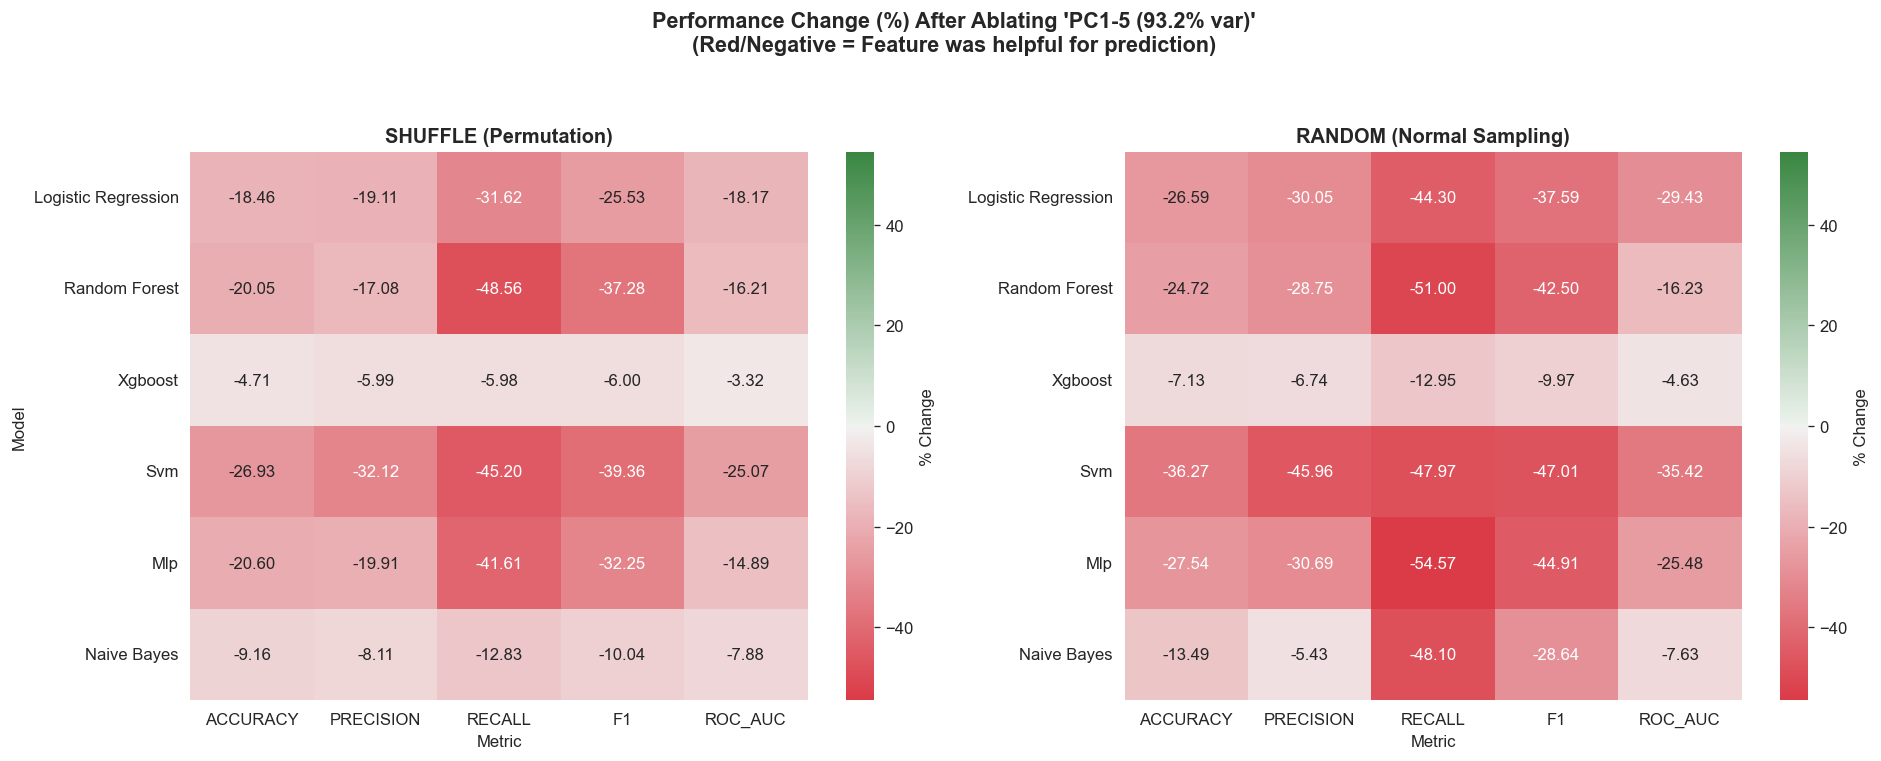

In [199]:
# Visualization: Heatmap for PC1-5
plot_ablation_heatmap(
    summary_dfs_pc1_5, f"PC1-5 ({var_explained_pc1_5:.1%} var)",
    model_names=list(models.keys()),
    save_path=f"graphs/trinuc_feature_ablation/{ablation_feature_pc1_5_name}_ablation_heatmap_comparison.png"
)


In [200]:
# Interpretation for PC1-5
_ = summarize_ablation_compact(results_original_pc1_5, summary_dfs_pc1_5, "PC1-5", metric="roc_auc")

for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_pc1_5, summary_dfs_pc1_5, "PC1-5")



📊 Compact Comparison (ROC-AUC) for 'PC1-5':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.7690,-0.1708,0.6632,-0.2765
1,Random Forest,0.9526,0.7982,-0.1544,0.7979,-0.1547
2,Xgboost,0.9548,0.9231,-0.0317,0.9106,-0.0442
3,Svm,0.9490,0.7111,-0.2379,0.6128,-0.3362
4,Mlp,0.9468,0.8058,-0.1410,0.7055,-0.2413
5,Naive Bayes,0.8275,0.7623,-0.0652,0.7644,-0.0631



🔍 INTERPRETATION: Logistic Regression — Feature: 'PC1-5'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.7042±0.0132  (Δ=-0.1594 ↓, -18.46%)
   PRECISION   : 0.6422±0.0149  (Δ=-0.1517 ↓, -19.11%)
   RECALL      : 0.6134±0.0287  (Δ=-0.2836 ↓, -31.62%)
   F1          : 0.6272±0.0205  (Δ=-0.2151 ↓, -25.53%)
   ROC_AUC     : 0.7690±0.0148  (Δ=-0.1708 ↓, -18.17%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.6340±0.0199  (Δ=-0.2296 ↓, -26.59%)
   PRECISION   : 0.5553±0.0275  (Δ=-0.2386 ↓, -30.05%)
   RECALL      : 0.4996±0.0303  (Δ=-0.3973 ↓, -44.30%)
   F1          : 0.5256±0.0258  (Δ=-0.3166 ↓, -37.59%)
   ROC_AUC     : 0.6632±0.0179  (Δ=-0.2765 ↓, -29.43%)

───────────────────────────────────────────────────

In [201]:
# Save results for PC1-5
for method in ablation_methods:
    output_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_pc1_5_name}_{method}.csv")
    summary_dfs_pc1_5[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

combined_df_pc1_5 = pd.concat([summary_dfs_pc1_5['shuffle'], summary_dfs_pc1_5['random']], ignore_index=True)
combined_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_pc1_5_name}_combined.csv")
combined_df_pc1_5.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/trinuc_feature_ablation/ablation_results_PC1-5_shuffle.csv
💾 Saved random results → graphs/trinuc_feature_ablation/ablation_results_PC1-5_random.csv
💾 Saved combined results → graphs/trinuc_feature_ablation/ablation_results_PC1-5_combined.csv


## PC1-10 Ablation


In [212]:
# Run ablation study for PC1-10
pc1_10_indices = list(range(10))  # PCs 0-9 (PC1-PC10)
ablation_feature_pc1_10_name = "PC1-10"
var_explained_pc1_10 = pca_trinuc.explained_variance_ratio_[:10].sum()

n_runs = 10
seeds = list(range(42, 42 + n_runs))
ablation_methods = ["shuffle", "random"]

print(f"🔬 Ablation Study: PC1-10 (explains {var_explained_pc1_10:.2%} variance)")
print(f"{'='*70}")
print(f"   Using {n_runs} random seeds for statistical robustness")
print(f"   Methods: {ablation_methods}\n")

# Store results
results_original_pc1_10 = {}
results_ablated_pc1_10 = {
    method: {model_name: [] for model_name in models.keys()}
    for method in ablation_methods
}

# Evaluate on original data (baseline)
print("📊 Evaluating on ORIGINAL validation data...")
for model_name, model in models.items():
    results_original_pc1_10[model_name] = evaluate_model(model, X_val, y_val)
    print(f"   ✓ {model_name}")

# Evaluate on ablated data for each method
for method in ablation_methods:
    print(f"\n🔀 Evaluating with '{method.upper()}' ablation (PC1-10)...")
    for seed in seeds:
        X_val_ablated = ablate_pca_components(
            X_val, trinuc_features, scaler_trinuc, pca_trinuc,
            pc_indices=pc1_10_indices, method=method, random_state=seed, X_train=X_train
        )
        
        for model_name, model in models.items():
            metrics_result = evaluate_model(model, X_val_ablated, y_val)
            results_ablated_pc1_10[method][model_name].append(metrics_result)
    
    print(f"   ✓ Completed {n_runs} runs with '{method}' method")

print("\n✅ PC1-10 ablation study complete!")

# Analyze each PC from 6-10 individually
for pc_idx in range(5, 10):  # PC6, PC7, PC8, PC9, PC10 (indices 5, 6, 7, 8, 9)
    pc_num = pc_idx + 1
    loadings = pca_trinuc.components_[pc_idx]
    
    # Create dataframe for this PC
    pc_df = pd.DataFrame({
        'trinucleotide': trinuc_features,
        'loading': loadings
    }).sort_values('loading', ascending=False)
    
    variance_explained = pca_trinuc.explained_variance_ratio_[pc_idx]
    
    print("\n" + "=" * 60)
    print(f"PC{pc_num} (explains {variance_explained:.2%} of variance)")
    print("=" * 60)
    
    print(f"\nTOP 10 HIGHEST LOADINGS:")
    for trinuc, loading in pc_df.head(10)[['trinucleotide', 'loading']].values:
        print(f"  {trinuc.replace('trinuc_', ''): <3} → {loading:+.6f}")
    
    print(f"\nBOTTOM 10 LOWEST LOADINGS:")
    for trinuc, loading in pc_df.tail(10)[['trinucleotide', 'loading']].values:
        print(f"  {trinuc.replace('trinuc_', ''): <3} → {loading:+.6f}")
    
    # Check GC correlation for this PC
    pc_df['gc_content'] = pc_df['trinucleotide'].apply(gc_content)
    correlation = pc_df['loading'].corr(pc_df['gc_content'])
    print(f"\nCorrelation with GC content: {correlation:.4f}")


🔬 Ablation Study: PC1-10 (explains 95.47% variance)
   Using 10 random seeds for statistical robustness
   Methods: ['shuffle', 'random']

📊 Evaluating on ORIGINAL validation data...
   ✓ logistic_regression
   ✓ random_forest
   ✓ xgboost
   ✓ svm
   ✓ mlp
   ✓ naive_bayes

🔀 Evaluating with 'SHUFFLE' ablation (PC1-10)...
   ✓ Completed 10 runs with 'shuffle' method

🔀 Evaluating with 'RANDOM' ablation (PC1-10)...
   ✓ Completed 10 runs with 'random' method

✅ PC1-10 ablation study complete!

PC6 (explains 0.64% of variance)

TOP 10 HIGHEST LOADINGS:
  TCT → +0.315118
  GGG → +0.229352
  GTT → +0.228688
  CTC → +0.215633
  TTT → +0.211969
  GGT → +0.208364
  CCC → +0.170618
  CTT → +0.160045
  TTC → +0.139279
  TCC → +0.130947

BOTTOM 10 LOWEST LOADINGS:
  GAC → -0.122730
  TCA → -0.126884
  CCT → -0.136902
  CGC → -0.150568
  ACG → -0.191015
  GCA → -0.201543
  CAC → -0.215728
  ACA → -0.224513
  GCC → -0.232726
  CAT → -0.283500

Correlation with GC content: -0.0604

PC7 (explains 0

In [203]:
# Create summary DataFrames for PC1-10
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
summary_dfs_pc1_10 = {}

for method in ablation_methods:
    summary_rows = []
    
    for model_name in models.keys():
        row = {'model': model_name, 'method': method}
        
        for metric in metrics:
            row[f'{metric}_original'] = results_original_pc1_10[model_name][metric]
        
        for metric in metrics:
            ablated_values = [run[metric] for run in results_ablated_pc1_10[method][model_name]]
            row[f'{metric}_ablated_mean'] = np.mean(ablated_values)
            row[f'{metric}_ablated_std'] = np.std(ablated_values)
            
            original_val = results_original_pc1_10[model_name][metric]
            ablated_mean = np.mean(ablated_values)
            row[f'{metric}_delta'] = ablated_mean - original_val
            row[f'{metric}_pct_change'] = ((ablated_mean - original_val) / original_val) * 100
        
        summary_rows.append(row)
    
    summary_dfs_pc1_10[method] = pd.DataFrame(summary_rows)

print("✅ Summary DataFrames created for PC1-10")


✅ Summary DataFrames created for PC1-10



💾 Heatmap saved to: graphs/trinuc_feature_ablation/PC1-10_ablation_heatmap_comparison.png


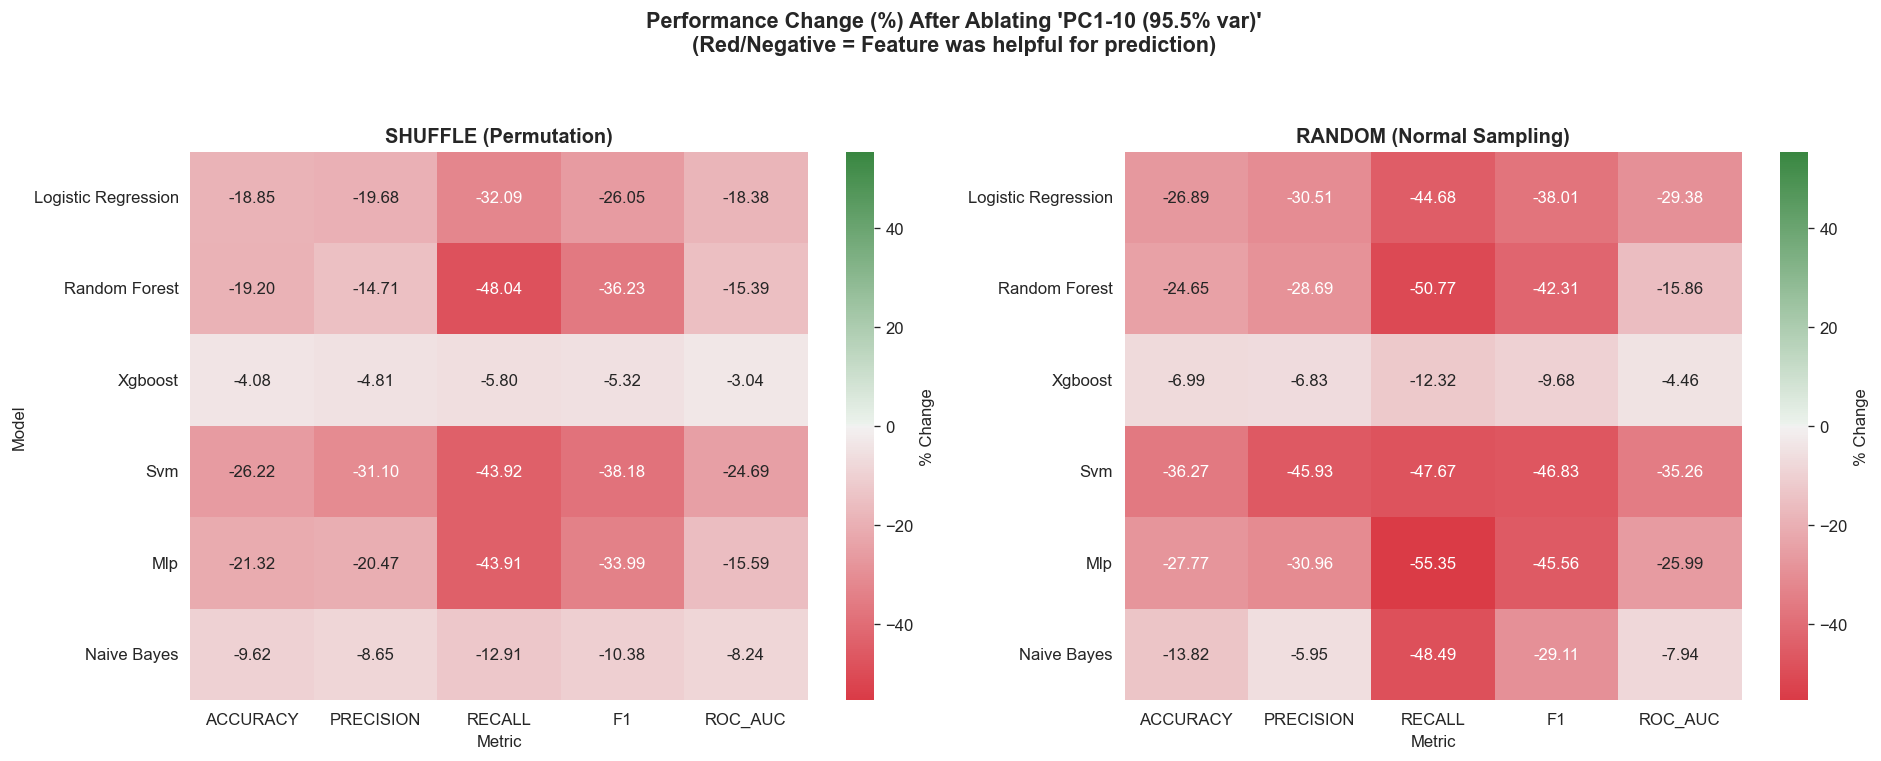

In [204]:
# Visualization: Heatmap for PC1-10
plot_ablation_heatmap(
    summary_dfs_pc1_10, f"PC1-10 ({var_explained_pc1_10:.1%} var)",
    model_names=list(models.keys()),
    save_path=f"graphs/trinuc_feature_ablation/{ablation_feature_pc1_10_name}_ablation_heatmap_comparison.png"
)


In [205]:
# Interpretation for PC1-10
_ = summarize_ablation_compact(results_original_pc1_10, summary_dfs_pc1_10, "PC1-10", metric="roc_auc")

for model_name in models.keys():
    interpret_model_ablation(model_name, results_original_pc1_10, summary_dfs_pc1_10, "PC1-10")



📊 Compact Comparison (ROC-AUC) for 'PC1-10':


,Model,ROC-AUC (Original),ROC-AUC (Shuffle),Δ Shuffle,ROC-AUC (Random),Δ Random
0,Logistic Regression,0.9397,0.7670,-0.1727,0.6636,-0.2761
1,Random Forest,0.9526,0.8060,-0.1466,0.8015,-0.1511
2,Xgboost,0.9548,0.9258,-0.0290,0.9122,-0.0426
3,Svm,0.9490,0.7146,-0.2344,0.6144,-0.3346
4,Mlp,0.9468,0.7992,-0.1476,0.7007,-0.2460
5,Naive Bayes,0.8275,0.7593,-0.0682,0.7618,-0.0657



🔍 INTERPRETATION: Logistic Regression — Feature: 'PC1-10'

📊 Original Performance:
   ACCURACY    : 0.8636
   PRECISION   : 0.7939
   RECALL      : 0.8969
   F1          : 0.8423
   ROC_AUC     : 0.9397

🔀 SHUFFLE Ablation (Permutation):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.7008±0.0110  (Δ=-0.1628 ↓, -18.85%)
   PRECISION   : 0.6377±0.0104  (Δ=-0.1563 ↓, -19.68%)
   RECALL      : 0.6092±0.0287  (Δ=-0.2878 ↓, -32.09%)
   F1          : 0.6229±0.0194  (Δ=-0.2194 ↓, -26.05%)
   ROC_AUC     : 0.7670±0.0153  (Δ=-0.1727 ↓, -18.38%)

🔀 RANDOM Ablation (Random Sampling):
────────────────────────────────────────────────────────────
   ACCURACY    : 0.6313±0.0187  (Δ=-0.2322 ↓, -26.89%)
   PRECISION   : 0.5517±0.0259  (Δ=-0.2422 ↓, -30.51%)
   RECALL      : 0.4962±0.0293  (Δ=-0.4008 ↓, -44.68%)
   F1          : 0.5221±0.0246  (Δ=-0.3202 ↓, -38.01%)
   ROC_AUC     : 0.6636±0.0183  (Δ=-0.2761 ↓, -29.38%)

──────────────────────────────────────────────────

In [206]:
# Save results for PC1-10
for method in ablation_methods:
    output_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_pc1_10_name}_{method}.csv")
    summary_dfs_pc1_10[method].to_csv(output_path, index=False)
    print(f"💾 Saved {method} results → {output_path}")

combined_df_pc1_10 = pd.concat([summary_dfs_pc1_10['shuffle'], summary_dfs_pc1_10['random']], ignore_index=True)
combined_path = Path(f"graphs/trinuc_feature_ablation/ablation_results_{ablation_feature_pc1_10_name}_combined.csv")
combined_df_pc1_10.to_csv(combined_path, index=False)
print(f"💾 Saved combined results → {combined_path}")


💾 Saved shuffle results → graphs/trinuc_feature_ablation/ablation_results_PC1-10_shuffle.csv
💾 Saved random results → graphs/trinuc_feature_ablation/ablation_results_PC1-10_random.csv
💾 Saved combined results → graphs/trinuc_feature_ablation/ablation_results_PC1-10_combined.csv
